In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import string
import nltk
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

In [4]:
df=pd.read_csv('reddit-india-final-dataset.csv')

In [7]:
df.head()

title  score      id  \
0  Pitting a community against a political party ...    196  futac9   
1  Pitting a community against a political party ...    198  futac9   
2  Hit by backlash over posts on lack of medical ...    404  fpaj1w   
3  A new political party gave a full front page a...    731  ff8sth   
4  I’ve been curious, which Indian politicians do...     43  fs887w   

                                                 url  comms_num  \
0  https://www.reddit.com/r/india/comments/futac9...         73   
1  https://www.reddit.com/r/india/comments/futac9...         73   
2  https://theprint.in/india/hit-by-backlash-over...         67   
3                https://i.redd.it/yjo9wpy38el41.jpg        146   
4  https://www.reddit.com/r/india/comments/fs887w...         51   

                                                body              author  \
0  First of all let me start by saying it was stu...   chillinvillain122   
1  First of all let me start by saying it was stu...   chillinvillain122   
2                                                NaN           hipporama   
3                                                NaN       aaluinsonaout   
4  Personally, I would pick Kerala-CM, Pinarayi V...  I_can_believe_that   

                                            comments            timestamp  \
0   If there is anything positive in the fight ag...  2020-04-05 02:28:28   
1   What an incredibly narrow minded person. Our ...  2020-04-05 02:28:28   
2   So the argument is that the DMs could have co...  2020-03-27 01:47:25   
3   I tend to agree with her. After the first Del...  2020-03-08 20:06:11   
4   Except Indira all of them loved dissent. They...  2020-03-31 20:29:29   

   numerical_flair     flair  
0                0  Politics  
1                0  Politics  
2                0  Politics  
3                0  Politics  
4                0  Politics

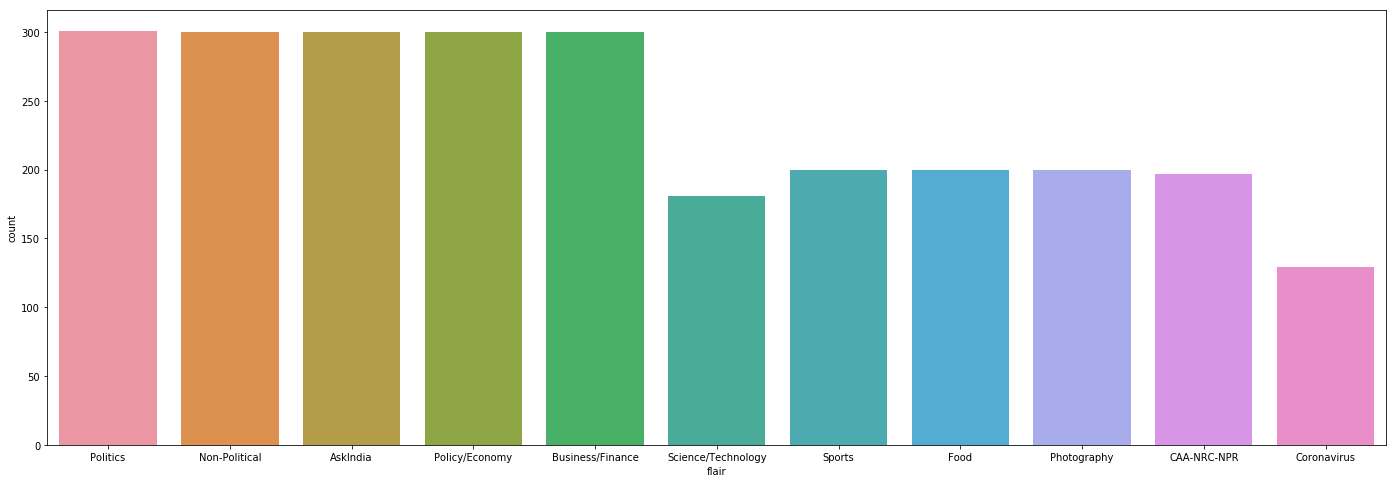

In [3]:
plt.figure(figsize=(24,8))
sns.countplot(df['flair'])

In [9]:
df.describe()

score     comms_num  numerical_flair
count   2608.000000   2608.000000      2608.000000
mean     192.435199     56.368865         4.282209
std      744.494924    312.513484         3.056701
min        0.000000      0.000000         0.000000
25%       12.000000      3.000000         2.000000
50%       36.000000     12.000000         4.000000
75%      150.000000     42.000000         7.000000
max    17786.000000  11006.000000        10.000000

In [10]:
df['title_length']=df['title'].apply(len)

In [11]:
df.isna().sum()

title                 0
score                 0
id                    0
url                   0
comms_num             0
body               1144
author                0
comments            239
timestamp             0
numerical_flair       0
flair                 0
title_length          0
dtype: int64

In [12]:
df[df['body'].isna()].groupby('flair').count()

title  score   id  url  comms_num  body  author  comments  \
flair                                                                           
Business/Finance       75     75   75   75         75     0      75        72   
CAA-NRC-NPR           128    128  128  128        128     0     128       101   
Coronavirus           114    114  114  114        114     0     114        91   
Food                  104    104  104  104        104     0     104       100   
Non-Political         164    164  164  164        164     0     164       156   
Photography            69     69   69   69         69     0      69        63   
Policy/Economy         99     99   99   99         99     0      99        83   
Politics              216    216  216  216        216     0     216       196   
Science/Technology     86     86   86   86         86     0      86        69   
Sports                 89     89   89   89         89     0      89        87   

                    timestamp  numerical_flair  title_length  
flair                                                         
Business/Finance           75               75            75  
CAA-NRC-NPR               128              128           128  
Coronavirus               114              114           114  
Food                      104              104           104  
Non-Political             164              164           164  
Photography                69               69            69  
Policy/Economy             99               99            99  
Politics                  216              216           216  
Science/Technology         86               86            86  
Sports                     89               89            89

In [13]:
df[df['comments'].isna()].groupby('flair').count()

title  score  id  url  comms_num  body  author  comments  \
flair                                                                          
AskIndia               18     18  18   18         18    18      18         0   
Business/Finance       11     11  11   11         11     8      11         0   
CAA-NRC-NPR            31     31  31   31         31     4      31         0   
Coronavirus            26     26  26   26         26     3      26         0   
Food                    9      9   9    9          9     5       9         0   
Non-Political          22     22  22   22         22    14      22         0   
Photography            19     19  19   19         19    13      19         0   
Policy/Economy         44     44  44   44         44    28      44         0   
Politics               23     23  23   23         23     3      23         0   
Science/Technology     30     30  30   30         30    13      30         0   
Sports                  6      6   6    6          6     4       6         0   

                    timestamp  numerical_flair  title_length  
flair                                                         
AskIndia                   18               18            18  
Business/Finance           11               11            11  
CAA-NRC-NPR                31               31            31  
Coronavirus                26               26            26  
Food                        9                9             9  
Non-Political              22               22            22  
Photography                19               19            19  
Policy/Economy             44               44            44  
Politics                   23               23            23  
Science/Technology         30               30            30  
Sports                      6                6             6

In [16]:
df['comment_length']=df['comments'].apply(len)

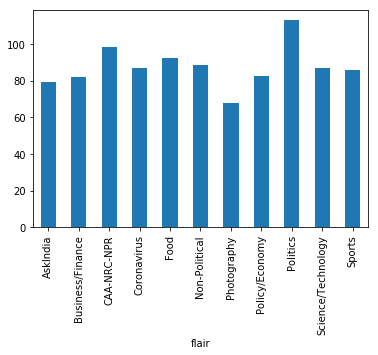

In [18]:
df.groupby('flair').mean()['title_length'].plot(kind='bar')

Title lengths re not varying for many flairs, except politics where theyre large on average 

### Comment Text Preprocessing

We will now work upon the comment data to preprocess it. 

In [2]:
stop_words=stopwords.words('english')
lancaster=LancasterStemmer()
global commentno
commentno=0

In [57]:
def text_process(words):
    words=str(words)
    global commentno
    print("processing line number",commentno)
    commentno+=1
    if(len(words)==0):
        return [lancaster.stem(word) for word in "No Body"]
    words= BeautifulSoup(words, "lxml").text
    words=words.lower()
    nopunc=[char for char in words if char not in string.punctuation]
    nopunc=''.join(nopunc)
    wordlist= [lancaster.stem(word) for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    wordlist=' '.join(wordlist)
    return wordlist

In [59]:
x=text_process(df['comments'].iloc[1])
x

processing line number 34916


'incred narrow mind person gre grandfath nat peopl pak hum person hat pakistan ind govern hat shouldn’t transfer peopl meanwhil zee new cinem univers peic shit channelhttpsyoutubeffjngaqk6zw girl said pak isnt equip deal vir ar equip deal vir fev could die would good thing wip said front peopl nat liv abroad nev shop pakistan shop half cal ind shop run pak least europ interact pak abroad would understand someon within ind say let fac cur polit atmosph ind would surpr liv abroad say shit lik horr person delet ya go anoth thread lost causehttpsnpredditcomrindiacommentsflmmpsmanridingmotorcyclebeatenupinmaharashtra two mind feel shouldnt gen dehum peopl seem gross unfair war gam rul class shouldnt destroy hum individ ther also angl memb trib relig nat rac cast ethn etc nee aw trib harm act toward oth exact tol individ inst memb cast espec cast and commun individ group feel heat oth ev individ may cast commun otherw much less int fix tribespeopl us principl respect hat memb trib exhibit ce

In [210]:
global commentno
commentno=0
df['stem_comments']=df['comments'].apply(lambda x: text_process(x))

processing line number 0
processing line number 1
processing line number 2
processing line number 3
processing line number 4
processing line number 5
processing line number 6
processing line number 7
processing line number 8
processing line number 9
processing line number 10
processing line number 11
processing line number 12
processing line number 13
processing line number 14
processing line number 15
processing line number 16
processing line number 17
processing line number 18
processing line number 19
processing line number 20
processing line number 21
processing line number 22
processing line number 23
processing line number 24
processing line number 25
processing line number 26
processing line number 27
processing line number 28
processing line number 29
processing line number 30
processing line number 31
processing line number 32
processing line number 33
processing line number 34
processing line number 35
processing line number 36
processing line number 37
processing line number

processing line number 308
processing line number 309
processing line number 310
processing line number 311
processing line number 312
processing line number 313
processing line number 314
processing line number 315
processing line number 316
processing line number 317
processing line number 318
processing line number 319
processing line number 320
processing line number 321
processing line number 322
processing line number 323
processing line number 324
processing line number 325
processing line number 326
processing line number 327
processing line number 328
processing line number 329
processing line number 330
processing line number 331
processing line number 332
processing line number 333
processing line number 334
processing line number 335
processing line number 336
processing line number 337
processing line number 338
processing line number 339
processing line number 340
processing line number 341
processing line number 342
processing line number 343
processing line number 344
p

processing line number 616
processing line number 617
processing line number 618
processing line number 619
processing line number 620
processing line number 621
processing line number 622
processing line number 623
processing line number 624
processing line number 625
processing line number 626
processing line number 627
processing line number 628
processing line number 629
processing line number 630
processing line number 631
processing line number 632
processing line number 633
processing line number 634
processing line number 635
processing line number 636
processing line number 637
processing line number 638
processing line number 639
processing line number 640
processing line number 641
processing line number 642
processing line number 643
processing line number 644
processing line number 645
processing line number 646
processing line number 647
processing line number 648
processing line number 649
processing line number 650
processing line number 651
processing line number 652
p

processing line number 921
processing line number 922
processing line number 923
processing line number 924
processing line number 925
processing line number 926
processing line number 927
processing line number 928
processing line number 929
processing line number 930
processing line number 931
processing line number 932
processing line number 933
processing line number 934
processing line number 935
processing line number 936
processing line number 937
processing line number 938
processing line number 939
processing line number 940
processing line number 941
processing line number 942
processing line number 943
processing line number 944
processing line number 945
processing line number 946
processing line number 947
processing line number 948
processing line number 949
processing line number 950
processing line number 951
processing line number 952
processing line number 953
processing line number 954
processing line number 955
processing line number 956
processing line number 957
p

processing line number 1220
processing line number 1221
processing line number 1222
processing line number 1223
processing line number 1224
processing line number 1225
processing line number 1226
processing line number 1227
processing line number 1228
processing line number 1229
processing line number 1230
processing line number 1231
processing line number 1232
processing line number 1233
processing line number 1234
processing line number 1235
processing line number 1236
processing line number 1237
processing line number 1238
processing line number 1239
processing line number 1240
processing line number 1241
processing line number 1242
processing line number 1243
processing line number 1244
processing line number 1245
processing line number 1246
processing line number 1247
processing line number 1248
processing line number 1249
processing line number 1250
processing line number 1251
processing line number 1252
processing line number 1253
processing line number 1254
processing line numb

processing line number 1515
processing line number 1516
processing line number 1517
processing line number 1518
processing line number 1519
processing line number 1520
processing line number 1521
processing line number 1522
processing line number 1523
processing line number 1524
processing line number 1525
processing line number 1526
processing line number 1527
processing line number 1528
processing line number 1529
processing line number 1530
processing line number 1531
processing line number 1532
processing line number 1533
processing line number 1534
processing line number 1535
processing line number 1536
processing line number 1537
processing line number 1538
processing line number 1539
processing line number 1540
processing line number 1541
processing line number 1542
processing line number 1543
processing line number 1544
processing line number 1545
processing line number 1546
processing line number 1547
processing line number 1548
processing line number 1549
processing line numb

processing line number 1808
processing line number 1809
processing line number 1810
processing line number 1811
processing line number 1812
processing line number 1813
processing line number 1814
processing line number 1815
processing line number 1816
processing line number 1817
processing line number 1818
processing line number 1819
processing line number 1820
processing line number 1821
processing line number 1822
processing line number 1823
processing line number 1824
processing line number 1825
processing line number 1826
processing line number 1827
processing line number 1828
processing line number 1829
processing line number 1830
processing line number 1831
processing line number 1832
processing line number 1833
processing line number 1834
processing line number 1835
processing line number 1836
processing line number 1837
processing line number 1838
processing line number 1839
processing line number 1840
processing line number 1841
processing line number 1842
processing line numb

processing line number 2107
processing line number 2108
processing line number 2109
processing line number 2110
processing line number 2111
processing line number 2112
processing line number 2113
processing line number 2114
processing line number 2115
processing line number 2116
processing line number 2117
processing line number 2118
processing line number 2119
processing line number 2120
processing line number 2121
processing line number 2122
processing line number 2123
processing line number 2124
processing line number 2125
processing line number 2126
processing line number 2127
processing line number 2128
processing line number 2129
processing line number 2130
processing line number 2131
processing line number 2132
processing line number 2133
processing line number 2134
processing line number 2135
processing line number 2136
processing line number 2137
processing line number 2138
processing line number 2139
processing line number 2140
processing line number 2141
processing line numb

processing line number 2402
processing line number 2403
processing line number 2404
processing line number 2405
processing line number 2406
processing line number 2407
processing line number 2408
processing line number 2409
processing line number 2410
processing line number 2411
processing line number 2412
processing line number 2413
processing line number 2414
processing line number 2415
processing line number 2416
processing line number 2417
processing line number 2418
processing line number 2419
processing line number 2420
processing line number 2421
processing line number 2422
processing line number 2423
processing line number 2424
processing line number 2425
processing line number 2426
processing line number 2427
processing line number 2428
processing line number 2429
processing line number 2430
processing line number 2431
processing line number 2432
processing line number 2433
processing line number 2434
processing line number 2435
processing line number 2436
processing line numb

In [212]:
global commentno
commentno=0
df['stem_body']=df['body'].apply(lambda x: text_process(x))

processing line number 0
processing line number 1
processing line number 2
processing line number 3
processing line number 4
processing line number 5
processing line number 6
processing line number 7
processing line number 8
processing line number 9
processing line number 10
processing line number 11
processing line number 12
processing line number 13
processing line number 14
processing line number 15
processing line number 16
processing line number 17
processing line number 18
processing line number 19
processing line number 20
processing line number 21
processing line number 22
processing line number 23
processing line number 24
processing line number 25
processing line number 26
processing line number 27
processing line number 28
processing line number 29
processing line number 30
processing line number 31
processing line number 32
processing line number 33
processing line number 34
processing line number 35
processing line number 36
processing line number 37
processing line number

processing line number 311
processing line number 312
processing line number 313
processing line number 314
processing line number 315
processing line number 316
processing line number 317
processing line number 318
processing line number 319
processing line number 320
processing line number 321
processing line number 322
processing line number 323
processing line number 324
processing line number 325
processing line number 326
processing line number 327
processing line number 328
processing line number 329
processing line number 330
processing line number 331
processing line number 332
processing line number 333
processing line number 334
processing line number 335
processing line number 336
processing line number 337
processing line number 338
processing line number 339
processing line number 340
processing line number 341
processing line number 342
processing line number 343
processing line number 344
processing line number 345
processing line number 346
processing line number 347
p

processing line number 615
processing line number 616
processing line number 617
processing line number 618
processing line number 619
processing line number 620
processing line number 621
processing line number 622
processing line number 623
processing line number 624
processing line number 625
processing line number 626
processing line number 627
processing line number 628
processing line number 629
processing line number 630
processing line number 631
processing line number 632
processing line number 633
processing line number 634
processing line number 635
processing line number 636
processing line number 637
processing line number 638
processing line number 639
processing line number 640
processing line number 641
processing line number 642
processing line number 643
processing line number 644
processing line number 645
processing line number 646
processing line number 647
processing line number 648
processing line number 649
processing line number 650
processing line number 651
p

processing line number 919
processing line number 920
processing line number 921
processing line number 922
processing line number 923
processing line number 924
processing line number 925
processing line number 926
processing line number 927
processing line number 928
processing line number 929
processing line number 930
processing line number 931
processing line number 932
processing line number 933
processing line number 934
processing line number 935
processing line number 936
processing line number 937
processing line number 938
processing line number 939
processing line number 940
processing line number 941
processing line number 942
processing line number 943
processing line number 944
processing line number 945
processing line number 946
processing line number 947
processing line number 948
processing line number 949
processing line number 950
processing line number 951
processing line number 952
processing line number 953
processing line number 954
processing line number 955
p

processing line number 1216
processing line number 1217
processing line number 1218
processing line number 1219
processing line number 1220
processing line number 1221
processing line number 1222
processing line number 1223
processing line number 1224
processing line number 1225
processing line number 1226
processing line number 1227
processing line number 1228
processing line number 1229
processing line number 1230
processing line number 1231
processing line number 1232
processing line number 1233
processing line number 1234
processing line number 1235
processing line number 1236
processing line number 1237
processing line number 1238
processing line number 1239
processing line number 1240
processing line number 1241
processing line number 1242
processing line number 1243
processing line number 1244
processing line number 1245
processing line number 1246
processing line number 1247
processing line number 1248
processing line number 1249
processing line number 1250
processing line numb

processing line number 1513
processing line number 1514
processing line number 1515
processing line number 1516
processing line number 1517
processing line number 1518
processing line number 1519
processing line number 1520
processing line number 1521
processing line number 1522
processing line number 1523
processing line number 1524
processing line number 1525
processing line number 1526
processing line number 1527
processing line number 1528
processing line number 1529
processing line number 1530
processing line number 1531
processing line number 1532
processing line number 1533
processing line number 1534
processing line number 1535
processing line number 1536
processing line number 1537
processing line number 1538
processing line number 1539
processing line number 1540
processing line number 1541
processing line number 1542
processing line number 1543
processing line number 1544
processing line number 1545
processing line number 1546
processing line number 1547
processing line numb

processing line number 1808
processing line number 1809
processing line number 1810
processing line number 1811
processing line number 1812
processing line number 1813
processing line number 1814
processing line number 1815
processing line number 1816
processing line number 1817
processing line number 1818
processing line number 1819
processing line number 1820
processing line number 1821
processing line number 1822
processing line number 1823
processing line number 1824
processing line number 1825
processing line number 1826
processing line number 1827
processing line number 1828
processing line number 1829
processing line number 1830
processing line number 1831
processing line number 1832
processing line number 1833
processing line number 1834
processing line number 1835
processing line number 1836
processing line number 1837
processing line number 1838
processing line number 1839
processing line number 1840
processing line number 1841
processing line number 1842
processing line numb

processing line number 2140
processing line number 2141
processing line number 2142
processing line number 2143
processing line number 2144
processing line number 2145
processing line number 2146
processing line number 2147
processing line number 2148
processing line number 2149
processing line number 2150
processing line number 2151
processing line number 2152
processing line number 2153
processing line number 2154
processing line number 2155
processing line number 2156
processing line number 2157
processing line number 2158
processing line number 2159
processing line number 2160
processing line number 2161
processing line number 2162
processing line number 2163
processing line number 2164
processing line number 2165
processing line number 2166
processing line number 2167
processing line number 2168
processing line number 2169
processing line number 2170
processing line number 2171
processing line number 2172
processing line number 2173
processing line number 2174
processing line numb

processing line number 2440
processing line number 2441
processing line number 2442
processing line number 2443
processing line number 2444
processing line number 2445
processing line number 2446
processing line number 2447
processing line number 2448
processing line number 2449
processing line number 2450
processing line number 2451
processing line number 2452
processing line number 2453
processing line number 2454
processing line number 2455
processing line number 2456
processing line number 2457
processing line number 2458
processing line number 2459
processing line number 2460
processing line number 2461
processing line number 2462
processing line number 2463
processing line number 2464
processing line number 2465
processing line number 2466
processing line number 2467
processing line number 2468
processing line number 2469
processing line number 2470
processing line number 2471
processing line number 2472
processing line number 2473
processing line number 2474
processing line numb

In [61]:
df.to_csv('reddit-india-final-dataset.csv', index=False)

In [142]:
df['combined_features']=df['title']+df['body']+df['comments']

In [157]:
global commentno
commentno=0
df['combined_features']=df['combined_features'].apply(lambda x:text_process(x))

processing comment number 0
processing comment number 1
processing comment number 2
processing comment number 3
processing comment number 4
processing comment number 5
processing comment number 6
processing comment number 7
processing comment number 8
processing comment number 9
processing comment number 10
processing comment number 11
processing comment number 12
processing comment number 13
processing comment number 14
processing comment number 15
processing comment number 16
processing comment number 17
processing comment number 18
processing comment number 19
processing comment number 20
processing comment number 21
processing comment number 22
processing comment number 23
processing comment number 24
processing comment number 25
processing comment number 26
processing comment number 27
processing comment number 28
processing comment number 29
processing comment number 30
processing comment number 31
processing comment number 32
processing comment number 33
processing comment numbe

processing comment number 280
processing comment number 281
processing comment number 282
processing comment number 283
processing comment number 284
processing comment number 285
processing comment number 286
processing comment number 287
processing comment number 288
processing comment number 289
processing comment number 290
processing comment number 291
processing comment number 292
processing comment number 293
processing comment number 294
processing comment number 295
processing comment number 296
processing comment number 297
processing comment number 298
processing comment number 299
processing comment number 300
processing comment number 301
processing comment number 302
processing comment number 303
processing comment number 304
processing comment number 305
processing comment number 306
processing comment number 307
processing comment number 308
processing comment number 309
processing comment number 310
processing comment number 311
processing comment number 312
processing

processing comment number 554
processing comment number 555
processing comment number 556
processing comment number 557
processing comment number 558
processing comment number 559
processing comment number 560
processing comment number 561
processing comment number 562
processing comment number 563
processing comment number 564
processing comment number 565
processing comment number 566
processing comment number 567
processing comment number 568
processing comment number 569
processing comment number 570
processing comment number 571
processing comment number 572
processing comment number 573
processing comment number 574
processing comment number 575
processing comment number 576
processing comment number 577
processing comment number 578
processing comment number 579
processing comment number 580
processing comment number 581
processing comment number 582
processing comment number 583
processing comment number 584
processing comment number 585
processing comment number 586
processing

processing comment number 828
processing comment number 829
processing comment number 830
processing comment number 831
processing comment number 832
processing comment number 833
processing comment number 834
processing comment number 835
processing comment number 836
processing comment number 837
processing comment number 838
processing comment number 839
processing comment number 840
processing comment number 841
processing comment number 842
processing comment number 843
processing comment number 844
processing comment number 845
processing comment number 846
processing comment number 847
processing comment number 848
processing comment number 849
processing comment number 850
processing comment number 851
processing comment number 852
processing comment number 853
processing comment number 854
processing comment number 855
processing comment number 856
processing comment number 857
processing comment number 858
processing comment number 859
processing comment number 860
processing

processing comment number 1107
processing comment number 1108
processing comment number 1109
processing comment number 1110
processing comment number 1111
processing comment number 1112
processing comment number 1113
processing comment number 1114
processing comment number 1115
processing comment number 1116
processing comment number 1117
processing comment number 1118
processing comment number 1119
processing comment number 1120
processing comment number 1121
processing comment number 1122
processing comment number 1123
processing comment number 1124
processing comment number 1125
processing comment number 1126
processing comment number 1127
processing comment number 1128
processing comment number 1129
processing comment number 1130
processing comment number 1131
processing comment number 1132
processing comment number 1133
processing comment number 1134
processing comment number 1135
processing comment number 1136
processing comment number 1137
processing comment number 1138
processi

processing comment number 1378
processing comment number 1379
processing comment number 1380
processing comment number 1381
processing comment number 1382
processing comment number 1383
processing comment number 1384
processing comment number 1385
processing comment number 1386
processing comment number 1387
processing comment number 1388
processing comment number 1389
processing comment number 1390
processing comment number 1391
processing comment number 1392
processing comment number 1393
processing comment number 1394
processing comment number 1395
processing comment number 1396
processing comment number 1397
processing comment number 1398
processing comment number 1399
processing comment number 1400
processing comment number 1401
processing comment number 1402
processing comment number 1403
processing comment number 1404
processing comment number 1405
processing comment number 1406
processing comment number 1407
processing comment number 1408
processing comment number 1409
processi

processing comment number 1648
processing comment number 1649
processing comment number 1650
processing comment number 1651
processing comment number 1652
processing comment number 1653
processing comment number 1654
processing comment number 1655
processing comment number 1656
processing comment number 1657
processing comment number 1658
processing comment number 1659
processing comment number 1660
processing comment number 1661
processing comment number 1662
processing comment number 1663
processing comment number 1664
processing comment number 1665
processing comment number 1666
processing comment number 1667
processing comment number 1668
processing comment number 1669
processing comment number 1670
processing comment number 1671
processing comment number 1672
processing comment number 1673
processing comment number 1674
processing comment number 1675
processing comment number 1676
processing comment number 1677
processing comment number 1678
processing comment number 1679
processi

processing comment number 1919
processing comment number 1920
processing comment number 1921
processing comment number 1922
processing comment number 1923
processing comment number 1924
processing comment number 1925
processing comment number 1926
processing comment number 1927
processing comment number 1928
processing comment number 1929
processing comment number 1930
processing comment number 1931
processing comment number 1932
processing comment number 1933
processing comment number 1934
processing comment number 1935
processing comment number 1936
processing comment number 1937
processing comment number 1938
processing comment number 1939
processing comment number 1940
processing comment number 1941
processing comment number 1942
processing comment number 1943
processing comment number 1944
processing comment number 1945
processing comment number 1946
processing comment number 1947
processing comment number 1948
processing comment number 1949
processing comment number 1950
processi

processing comment number 2184
processing comment number 2185
processing comment number 2186
processing comment number 2187
processing comment number 2188
processing comment number 2189
processing comment number 2190
processing comment number 2191
processing comment number 2192
processing comment number 2193
processing comment number 2194
processing comment number 2195
processing comment number 2196
processing comment number 2197
processing comment number 2198
processing comment number 2199
processing comment number 2200
processing comment number 2201
processing comment number 2202
processing comment number 2203
processing comment number 2204
processing comment number 2205
processing comment number 2206
processing comment number 2207
processing comment number 2208
processing comment number 2209
processing comment number 2210
processing comment number 2211
processing comment number 2212
processing comment number 2213
processing comment number 2214
processing comment number 2215
processi

processing comment number 2449
processing comment number 2450
processing comment number 2451
processing comment number 2452
processing comment number 2453
processing comment number 2454
processing comment number 2455
processing comment number 2456
processing comment number 2457
processing comment number 2458
processing comment number 2459
processing comment number 2460
processing comment number 2461
processing comment number 2462
processing comment number 2463
processing comment number 2464
processing comment number 2465
processing comment number 2466
processing comment number 2467
processing comment number 2468
processing comment number 2469
processing comment number 2470
processing comment number 2471
processing comment number 2472
processing comment number 2473
processing comment number 2474
processing comment number 2475
processing comment number 2476
processing comment number 2477
processing comment number 2478
processing comment number 2479
processing comment number 2480
processi

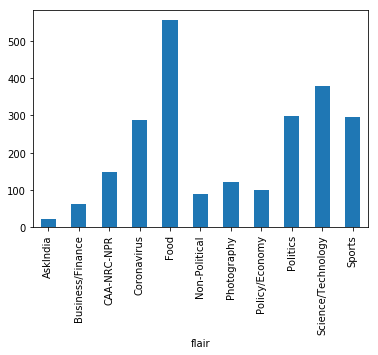

In [25]:
df.groupby('flair').mean()['score'].plot(kind='bar')

Post scores have a noticeably different means for different categories. Food posts have a high mean, while politics, scitech, sports have similar means. Hence, this can be used for classifying the data. 

In [28]:
feature_combine=df['title']+df['comments']+df['url']

In [211]:
global commentno
commentno=0
df['stemmed_titles']=df['title'].apply(lambda x:text_process(x))

processing line number 0
processing line number 1
processing line number 2
processing line number 3
processing line number 4
processing line number 5
processing line number 6
processing line number 7
processing line number 8
processing line number 9
processing line number 10
processing line number 11
processing line number 12
processing line number 13
processing line number 14
processing line number 15
processing line number 16
processing line number 17
processing line number 18
processing line number 19
processing line number 20
processing line number 21
processing line number 22
processing line number 23
processing line number 24
processing line number 25
processing line number 26
processing line number 27
processing line number 28
processing line number 29
processing line number 30
processing line number 31
processing line number 32
processing line number 33
processing line number 34
processing line number 35
processing line number 36
processing line number 37
processing line number

processing line number 312
processing line number 313
processing line number 314
processing line number 315
processing line number 316
processing line number 317
processing line number 318
processing line number 319
processing line number 320
processing line number 321
processing line number 322
processing line number 323
processing line number 324
processing line number 325
processing line number 326
processing line number 327
processing line number 328
processing line number 329
processing line number 330
processing line number 331
processing line number 332
processing line number 333
processing line number 334
processing line number 335
processing line number 336
processing line number 337
processing line number 338
processing line number 339
processing line number 340
processing line number 341
processing line number 342
processing line number 343
processing line number 344
processing line number 345
processing line number 346
processing line number 347
processing line number 348
p

processing line number 639
processing line number 640
processing line number 641
processing line number 642
processing line number 643
processing line number 644
processing line number 645
processing line number 646
processing line number 647
processing line number 648
processing line number 649
processing line number 650
processing line number 651
processing line number 652
processing line number 653
processing line number 654
processing line number 655
processing line number 656
processing line number 657
processing line number 658
processing line number 659
processing line number 660
processing line number 661
processing line number 662
processing line number 663
processing line number 664
processing line number 665
processing line number 666
processing line number 667
processing line number 668
processing line number 669
processing line number 670
processing line number 671
processing line number 672
processing line number 673
processing line number 674
processing line number 675
p

processing line number 950
processing line number 951
processing line number 952
processing line number 953
processing line number 954
processing line number 955
processing line number 956
processing line number 957
processing line number 958
processing line number 959
processing line number 960
processing line number 961
processing line number 962
processing line number 963
processing line number 964
processing line number 965
processing line number 966
processing line number 967
processing line number 968
processing line number 969
processing line number 970
processing line number 971
processing line number 972
processing line number 973
processing line number 974
processing line number 975
processing line number 976
processing line number 977
processing line number 978
processing line number 979
processing line number 980
processing line number 981
processing line number 982
processing line number 983
processing line number 984
processing line number 985
processing line number 986
p

processing line number 1253
processing line number 1254
processing line number 1255
processing line number 1256
processing line number 1257
processing line number 1258
processing line number 1259
processing line number 1260
processing line number 1261
processing line number 1262
processing line number 1263
processing line number 1264
processing line number 1265
processing line number 1266
processing line number 1267
processing line number 1268
processing line number 1269
processing line number 1270
processing line number 1271
processing line number 1272
processing line number 1273
processing line number 1274
processing line number 1275
processing line number 1276
processing line number 1277
processing line number 1278
processing line number 1279
processing line number 1280
processing line number 1281
processing line number 1282
processing line number 1283
processing line number 1284
processing line number 1285
processing line number 1286
processing line number 1287
processing line numb

processing line number 1564
processing line number 1565
processing line number 1566
processing line number 1567
processing line number 1568
processing line number 1569
processing line number 1570
processing line number 1571
processing line number 1572
processing line number 1573
processing line number 1574
processing line number 1575
processing line number 1576
processing line number 1577
processing line number 1578
processing line number 1579
processing line number 1580
processing line number 1581
processing line number 1582
processing line number 1583
processing line number 1584
processing line number 1585
processing line number 1586
processing line number 1587
processing line number 1588
processing line number 1589
processing line number 1590
processing line number 1591
processing line number 1592
processing line number 1593
processing line number 1594
processing line number 1595
processing line number 1596
processing line number 1597
processing line number 1598
processing line numb

processing line number 1883
processing line number 1884
processing line number 1885
processing line number 1886
processing line number 1887
processing line number 1888
processing line number 1889
processing line number 1890
processing line number 1891
processing line number 1892
processing line number 1893
processing line number 1894
processing line number 1895
processing line number 1896
processing line number 1897
processing line number 1898
processing line number 1899
processing line number 1900
processing line number 1901
processing line number 1902
processing line number 1903
processing line number 1904
processing line number 1905
processing line number 1906
processing line number 1907
processing line number 1908
processing line number 1909
processing line number 1910
processing line number 1911
processing line number 1912
processing line number 1913
processing line number 1914
processing line number 1915
processing line number 1916
processing line number 1917
processing line numb

processing line number 2187
processing line number 2188
processing line number 2189
processing line number 2190
processing line number 2191
processing line number 2192
processing line number 2193
processing line number 2194
processing line number 2195
processing line number 2196
processing line number 2197
processing line number 2198
processing line number 2199
processing line number 2200
processing line number 2201
processing line number 2202
processing line number 2203
processing line number 2204
processing line number 2205
processing line number 2206
processing line number 2207
processing line number 2208
processing line number 2209
processing line number 2210
processing line number 2211
processing line number 2212
processing line number 2213
processing line number 2214
processing line number 2215
processing line number 2216
processing line number 2217
processing line number 2218
processing line number 2219
processing line number 2220
processing line number 2221
processing line numb

processing line number 2481
processing line number 2482
processing line number 2483
processing line number 2484
processing line number 2485
processing line number 2486
processing line number 2487
processing line number 2488
processing line number 2489
processing line number 2490
processing line number 2491
processing line number 2492
processing line number 2493
processing line number 2494
processing line number 2495
processing line number 2496
processing line number 2497
processing line number 2498
processing line number 2499
processing line number 2500
processing line number 2501
processing line number 2502
processing line number 2503
processing line number 2504
processing line number 2505
processing line number 2506
processing line number 2507
processing line number 2508
processing line number 2509
processing line number 2510
processing line number 2511
processing line number 2512
processing line number 2513
processing line number 2514
processing line number 2515
processing line numb

In [39]:
df.isna().sum()

title                 0
score                 0
id                    0
url                   0
comms_num             0
body               1144
author                0
comments            239
timestamp             0
numerical_flair       0
flair                 0
title_length          0
comment_length        0
stem_comments         0
stemmed_titles        0
dtype: int64

In [61]:
df=df.drop('encoded_flair',axis=1)

In [64]:
df.to_csv('reddit-india-final-dataset.csv', index=False)

### Training the first Model on Combined Features

In [51]:
from sklearn.naive_bayes import MultinomialNB

In [159]:
X=df['combined_features']

In [160]:
y=df['flair']

In [162]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4)

### Using a neural network

In [172]:
model=Sequential()

In [173]:
df['flair'].nunique()

11

In [174]:
model=Sequential()
model.add(Dense(30,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15,activation='relu'))
#For binary classification, activation should be sigmoid
model.add(Dense(11,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

W0411 23:10:08.431988  4396 deprecation.py:506] From C:\Users\mihee\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
 mlp = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', MLPClassifier(hidden_layer_sizes=(30,30,30))),
                 ])

In [200]:
mlp.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(30, 30, 30),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200,


In [201]:
predictions_mlp=nv_pipeline.predict(X_test)

In [202]:
print(confusion_matrix(y_test,predictions_mlp))
print('\n')
print(classification_report(y_test,predictions_mlp))

[[113   4   0   0   0   0   0   0   5   0   0]
 [  4  73   0   0   0   0   0   3  37   0   0]
 [ 13   3   0   0   0   0   0   5  51   0   0]
 [  5   0   0   0   0   0   0   0  44   0   0]
 [ 32  11   0   0   0   0   0   0  47   0   0]
 [ 25  18   0   0   0   5   0   0  76   0   0]
 [ 21  10   0   0   0   0  15   0  25   0   0]
 [ 15  39   0   0   0   0   0  30  45   0   0]
 [ 16  12   0   0   0   0   0   0  93   0   0]
 [ 17  20   0   0   0   0   0   0  35   0   0]
 [ 21  10   0   0   0   0   0   0  38   0   8]]


                    precision    recall  f1-score   support

          AskIndia       0.40      0.93      0.56       122
  Business/Finance       0.36      0.62      0.46       117
       CAA-NRC-NPR       0.00      0.00      0.00        72
       Coronavirus       0.00      0.00      0.00        49
              Food       0.00      0.00      0.00        90
     Non-Political       1.00      0.04      0.08       124
       Photography       1.00      0.21      0.35        71

C:\Users\mihee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mihee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mihee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Training on original titles

### Training on stem titles

In [3]:
def model_func(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)
    mlp = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', MLPClassifier(hidden_layer_sizes=(30,30,30))),
                 ])
    mlp.fit(X_train,y_train)
    predictions_mlp=nv_pipeline.predict(X_test)
    print(confusion_matrix(y_test,predictions_mlp))
    print('\n')
    print(classification_report(y_test,predictions_mlp))


### Training on Stemmed Comments

In [219]:
X=df['stem_comments']
y=df['flair']
model_func(X,y)

[[ 95  12   0   0   0   0   0   0  10   0   0]
 [  2 119   0   0   0   0   0   2   3   0   0]
 [ 38  19   0   0   0   0   0   9  13   0   0]
 [ 30   5   0   0   0   0   0   2  12   0   0]
 [ 55  16   0   0   0   0   0   0   6   0   0]
 [ 66  28   0   0   0  27   0   0  12   0   0]
 [ 39  14   0   0   0   0  16   0   9   0   0]
 [ 32  41   0   0   0   0   0  27  14   0   0]
 [ 59  30   0   0   0   0   0   9  22   0   0]
 [ 31  36   0   0   0   0   0   0   9   0   0]
 [ 33  24   0   0   0   0   0   1   4   0  13]]


                    precision    recall  f1-score   support

          AskIndia       0.20      0.81      0.32       117
  Business/Finance       0.35      0.94      0.51       126
       CAA-NRC-NPR       0.00      0.00      0.00        79
       Coronavirus       0.00      0.00      0.00        49
              Food       0.00      0.00      0.00        77
     Non-Political       1.00      0.20      0.34       133
       Photography       1.00      0.21      0.34        78

C:\Users\mihee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mihee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mihee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


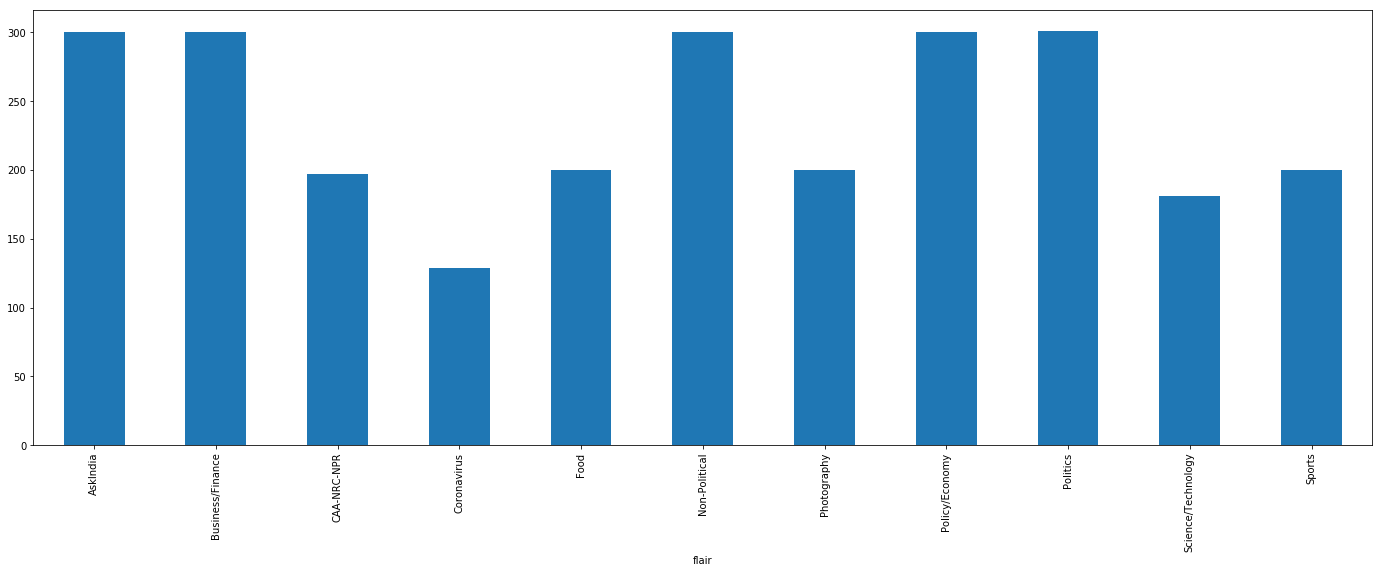

In [221]:
plt.figure(figsize=(24,8))
df.groupby('flair').count()['title'].plot(kind='bar')

In [222]:
df.to_csv('reddit-india-final-dataset.csv', index=False)

We will need to extract more data points to get higher accuracy for the relatively unpopular flairs

In [17]:
df['post_yr']=df['timestamp'].apply(lambda x: int(x[:4]))

title  score     id  \
2436  Crosspost / Dear Photography Reddit, I have a ...     31  9uiza   

                                                    url  comms_num body  \
2436  http://www.vishvish.com/story/tata-chemical-nr...          6  NaN   

            author                                           comments  \
2436  londonskater   Gujarat is slowly becoming an industrial wast...   

                timestamp  numerical_flair        flair  title_length  \
2436  2009-10-16 13:42:07                8  Photography           195   

      comment_length                                     stemmed_titles  \
2436            1285  crosspost dear photograph reddit photo essay u...   

                                          stem_comments stem_body  post_yr  
2436  guj slow becom indust wasteland mr hon cm mod ...       NaN     2009

## Modifying the pushshifts data 

In [22]:
mod_df=pd.read_csv('pushshifts_data_extraction.csv')

In [26]:
mod_df['comments']=mod_df['comments'].apply(lambda x: comment_func(x))

In [27]:
mod_df['comment_length']=mod_df['comments'].apply(len)

In [30]:
global commentno
commentno=0
mod_df['stem_comments']=mod_df['comments'].apply(lambda x: text_process(x))

processing line number 0
processing line number 1
processing line number 2
processing line number 3
processing line number 4
processing line number 5
processing line number 6
processing line number 7
processing line number 8
processing line number 9
processing line number 10
processing line number 11
processing line number 12
processing line number 13
processing line number 14
processing line number 15
processing line number 16
processing line number 17
processing line number 18
processing line number 19
processing line number 20
processing line number 21
processing line number 22
processing line number 23
processing line number 24
processing line number 25
processing line number 26
processing line number 27
processing line number 28
processing line number 29
processing line number 30
processing line number 31
processing line number 32
processing line number 33
processing line number 34
processing line number 35
processing line number 36
processing line number 37
processing line number

processing line number 309
processing line number 310
processing line number 311
processing line number 312
processing line number 313
processing line number 314
processing line number 315
processing line number 316
processing line number 317
processing line number 318
processing line number 319
processing line number 320
processing line number 321
processing line number 322
processing line number 323
processing line number 324
processing line number 325
processing line number 326
processing line number 327
processing line number 328
processing line number 329
processing line number 330
processing line number 331
processing line number 332
processing line number 333
processing line number 334
processing line number 335
processing line number 336
processing line number 337
processing line number 338
processing line number 339
processing line number 340
processing line number 341
processing line number 342
processing line number 343
processing line number 344
processing line number 345
p

processing line number 613
processing line number 614
processing line number 615
processing line number 616
processing line number 617
processing line number 618
processing line number 619
processing line number 620
processing line number 621
processing line number 622
processing line number 623
processing line number 624
processing line number 625
processing line number 626
processing line number 627
processing line number 628
processing line number 629
processing line number 630
processing line number 631
processing line number 632
processing line number 633
processing line number 634
processing line number 635
processing line number 636
processing line number 637
processing line number 638
processing line number 639
processing line number 640
processing line number 641
processing line number 642
processing line number 643
processing line number 644
processing line number 645
processing line number 646
processing line number 647
processing line number 648
processing line number 649
p

processing line number 917
processing line number 918
processing line number 919
processing line number 920
processing line number 921
processing line number 922
processing line number 923
processing line number 924
processing line number 925
processing line number 926
processing line number 927
processing line number 928
processing line number 929
processing line number 930
processing line number 931
processing line number 932
processing line number 933
processing line number 934
processing line number 935
processing line number 936
processing line number 937
processing line number 938
processing line number 939
processing line number 940
processing line number 941
processing line number 942
processing line number 943
processing line number 944
processing line number 945
processing line number 946
processing line number 947
processing line number 948
processing line number 949
processing line number 950
processing line number 951
processing line number 952
processing line number 953
p

processing line number 1214
processing line number 1215
processing line number 1216
processing line number 1217
processing line number 1218
processing line number 1219
processing line number 1220
processing line number 1221
processing line number 1222
processing line number 1223
processing line number 1224
processing line number 1225
processing line number 1226
processing line number 1227
processing line number 1228
processing line number 1229
processing line number 1230
processing line number 1231
processing line number 1232
processing line number 1233
processing line number 1234
processing line number 1235
processing line number 1236
processing line number 1237
processing line number 1238
processing line number 1239
processing line number 1240
processing line number 1241
processing line number 1242
processing line number 1243
processing line number 1244
processing line number 1245
processing line number 1246
processing line number 1247
processing line number 1248
processing line numb

processing line number 1507
processing line number 1508
processing line number 1509
processing line number 1510
processing line number 1511
processing line number 1512
processing line number 1513
processing line number 1514
processing line number 1515
processing line number 1516
processing line number 1517
processing line number 1518
processing line number 1519
processing line number 1520
processing line number 1521
processing line number 1522
processing line number 1523
processing line number 1524
processing line number 1525
processing line number 1526
processing line number 1527
processing line number 1528
processing line number 1529
processing line number 1530
processing line number 1531
processing line number 1532
processing line number 1533
processing line number 1534
processing line number 1535
processing line number 1536
processing line number 1537
processing line number 1538
processing line number 1539
processing line number 1540
processing line number 1541
processing line numb

processing line number 1800
processing line number 1801
processing line number 1802
processing line number 1803
processing line number 1804
processing line number 1805
processing line number 1806
processing line number 1807
processing line number 1808
processing line number 1809
processing line number 1810
processing line number 1811
processing line number 1812
processing line number 1813
processing line number 1814
processing line number 1815
processing line number 1816
processing line number 1817
processing line number 1818
processing line number 1819
processing line number 1820
processing line number 1821
processing line number 1822
processing line number 1823
processing line number 1824
processing line number 1825
processing line number 1826
processing line number 1827
processing line number 1828
processing line number 1829
processing line number 1830
processing line number 1831
processing line number 1832
processing line number 1833
processing line number 1834
processing line numb

processing line number 2094
processing line number 2095
processing line number 2096
processing line number 2097
processing line number 2098
processing line number 2099
processing line number 2100
processing line number 2101
processing line number 2102
processing line number 2103
processing line number 2104
processing line number 2105
processing line number 2106
processing line number 2107
processing line number 2108
processing line number 2109
processing line number 2110
processing line number 2111
processing line number 2112
processing line number 2113
processing line number 2114
processing line number 2115
processing line number 2116
processing line number 2117
processing line number 2118
processing line number 2119
processing line number 2120
processing line number 2121
processing line number 2122
processing line number 2123
processing line number 2124
processing line number 2125
processing line number 2126
processing line number 2127
processing line number 2128
processing line numb

processing line number 2388
processing line number 2389
processing line number 2390
processing line number 2391
processing line number 2392
processing line number 2393
processing line number 2394
processing line number 2395
processing line number 2396
processing line number 2397
processing line number 2398
processing line number 2399
processing line number 2400
processing line number 2401
processing line number 2402
processing line number 2403
processing line number 2404
processing line number 2405
processing line number 2406
processing line number 2407
processing line number 2408
processing line number 2409
processing line number 2410
processing line number 2411
processing line number 2412
processing line number 2413
processing line number 2414
processing line number 2415
processing line number 2416
processing line number 2417
processing line number 2418
processing line number 2419
processing line number 2420
processing line number 2421
processing line number 2422
processing line numb

processing line number 2682
processing line number 2683
processing line number 2684
processing line number 2685
processing line number 2686
processing line number 2687
processing line number 2688
processing line number 2689
processing line number 2690
processing line number 2691
processing line number 2692
processing line number 2693
processing line number 2694
processing line number 2695
processing line number 2696
processing line number 2697
processing line number 2698
processing line number 2699
processing line number 2700
processing line number 2701
processing line number 2702
processing line number 2703
processing line number 2704
processing line number 2705
processing line number 2706
processing line number 2707
processing line number 2708
processing line number 2709
processing line number 2710
processing line number 2711
processing line number 2712
processing line number 2713
processing line number 2714
processing line number 2715
processing line number 2716
processing line numb

processing line number 2975
processing line number 2976
processing line number 2977
processing line number 2978
processing line number 2979
processing line number 2980
processing line number 2981
processing line number 2982
processing line number 2983
processing line number 2984
processing line number 2985
processing line number 2986
processing line number 2987
processing line number 2988
processing line number 2989
processing line number 2990
processing line number 2991
processing line number 2992
processing line number 2993
processing line number 2994
processing line number 2995
processing line number 2996
processing line number 2997
processing line number 2998
processing line number 2999
processing line number 3000
processing line number 3001
processing line number 3002
processing line number 3003
processing line number 3004
processing line number 3005
processing line number 3006
processing line number 3007
processing line number 3008
processing line number 3009
processing line numb

processing line number 3272
processing line number 3273
processing line number 3274
processing line number 3275
processing line number 3276
processing line number 3277
processing line number 3278
processing line number 3279
processing line number 3280
processing line number 3281
processing line number 3282
processing line number 3283
processing line number 3284
processing line number 3285
processing line number 3286
processing line number 3287
processing line number 3288
processing line number 3289
processing line number 3290
processing line number 3291
processing line number 3292
processing line number 3293
processing line number 3294
processing line number 3295
processing line number 3296
processing line number 3297
processing line number 3298
processing line number 3299
processing line number 3300
processing line number 3301
processing line number 3302
processing line number 3303
processing line number 3304
processing line number 3305
processing line number 3306
processing line numb

processing line number 3566
processing line number 3567
processing line number 3568
processing line number 3569
processing line number 3570
processing line number 3571
processing line number 3572
processing line number 3573
processing line number 3574
processing line number 3575
processing line number 3576
processing line number 3577
processing line number 3578
processing line number 3579
processing line number 3580
processing line number 3581
processing line number 3582
processing line number 3583
processing line number 3584
processing line number 3585
processing line number 3586
processing line number 3587
processing line number 3588
processing line number 3589
processing line number 3590
processing line number 3591
processing line number 3592
processing line number 3593
processing line number 3594
processing line number 3595
processing line number 3596
processing line number 3597
processing line number 3598
processing line number 3599
processing line number 3600
processing line numb

processing line number 3859
processing line number 3860
processing line number 3861
processing line number 3862
processing line number 3863
processing line number 3864
processing line number 3865
processing line number 3866
processing line number 3867
processing line number 3868
processing line number 3869
processing line number 3870
processing line number 3871
processing line number 3872
processing line number 3873
processing line number 3874
processing line number 3875
processing line number 3876
processing line number 3877
processing line number 3878
processing line number 3879
processing line number 3880
processing line number 3881
processing line number 3882
processing line number 3883
processing line number 3884
processing line number 3885
processing line number 3886
processing line number 3887
processing line number 3888
processing line number 3889
processing line number 3890
processing line number 3891
processing line number 3892
processing line number 3893
processing line numb

processing line number 4152
processing line number 4153
processing line number 4154
processing line number 4155
processing line number 4156
processing line number 4157
processing line number 4158
processing line number 4159
processing line number 4160
processing line number 4161
processing line number 4162
processing line number 4163
processing line number 4164
processing line number 4165
processing line number 4166
processing line number 4167
processing line number 4168
processing line number 4169
processing line number 4170
processing line number 4171
processing line number 4172
processing line number 4173
processing line number 4174
processing line number 4175
processing line number 4176
processing line number 4177
processing line number 4178
processing line number 4179
processing line number 4180
processing line number 4181
processing line number 4182
processing line number 4183
processing line number 4184
processing line number 4185
processing line number 4186
processing line numb

processing line number 4445
processing line number 4446
processing line number 4447
processing line number 4448
processing line number 4449
processing line number 4450
processing line number 4451
processing line number 4452
processing line number 4453
processing line number 4454
processing line number 4455
processing line number 4456
processing line number 4457
processing line number 4458
processing line number 4459
processing line number 4460
processing line number 4461
processing line number 4462
processing line number 4463
processing line number 4464
processing line number 4465
processing line number 4466
processing line number 4467
processing line number 4468
processing line number 4469
processing line number 4470
processing line number 4471
processing line number 4472
processing line number 4473
processing line number 4474
processing line number 4475
processing line number 4476
processing line number 4477
processing line number 4478
processing line number 4479
processing line numb

processing line number 4738
processing line number 4739
processing line number 4740
processing line number 4741
processing line number 4742
processing line number 4743
processing line number 4744
processing line number 4745
processing line number 4746
processing line number 4747
processing line number 4748
processing line number 4749
processing line number 4750
processing line number 4751
processing line number 4752
processing line number 4753
processing line number 4754
processing line number 4755
processing line number 4756
processing line number 4757
processing line number 4758
processing line number 4759
processing line number 4760
processing line number 4761
processing line number 4762
processing line number 4763
processing line number 4764
processing line number 4765
processing line number 4766
processing line number 4767
processing line number 4768
processing line number 4769
processing line number 4770
processing line number 4771
processing line number 4772
processing line numb

processing line number 5035
processing line number 5036
processing line number 5037
processing line number 5038
processing line number 5039
processing line number 5040
processing line number 5041
processing line number 5042
processing line number 5043
processing line number 5044
processing line number 5045
processing line number 5046
processing line number 5047
processing line number 5048
processing line number 5049
processing line number 5050
processing line number 5051
processing line number 5052
processing line number 5053
processing line number 5054
processing line number 5055
processing line number 5056
processing line number 5057
processing line number 5058
processing line number 5059
processing line number 5060
processing line number 5061
processing line number 5062
processing line number 5063
processing line number 5064
processing line number 5065
processing line number 5066
processing line number 5067
processing line number 5068
processing line number 5069
processing line numb

processing line number 5328
processing line number 5329
processing line number 5330
processing line number 5331
processing line number 5332
processing line number 5333
processing line number 5334
processing line number 5335
processing line number 5336
processing line number 5337
processing line number 5338
processing line number 5339
processing line number 5340
processing line number 5341
processing line number 5342
processing line number 5343
processing line number 5344
processing line number 5345
processing line number 5346
processing line number 5347
processing line number 5348
processing line number 5349
processing line number 5350
processing line number 5351
processing line number 5352
processing line number 5353
processing line number 5354
processing line number 5355
processing line number 5356
processing line number 5357
processing line number 5358
processing line number 5359
processing line number 5360
processing line number 5361
processing line number 5362
processing line numb

processing line number 5622
processing line number 5623
processing line number 5624
processing line number 5625
processing line number 5626
processing line number 5627
processing line number 5628
processing line number 5629
processing line number 5630
processing line number 5631
processing line number 5632
processing line number 5633
processing line number 5634
processing line number 5635
processing line number 5636
processing line number 5637
processing line number 5638
processing line number 5639
processing line number 5640
processing line number 5641
processing line number 5642
processing line number 5643
processing line number 5644
processing line number 5645
processing line number 5646
processing line number 5647
processing line number 5648
processing line number 5649
processing line number 5650
processing line number 5651
processing line number 5652
processing line number 5653
processing line number 5654
processing line number 5655
processing line number 5656
processing line numb

processing line number 5915
processing line number 5916
processing line number 5917
processing line number 5918
processing line number 5919
processing line number 5920
processing line number 5921
processing line number 5922
processing line number 5923
processing line number 5924
processing line number 5925
processing line number 5926
processing line number 5927
processing line number 5928
processing line number 5929
processing line number 5930
processing line number 5931
processing line number 5932
processing line number 5933
processing line number 5934
processing line number 5935
processing line number 5936
processing line number 5937
processing line number 5938
processing line number 5939
processing line number 5940
processing line number 5941
processing line number 5942
processing line number 5943
processing line number 5944
processing line number 5945
processing line number 5946
processing line number 5947
processing line number 5948
processing line number 5949
processing line numb

processing line number 6208
processing line number 6209
processing line number 6210
processing line number 6211
processing line number 6212
processing line number 6213
processing line number 6214
processing line number 6215
processing line number 6216
processing line number 6217
processing line number 6218
processing line number 6219
processing line number 6220
processing line number 6221
processing line number 6222
processing line number 6223
processing line number 6224
processing line number 6225
processing line number 6226
processing line number 6227
processing line number 6228
processing line number 6229
processing line number 6230
processing line number 6231
processing line number 6232
processing line number 6233
processing line number 6234
processing line number 6235
processing line number 6236
processing line number 6237
processing line number 6238
processing line number 6239
processing line number 6240
processing line number 6241
processing line number 6242
processing line numb

processing line number 6502
processing line number 6503
processing line number 6504
processing line number 6505
processing line number 6506
processing line number 6507
processing line number 6508
processing line number 6509
processing line number 6510
processing line number 6511
processing line number 6512
processing line number 6513
processing line number 6514
processing line number 6515
processing line number 6516
processing line number 6517
processing line number 6518
processing line number 6519
processing line number 6520
processing line number 6521
processing line number 6522
processing line number 6523
processing line number 6524
processing line number 6525
processing line number 6526
processing line number 6527
processing line number 6528
processing line number 6529
processing line number 6530
processing line number 6531
processing line number 6532
processing line number 6533
processing line number 6534
processing line number 6535
processing line number 6536
processing line numb

processing line number 6798
processing line number 6799
processing line number 6800
processing line number 6801
processing line number 6802
processing line number 6803
processing line number 6804
processing line number 6805
processing line number 6806
processing line number 6807
processing line number 6808
processing line number 6809
processing line number 6810
processing line number 6811
processing line number 6812
processing line number 6813
processing line number 6814
processing line number 6815
processing line number 6816
processing line number 6817
processing line number 6818
processing line number 6819
processing line number 6820
processing line number 6821
processing line number 6822
processing line number 6823
processing line number 6824
processing line number 6825
processing line number 6826
processing line number 6827
processing line number 6828


In [4]:
global commentno
commentno=0
mod_df['stemmed_titles']=mod_df['title'].apply(lambda x:text_process(x))

In [33]:
mod_df['title_length']=mod_df['title'].apply(len)

In [36]:
flairs=["Politics","Non-Political","AskIndia","Policy/Economy",'Business/Finance','Science/Technology','Sports','Food',
       'Photography','CAA-NRC-NPR','Coronavirus',"[R]ediquette"] #as per the latest flair list from Reddit mobile app
mod_df['numerical_flair']=mod_df['flair'].apply(lambda x: flairs.index(x))

In [39]:
mod_df.to_csv('pushshifts_data_extraction.csv',index=False)

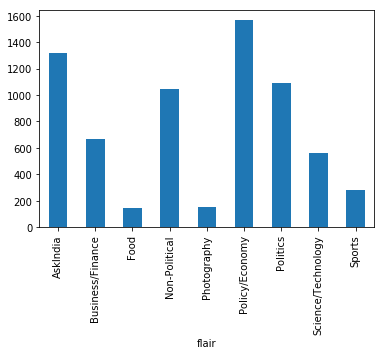

In [40]:
mod_df.groupby('flair').count()['title'].plot(kind='bar')

## URL Processing

In [69]:
def url_process(words):
    words=str(words)
    global commentno
    print("processing url number",commentno)
    commentno+=1
    if(len(words)==0):
        return [word for word in "No Body"]
    words= BeautifulSoup(words, "lxml").text
    words=words.lower()
    nopunc=[]
    for char in words:
        if char in string.punctuation:
            nopunc.append(" ")
        else:
            if(char.isdigit()==False):
                nopunc.append(char)
    nopunc=''.join(nopunc)
    stop_words=stopwords.words('english')
    stop_words.append('comments')
    stop_words.append('reddit')
    stop_words.append('https')
    stop_words.append('r')
    stop_words.append('www')
    wordlist= [word for word in nopunc.split() if word.lower() not in stop_words]
    wordlist=' '.join(wordlist)
    return wordlist

In [40]:
strip_data=pd.read_csv('stripped_data.csv')

In [70]:
strip_data['url'].iloc[129]

'https://www.reddit.com/r/india/comments/b8ubm2/til_about_the_practice_of_deploying_dummy/'

In [5]:
strip_data['processed_url']=strip_data['url'].apply(lambda x: url_process(x))

In [49]:
strip_data.to_csv('stripped_data.csv',index=False)

In [3]:
combined_data=pd.read_csv('combined_df.csv')

In [51]:
combined_data['processed_url']=combined_data['url'].apply(lambda x: url_process(x))

processing url number 25756
processing url number 25757
processing url number 25758
processing url number 25759
processing url number 25760
processing url number 25761
processing url number 25762
processing url number 25763
processing url number 25764
processing url number 25765
processing url number 25766
processing url number 25767
processing url number 25768
processing url number 25769
processing url number 25770
processing url number 25771
processing url number 25772
processing url number 25773
processing url number 25774
processing url number 25775
processing url number 25776
processing url number 25777
processing url number 25778
processing url number 25779
processing url number 25780
processing url number 25781
processing url number 25782
processing url number 25783
processing url number 25784
processing url number 25785
processing url number 25786
processing url number 25787
processing url number 25788
processing url number 25789
processing url number 25790
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/futac9/pitting_a_community_against_a_political_party_is/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/futac9/pitting_a_community_against_a_political_party_is/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://theprint.in/india/hit-by-backlash-over-posts-on-lack-of-medical-gear-doctors-g

processing url number 25842
processing url number 25843
processing url number 25844
processing url number 25845
processing url number 25846
processing url number 25847
processing url number 25848
processing url number 25849
processing url number 25850
processing url number 25851
processing url number 25852
processing url number 25853
processing url number 25854
processing url number 25855
processing url number 25856
processing url number 25857
processing url number 25858
processing url number 25859
processing url number 25860
processing url number 25861
processing url number 25862
processing url number 25863
processing url number 25864
processing url number 25865
processing url number 25866
processing url number 25867
processing url number 25868
processing url number 25869
processing url number 25870
processing url number 25871
processing url number 25872
processing url number 25873
processing url number 25874
processing url number 25875
processing url number 25876
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.deccanherald.com/opinion/pm-narendra-modi-is-losing-his-political-mojo-793980.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.freepressjournal.in/india/we-serve-the-country-not-the-political-forces-former-navy-chief-l-ramdas-slams-army-chief-gen-bipin-rawat" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/f

processing url number 25921
processing url number 25922
processing url number 25923
processing url number 25924
processing url number 25925
processing url number 25926
processing url number 25927
processing url number 25928
processing url number 25929
processing url number 25930
processing url number 25931
processing url number 25932
processing url number 25933
processing url number 25934
processing url number 25935
processing url number 25936
processing url number 25937
processing url number 25938
processing url number 25939
processing url number 25940
processing url number 25941
processing url number 25942
processing url number 25943
processing url number 25944
processing url number 25945
processing url number 25946
processing url number 25947
processing url number 25948
processing url number 25949
processing url number 25950
processing url number 25951
processing url number 25952
processing url number 25953
processing url number 25954
processing url number 25955
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/6p741j/can_i_carry_electric_guitar_as_a_cabin_luggage_in/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://gfycat.com/gifs/detail/AncientCoarseFairyfly" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/339yw8/i_think_we_should_come_up_with_a_way_to_make/" looks like a URL. Beautiful Soup is

processing url number 25984
processing url number 25985
processing url number 25986
processing url number 25987
processing url number 25988
processing url number 25989
processing url number 25990
processing url number 25991
processing url number 25992
processing url number 25993
processing url number 25994
processing url number 25995
processing url number 25996
processing url number 25997
processing url number 25998
processing url number 25999
processing url number 26000
processing url number 26001
processing url number 26002
processing url number 26003
processing url number 26004
processing url number 26005
processing url number 26006
processing url number 26007
processing url number 26008
processing url number 26009
processing url number 26010
processing url number 26011
processing url number 26012
processing url number 26013
processing url number 26014
processing url number 26015
processing url number 26016
processing url number 26017
processing url number 26018
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fk25rj/askindia_why_has_the_government_not_put_all_emi/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fr7h2i/askindia_what_percentage_of_people_walking_200/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fcqkj2/askindia_are_daughters_entitled_to_their_d

processing url number 26042
processing url number 26043
processing url number 26044
processing url number 26045
processing url number 26046
processing url number 26047
processing url number 26048
processing url number 26049
processing url number 26050
processing url number 26051
processing url number 26052
processing url number 26053
processing url number 26054
processing url number 26055
processing url number 26056
processing url number 26057
processing url number 26058
processing url number 26059
processing url number 26060
processing url number 26061
processing url number 26062
processing url number 26063
processing url number 26064
processing url number 26065
processing url number 26066
processing url number 26067
processing url number 26068
processing url number 26069
processing url number 26070
processing url number 26071
processing url number 26072
processing url number 26073
processing url number 26074
processing url number 26075
processing url number 26076
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fiolca/oil_slump_india_will_rather_play_dumb_by_raising/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fpx36l/a_thread_on_how_this_regime_with_its_marvellous/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/f15kgm/opinion_bjps_policies_have_alienated_a_l

processing url number 26109
processing url number 26110
processing url number 26111
processing url number 26112
processing url number 26113
processing url number 26114
processing url number 26115
processing url number 26116
processing url number 26117
processing url number 26118
processing url number 26119
processing url number 26120
processing url number 26121
processing url number 26122
processing url number 26123
processing url number 26124
processing url number 26125
processing url number 26126
processing url number 26127
processing url number 26128
processing url number 26129
processing url number 26130
processing url number 26131
processing url number 26132
processing url number 26133
processing url number 26134
processing url number 26135
processing url number 26136
processing url number 26137
processing url number 26138
processing url number 26139
processing url number 26140
processing url number 26141
processing url number 26142
processing url number 26143
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.ndtv.com/video/player/walk-the-talk/walk-the-talk-with-arvind-panagariya/284689" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/di5x69/askindia_why_do_we_have_so_much_distrust_of/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/d76uvt/economic_shit_storm_incoming_brace_for_impact/" lo

processing url number 26172
processing url number 26173
processing url number 26174
processing url number 26175
processing url number 26176
processing url number 26177
processing url number 26178
processing url number 26179
processing url number 26180
processing url number 26181
processing url number 26182
processing url number 26183
processing url number 26184
processing url number 26185
processing url number 26186
processing url number 26187
processing url number 26188
processing url number 26189
processing url number 26190
processing url number 26191
processing url number 26192
processing url number 26193
processing url number 26194
processing url number 26195
processing url number 26196
processing url number 26197
processing url number 26198
processing url number 26199
processing url number 26200
processing url number 26201
processing url number 26202
processing url number 26203
processing url number 26204
processing url number 26205
processing url number 26206
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/abqu80/what_would_be_a_better_decision_serious/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/ahuc0c/please_help_me_with_career_advice/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/al2pdh/broke_up_30_what_next/" looks like a URL. Beautiful Soup is not

26225
processing url number 26226
processing url number 26227
processing url number 26228
processing url number 26229
processing url number 26230
processing url number 26231
processing url number 26232
processing url number 26233
processing url number 26234
processing url number 26235
processing url number 26236
processing url number 26237
processing url number 26238
processing url number 26239
processing url number 26240
processing url number 26241
processing url number 26242
processing url number 26243
processing url number 26244
processing url number 26245
processing url number 26246
processing url number 26247
processing url number 26248
processing url number 26249
processing url number 26250
processing url number 26251
processing url number 26252
processing url number 26253
processing url number 26254
processing url number 26255
processing url number 26256
processing url number 26257
processing url number 26258
processing url number 26259
processing url number 26260
processing url

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/4n1vdhy95z341.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/f9outu/fuck_all_religion/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.rt.com/news/482802-bjp-chief-ritual-coronavirus/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get 

processing url number 26290
processing url number 26291
processing url number 26292
processing url number 26293
processing url number 26294
processing url number 26295
processing url number 26296
processing url number 26297
processing url number 26298
processing url number 26299
processing url number 26300
processing url number 26301
processing url number 26302
processing url number 26303
processing url number 26304
processing url number 26305
processing url number 26306
processing url number 26307
processing url number 26308
processing url number 26309
processing url number 26310
processing url number 26311
processing url number 26312
processing url number 26313
processing url number 26314
processing url number 26315
processing url number 26316
processing url number 26317
processing url number 26318
processing url number 26319
processing url number 26320
processing url number 26321
processing url number 26322
processing url number 26323
processing url number 26324
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thepolisproject.com/violence-after-violence-the-politics-of-narratives-over-the-delhi-pogrom/#.XoDEAeVX5kx" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.washingtonpost.com/opinions/2020/02/25/indias-politics-hate-have-erupted-all-world-witness/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thenewsminute.com/article/politics-or-busines

processing url number 26367
processing url number 26368
processing url number 26369
processing url number 26370
processing url number 26371
processing url number 26372
processing url number 26373
processing url number 26374
processing url number 26375
processing url number 26376
processing url number 26377
processing url number 26378
processing url number 26379
processing url number 26380
processing url number 26381
processing url number 26382
processing url number 26383
processing url number 26384
processing url number 26385
processing url number 26386
processing url number 26387
processing url number 26388
processing url number 26389
processing url number 26390
processing url number 26391
processing url number 26392
processing url number 26393
processing url number 26394
processing url number 26395
processing url number 26396
processing url number 26397
processing url number 26398
processing url number 26399
processing url number 26400
processing url number 26401
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/fe2ukxh582431.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/bea1vb/setting_example_for_nonpolitical_affluent_public/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/oJ3ISyd" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the 

processing url number 26425
processing url number 26426
processing url number 26427
processing url number 26428
processing url number 26429
processing url number 26430
processing url number 26431
processing url number 26432
processing url number 26433
processing url number 26434
processing url number 26435
processing url number 26436
processing url number 26437
processing url number 26438
processing url number 26439
processing url number 26440
processing url number 26441
processing url number 26442
processing url number 26443
processing url number 26444
processing url number 26445
processing url number 26446
processing url number 26447
processing url number 26448
processing url number 26449
processing url number 26450
processing url number 26451
processing url number 26452
processing url number 26453
processing url number 26454
processing url number 26455
processing url number 26456
processing url number 26457
processing url number 26458
processing url number 26459
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/bdfid1/ambassador_of_india_takes_back_my_newly_issued/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/cu1xn4/randians_what_are_you_too_afraid_to_ask/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/dfljx0/toothpaste_alternative/" looks like a URL. Beautif

processing url number 26481
processing url number 26482
processing url number 26483
processing url number 26484
processing url number 26485
processing url number 26486
processing url number 26487
processing url number 26488
processing url number 26489
processing url number 26490
processing url number 26491
processing url number 26492
processing url number 26493
processing url number 26494
processing url number 26495
processing url number 26496
processing url number 26497
processing url number 26498
processing url number 26499
processing url number 26500
processing url number 26501
processing url number 26502
processing url number 26503
processing url number 26504
processing url number 26505
processing url number 26506
processing url number 26507
processing url number 26508
processing url number 26509
processing url number 26510
processing url number 26511
processing url number 26512
processing url number 26513
processing url number 26514
processing url number 26515
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fpdkd0/askindiajust_a_throwaway_account_i_need_some/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/e3ond3/what_steps_women_can_take_for_their_safety/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fat1mi/askindiaare_colours_used_in_holi_still_getting/" 

processing url number 26533
processing url number 26534
processing url number 26535
processing url number 26536
processing url number 26537
processing url number 26538
processing url number 26539
processing url number 26540
processing url number 26541
processing url number 26542
processing url number 26543
processing url number 26544
processing url number 26545
processing url number 26546
processing url number 26547
processing url number 26548
processing url number 26549
processing url number 26550
processing url number 26551
processing url number 26552
processing url number 26553
processing url number 26554
processing url number 26555
processing url number 26556
processing url number 26557
processing url number 26558
processing url number 26559
processing url number 26560
processing url number 26561
processing url number 26562
processing url number 26563
processing url number 26564
processing url number 26565
processing url number 26566
processing url number 26567
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://sputniknews.com/business/201912021077462891-believe-it-pakistan-more-attractive-destination-for-global-investors-than-india-says-moodys/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/dooafc/delhi_government_today_raised_the_minimum_wage_to/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/commen

processing url number 26584
processing url number 26585
processing url number 26586
processing url number 26587
processing url number 26588
processing url number 26589
processing url number 26590
processing url number 26591
processing url number 26592
processing url number 26593
processing url number 26594
processing url number 26595
processing url number 26596
processing url number 26597
processing url number 26598
processing url number 26599
processing url number 26600
processing url number 26601
processing url number 26602
processing url number 26603
processing url number 26604
processing url number 26605
processing url number 26606
processing url number 26607
processing url number 26608
processing url number 26609
processing url number 26610
processing url number 26611
processing url number 26612
processing url number 26613
processing url number 26614
processing url number 26615
processing url number 26616
processing url number 26617
processing url number 26618
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://economictimes.indiatimes.com/news/economy/policy/rbis-deputy-governor-viral-acharya-quits-six-months-before-his-term-ends/articleshow/69920503.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/e5d76w/real_talk_indias_economic_future_is_screwed_and/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/indi

 26621
processing url number 26622
processing url number 26623
processing url number 26624
processing url number 26625
processing url number 26626
processing url number 26627
processing url number 26628
processing url number 26629
processing url number 26630
processing url number 26631
processing url number 26632
processing url number 26633
processing url number 26634
processing url number 26635
processing url number 26636
processing url number 26637
processing url number 26638
processing url number 26639
processing url number 26640
processing url number 26641
processing url number 26642
processing url number 26643
processing url number 26644
processing url number 26645
processing url number 26646
processing url number 26647
processing url number 26648
processing url number 26649
processing url number 26650
processing url number 26651
processing url number 26652
processing url number 26653
processing url number 26654
processing url number 26655
processing url number 26656
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/f9to6w/daily_current_affairs/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fmob0d/what_the_fuck_is_modi_doing/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/dnohi0/diwali_2019_mark_my_word_thread_and_link_to/" looks like a URL. Beautiful Soup is not a

processing url number 26678
processing url number 26679
processing url number 26680
processing url number 26681
processing url number 26682
processing url number 26683
processing url number 26684
processing url number 26685
processing url number 26686
processing url number 26687
processing url number 26688
processing url number 26689
processing url number 26690
processing url number 26691
processing url number 26692
processing url number 26693
processing url number 26694
processing url number 26695
processing url number 26696
processing url number 26697
processing url number 26698
processing url number 26699
processing url number 26700
processing url number 26701
processing url number 26702
processing url number 26703
processing url number 26704
processing url number 26705
processing url number 26706
processing url number 26707
processing url number 26708
processing url number 26709
processing url number 26710
processing url number 26711
processing url number 26712
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://timesofindia.indiatimes.com/business/india-business/even-tax-officers-left-foxed-by-gst-form/articleshow/61569304.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/alx3kj/with_the_recent_oxfam_india_inequality_report/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/abssno/folks_do_you_

processing url number 26741
processing url number 26742
processing url number 26743
processing url number 26744
processing url number 26745
processing url number 26746
processing url number 26747
processing url number 26748
processing url number 26749
processing url number 26750
processing url number 26751
processing url number 26752
processing url number 26753
processing url number 26754
processing url number 26755
processing url number 26756
processing url number 26757
processing url number 26758
processing url number 26759
processing url number 26760
processing url number 26761
processing url number 26762
processing url number 26763
processing url number 26764
processing url number 26765
processing url number 26766
processing url number 26767
processing url number 26768
processing url number 26769
processing url number 26770
processing url number 26771
processing url number 26772
processing url number 26773
processing url number 26774
processing url number 26775
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://theprint.in/opinion/pov/talking-to-cab-drivers-about-politics-is-the-oldest-cliche-now-uber-is-no-more-a-safe-space/361328/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fge15y/today_congress_has_been_greatly_weakened_or/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.thehindu.com/news/national/other-states/benga

processing url number 26798
processing url number 26799
processing url number 26800
processing url number 26801
processing url number 26802
processing url number 26803
processing url number 26804
processing url number 26805
processing url number 26806
processing url number 26807
processing url number 26808
processing url number 26809
processing url number 26810
processing url number 26811
processing url number 26812
processing url number 26813
processing url number 26814
processing url number 26815
processing url number 26816
processing url number 26817
processing url number 26818
processing url number 26819
processing url number 26820
processing url number 26821
processing url number 26822
processing url number 26823
processing url number 26824
processing url number 26825
processing url number 26826
processing url number 26827
processing url number 26828
processing url number 26829
processing url number 26830
processing url number 26831
processing url number 26832
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/f8842p/suggestions_for_neutral_books_on_middle_east_geo/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://theprint.in/politics/coronavirus-has-increased-political-distancing-between-rahul-gandhi-and-congress-old-guard/389976/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.deccanherald.com/opinion/pm-narendra-modi-i

processing url number 26863
processing url number 26864
processing url number 26865
processing url number 26866
processing url number 26867
processing url number 26868
processing url number 26869
processing url number 26870
processing url number 26871
processing url number 26872
processing url number 26873
processing url number 26874
processing url number 26875
processing url number 26876
processing url number 26877
processing url number 26878
processing url number 26879
processing url number 26880
processing url number 26881
processing url number 26882
processing url number 26883
processing url number 26884
processing url number 26885
processing url number 26886
processing url number 26887
processing url number 26888
processing url number 26889
processing url number 26890
processing url number 26891
processing url number 26892
processing url number 26893
processing url number 26894
processing url number 26895
processing url number 26896
processing url number 26897
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/4zkbjx/text_non_political_i_was_on_verge_of_quitting_my/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7hb8q4/nonpolitical_indian_weddingrelationship_traditions/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://i.imgur.com/jWiRHiW.jpg" looks like a URL. Beautiful Soup is not an HTTP clie

processing url number 26919
processing url number 26920
processing url number 26921
processing url number 26922
processing url number 26923
processing url number 26924
processing url number 26925
processing url number 26926
processing url number 26927
processing url number 26928
processing url number 26929
processing url number 26930
processing url number 26931
processing url number 26932
processing url number 26933
processing url number 26934
processing url number 26935
processing url number 26936
processing url number 26937
processing url number 26938
processing url number 26939
processing url number 26940
processing url number 26941
processing url number 26942
processing url number 26943
processing url number 26944
processing url number 26945
processing url number 26946
processing url number 26947
processing url number 26948
processing url number 26949
processing url number 26950
processing url number 26951
processing url number 26952
processing url number 26953
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/3eesdr/any_complications_in_future_jobs_because_of/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/3wcid0/bill_gates_thoughts_on_climate_change_and_indias/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/1kqjhq/subreddit_of_the_day_ask_india/" looks like 

26971
processing url number 26972
processing url number 26973
processing url number 26974
processing url number 26975
processing url number 26976
processing url number 26977
processing url number 26978
processing url number 26979
processing url number 26980
processing url number 26981
processing url number 26982
processing url number 26983
processing url number 26984
processing url number 26985
processing url number 26986
processing url number 26987
processing url number 26988
processing url number 26989
processing url number 26990
processing url number 26991
processing url number 26992
processing url number 26993
processing url number 26994
processing url number 26995
processing url number 26996
processing url number 26997
processing url number 26998
processing url number 26999
processing url number 27000
processing url number 27001
processing url number 27002
processing url number 27003
processing url number 27004
processing url number 27005
processing url number 27006
processing url

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/eoolsk/askindia_i_have_to_book_10_domestic_flights/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/egtg1j/askindia_indigo_cancelled_flight_less_than_8_hour/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/evk7vi/askindia_food_need_indian_food_tracking_app

processing url number 27022
processing url number 27023
processing url number 27024
processing url number 27025
processing url number 27026
processing url number 27027
processing url number 27028
processing url number 27029
processing url number 27030
processing url number 27031
processing url number 27032
processing url number 27033
processing url number 27034
processing url number 27035
processing url number 27036
processing url number 27037
processing url number 27038
processing url number 27039
processing url number 27040
processing url number 27041
processing url number 27042
processing url number 27043
processing url number 27044
processing url number 27045
processing url number 27046
processing url number 27047
processing url number 27048
processing url number 27049
processing url number 27050
processing url number 27051
processing url number 27052
processing url number 27053
processing url number 27054
processing url number 27055
processing url number 27056
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.outlookindia.com/magazine/story/business-news-thats-all-folks/302551" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/f3t8ip/how_i_see_the_pulwama_attacks_abridged/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/f6p5km/possible_outcomes_once_caanpr_are_implemented/" looks like a URL.

processing url number 27079
processing url number 27080
processing url number 27081
processing url number 27082
processing url number 27083
processing url number 27084
processing url number 27085
processing url number 27086
processing url number 27087
processing url number 27088
processing url number 27089
processing url number 27090
processing url number 27091
processing url number 27092
processing url number 27093
processing url number 27094
processing url number 27095
processing url number 27096
processing url number 27097
processing url number 27098
processing url number 27099
processing url number 27100
processing url number 27101
processing url number 27102
processing url number 27103
processing url number 27104
processing url number 27105
processing url number 27106
processing url number 27107
processing url number 27108
processing url number 27109
processing url number 27110
processing url number 27111
processing url number 27112
processing url number 27113
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://economictimes.indiatimes.com/markets/stocks/news/sebi-finalises-norms-for-listing-of-green-bonds/articleshow/58444005.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/d931fb/india_is_not_as_people_keep_calling_it_an/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/3l4x43/just_wondering

processing url number 27137
processing url number 27138
processing url number 27139
processing url number 27140
processing url number 27141
processing url number 27142
processing url number 27143
processing url number 27144
processing url number 27145
processing url number 27146
processing url number 27147
processing url number 27148
processing url number 27149
processing url number 27150
processing url number 27151
processing url number 27152
processing url number 27153
processing url number 27154
processing url number 27155
processing url number 27156
processing url number 27157
processing url number 27158
processing url number 27159
processing url number 27160
processing url number 27161
processing url number 27162
processing url number 27163
processing url number 27164
processing url number 27165
processing url number 27166
processing url number 27167
processing url number 27168
processing url number 27169
processing url number 27170
processing url number 27171
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/bast01/i_would_like_to_sell_doctors_medical_practice/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/bae4z3/a_nonpartisan_list_covering_100_landmark_events/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/bkceku/does_anyone_use_justdial/" looks like a URL

 27178
processing url number 27179
processing url number 27180
processing url number 27181
processing url number 27182
processing url number 27183
processing url number 27184
processing url number 27185
processing url number 27186
processing url number 27187
processing url number 27188
processing url number 27189
processing url number 27190
processing url number 27191
processing url number 27192
processing url number 27193
processing url number 27194
processing url number 27195
processing url number 27196
processing url number 27197
processing url number 27198
processing url number 27199
processing url number 27200
processing url number 27201
processing url number 27202
processing url number 27203
processing url number 27204
processing url number 27205
processing url number 27206
processing url number 27207
processing url number 27208
processing url number 27209
processing url number 27210
processing url number 27211
processing url number 27212
processing url number 27213
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/237msh/please_keep_it_clean/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/13ehd8/please_consider_buying_our_book_india_2020_exodus/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/23c8xq/mobile_harvest_in_india/" looks like a URL. Beautiful Soup is not 

27222
processing url number 27223
processing url number 27224
processing url number 27225
processing url number 27226
processing url number 27227
processing url number 27228
processing url number 27229
processing url number 27230
processing url number 27231
processing url number 27232
processing url number 27233
processing url number 27234
processing url number 27235
processing url number 27236
processing url number 27237
processing url number 27238
processing url number 27239
processing url number 27240
processing url number 27241
processing url number 27242
processing url number 27243
processing url number 27244
processing url number 27245
processing url number 27246
processing url number 27247
processing url number 27248
processing url number 27249
processing url number 27250
processing url number 27251
processing url number 27252
processing url number 27253
processing url number 27254
processing url number 27255
processing url number 27256
processing url number 27257
processing url

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://nptel.iitm.ac.in/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thehindu.com/sci-tech/science/iisc-team-submits-more-evidence-of-superconductivity/article27673454.ece" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://newshunt.com/share/31536909" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requ


processing url number 27275
processing url number 27276
processing url number 27277
processing url number 27278
processing url number 27279
processing url number 27280
processing url number 27281
processing url number 27282
processing url number 27283
processing url number 27284
processing url number 27285
processing url number 27286
processing url number 27287
processing url number 27288
processing url number 27289
processing url number 27290
processing url number 27291
processing url number 27292
processing url number 27293
processing url number 27294
processing url number 27295
processing url number 27296
processing url number 27297
processing url number 27298
processing url number 27299
processing url number 27300
processing url number 27301
processing url number 27302
processing url number 27303
processing url number 27304
processing url number 27305
processing url number 27306
processing url number 27307
processing url number 27308
processing url number 27309
processing url numb

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.newindianexpress.com/entertainment/hindi/2019/oct/29/islam-not-so-weak-shabana-azmi-defends-shah-rukh-khan-for-sporting-tilak-2054205.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/em3eic/what_are_your_thoughts_on_kiren_rijijus_work_so/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.firstpost.com/tech/aut

 27331
processing url number 27332
processing url number 27333
processing url number 27334
processing url number 27335
processing url number 27336
processing url number 27337
processing url number 27338
processing url number 27339
processing url number 27340
processing url number 27341
processing url number 27342
processing url number 27343
processing url number 27344
processing url number 27345
processing url number 27346
processing url number 27347
processing url number 27348
processing url number 27349
processing url number 27350
processing url number 27351
processing url number 27352
processing url number 27353
processing url number 27354
processing url number 27355
processing url number 27356
processing url number 27357
processing url number 27358
processing url number 27359
processing url number 27360
processing url number 27361
processing url number 27362
processing url number 27363
processing url number 27364
processing url number 27365
processing url number 27366
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/zO4AJUT.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fm9kmq/covid19_information/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/b7nm43/star_sports_broadcasting_ipl_on_all_their/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP c

 27382
processing url number 27383
processing url number 27384
processing url number 27385
processing url number 27386
processing url number 27387
processing url number 27388
processing url number 27389
processing url number 27390
processing url number 27391
processing url number 27392
processing url number 27393
processing url number 27394
processing url number 27395
processing url number 27396
processing url number 27397
processing url number 27398
processing url number 27399
processing url number 27400
processing url number 27401
processing url number 27402
processing url number 27403
processing url number 27404
processing url number 27405
processing url number 27406
processing url number 27407
processing url number 27408
processing url number 27409
processing url number 27410
processing url number 27411
processing url number 27412
processing url number 27413
processing url number 27414
processing url number 27415
processing url number 27416
processing url number 27417
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/rqt8n5khh3n41.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fszdnk/is_there_an_equivalent_to_ayurvedas_concept_of/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fo2b60/food_share_some_cooking_tips_to_survive_lockdown/" looks like a URL. Beautiful Soup is not an HTTP cli

processing url number 27446
processing url number 27447
processing url number 27448
processing url number 27449
processing url number 27450
processing url number 27451
processing url number 27452
processing url number 27453
processing url number 27454
processing url number 27455
processing url number 27456
processing url number 27457
processing url number 27458
processing url number 27459
processing url number 27460
processing url number 27461
processing url number 27462
processing url number 27463
processing url number 27464
processing url number 27465
processing url number 27466
processing url number 27467
processing url number 27468
processing url number 27469
processing url number 27470
processing url number 27471
processing url number 27472
processing url number 27473
processing url number 27474
processing url number 27475
processing url number 27476
processing url number 27477
processing url number 27478
processing url number 27479
processing url number 27480
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/et4tez/randians_who_cant_tolerate_spicy_food_how_do_you/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fuwon2/what_has_been_you_worst_foodmeal_experience_when/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fos0dk/call_for_donations_prayas_iiser_bhopal_

processing url number 27510
processing url number 27511
processing url number 27512
processing url number 27513
processing url number 27514
processing url number 27515
processing url number 27516
processing url number 27517
processing url number 27518
processing url number 27519
processing url number 27520
processing url number 27521
processing url number 27522
processing url number 27523
processing url number 27524
processing url number 27525
processing url number 27526
processing url number 27527
processing url number 27528
processing url number 27529
processing url number 27530
processing url number 27531
processing url number 27532
processing url number 27533
processing url number 27534
processing url number 27535
processing url number 27536
processing url number 27537
processing url number 27538
processing url number 27539
processing url number 27540
processing url number 27541
processing url number 27542
processing url number 27543
processing url number 27544
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/dnwz2t/we_have_new_rindia_specific_community_awards/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/e3dr2x/backpacking_india_advice/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/9sj276vxnwt21.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably u

 27566
processing url number 27567
processing url number 27568
processing url number 27569
processing url number 27570
processing url number 27571
processing url number 27572
processing url number 27573
processing url number 27574
processing url number 27575
processing url number 27576
processing url number 27577
processing url number 27578
processing url number 27579
processing url number 27580
processing url number 27581
processing url number 27582
processing url number 27583
processing url number 27584
processing url number 27585
processing url number 27586
processing url number 27587
processing url number 27588
processing url number 27589
processing url number 27590
processing url number 27591
processing url number 27592
processing url number 27593
processing url number 27594
processing url number 27595
processing url number 27596
processing url number 27597
processing url number 27598
processing url number 27599
processing url number 27600
processing url number 27601
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://amp.scroll.in/latest/949356/over-100-retired-bureaucrats-write-open-letter-to-indians-say-country-doesnt-need-caa-nrc-or-npr?__twitter_impression=true" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.news18.com/news/politics/congress-will-not-implement-caa-npr-nrc-in-present-forms-in-delhi-if-voted-to-power-chopra-2446603.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py

processing url number 27637
processing url number 27638
processing url number 27639
processing url number 27640
processing url number 27641
processing url number 27642
processing url number 27643
processing url number 27644
processing url number 27645
processing url number 27646
processing url number 27647
processing url number 27648
processing url number 27649
processing url number 27650
processing url number 27651
processing url number 27652
processing url number 27653
processing url number 27654
processing url number 27655
processing url number 27656
processing url number 27657
processing url number 27658
processing url number 27659
processing url number 27660
processing url number 27661
processing url number 27662
processing url number 27663
processing url number 27664
processing url number 27665
processing url number 27666
processing url number 27667
processing url number 27668
processing url number 27669
processing url number 27670
processing url number 27671
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.bbc.com/news/world-asia-india-52176564?SThisFB&fbclid=IwAR1vbkRZLVTF8OP6Enux_FtBOBP-yEkHrH527JpoW6hF6H-PAYeiPl7oONE" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.deccanherald.com/national/north-and-central/ladakh-shows-how-to-deal-with-coronavirus-pandemic-821272.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://scroll.in/article/958397/

27696
processing url number 27697
processing url number 27698
processing url number 27699
processing url number 27700
processing url number 27701
processing url number 27702
processing url number 27703
processing url number 27704
processing url number 27705
processing url number 27706
processing url number 27707
processing url number 27708
processing url number 27709
processing url number 27710
processing url number 27711
processing url number 27712
processing url number 27713
processing url number 27714
processing url number 27715
processing url number 27716
processing url number 27717
processing url number 27718
processing url number 27719
processing url number 27720
processing url number 27721
processing url number 27722
processing url number 27723
processing url number 27724
processing url number 27725
processing url number 27726
processing url number 27727
processing url number 27728
processing url number 27729
processing url number 27730
processing url number 27731
processing url

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://m.rediff.com/business/interview/coronavirus-why-is-the-government-so-stingy/20200404.htm" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.youtube.com/watch?v=WkHg7BdCF8s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fuwpea/coronavirus_heres_how_india_is_planning_to_unwind/" looks like a URL. Beautiful Soup is not 

processing url number 27759
processing url number 27760
processing url number 27761
processing url number 27762
processing url number 27763
processing url number 27764
processing url number 27765
processing url number 27766
processing url number 27767
processing url number 27768
processing url number 27769
processing url number 27770
processing url number 27771
processing url number 27772
processing url number 27773
processing url number 27774
processing url number 27775
processing url number 27776
processing url number 27777
processing url number 27778
processing url number 27779
processing url number 27780
processing url number 27781
processing url number 27782
processing url number 27783
processing url number 27784
processing url number 27785
processing url number 27786
processing url number 27787
processing url number 27788
processing url number 27789
processing url number 27790
processing url number 27791
processing url number 27792
processing url number 27793
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/4g89fx/salman_khan_is_named_indian_olympic_contingents/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://twitter.com/ANI/status/1238356604933664769?s=09" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://matchcentre.starsports.com/common/socialmedia/star/gifs/cricket/runoutoct26.gif" looks like a URL. Beautiful Soup is not 

processing url number 27824
processing url number 27825
processing url number 27826
processing url number 27827
processing url number 27828
processing url number 27829
processing url number 27830
processing url number 27831
processing url number 27832
processing url number 27833
processing url number 27834
processing url number 27835
processing url number 27836
processing url number 27837
processing url number 27838
processing url number 27839
processing url number 27840
processing url number 27841
processing url number 27842
processing url number 27843
processing url number 27844
processing url number 27845
processing url number 27846
processing url number 27847
processing url number 27848
processing url number 27849
processing url number 27850
processing url number 27851
processing url number 27852
processing url number 27853
processing url number 27854
processing url number 27855
processing url number 27856
processing url number 27857
processing url number 27858
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/edOtUTI.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/fuam6o/im_a_citizen_of_the_republic_of_india_not_a_clown/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thenewsminute.com/article/movie-goers-can-carry-their-own-food-water-bottles-theatres-reveals-rti-query-113719" looks like a URL. Beautifu

 27882
processing url number 27883
processing url number 27884
processing url number 27885
processing url number 27886
processing url number 27887
processing url number 27888
processing url number 27889
processing url number 27890
processing url number 27891
processing url number 27892
processing url number 27893
processing url number 27894
processing url number 27895
processing url number 27896
processing url number 27897
processing url number 27898
processing url number 27899
processing url number 27900
processing url number 27901
processing url number 27902
processing url number 27903
processing url number 27904
processing url number 27905
processing url number 27906
processing url number 27907
processing url number 27908
processing url number 27909
processing url number 27910
processing url number 27911
processing url number 27912
processing url number 27913
processing url number 27914
processing url number 27915
processing url number 27916
processing url number 27917
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7l1nor/i_need_your_advice_i_have_destroyed_my_body_in/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.jantakareporter.com/india/saharanpur-police-says-no-truth-in-tablighi-jamaat-people-demanding-non-veg-food-in-quarantine-terms-it-fake-news/286752/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/i

processing url number 27933
processing url number 27934
processing url number 27935
processing url number 27936
processing url number 27937
processing url number 27938
processing url number 27939
processing url number 27940
processing url number 27941
processing url number 27942
processing url number 27943
processing url number 27944
processing url number 27945
processing url number 27946
processing url number 27947
processing url number 27948
processing url number 27949
processing url number 27950
processing url number 27951
processing url number 27952
processing url number 27953
processing url number 27954
processing url number 27955
processing url number 27956
processing url number 27957
processing url number 27958
processing url number 27959
processing url number 27960
processing url number 27961
processing url number 27962
processing url number 27963
processing url number 27964
processing url number 27965
processing url number 27966
processing url number 27967
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/cm92t0/serious_i_am_stuck_with_my_career_and_could_use/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/dkumfx/weekly_photography_thread_thread_october_21_2019/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/3uvzy1/what_are_some_of_the_less_known_yet_high

processing url number 27992
processing url number 27993
processing url number 27994
processing url number 27995
processing url number 27996
processing url number 27997
processing url number 27998
processing url number 27999
processing url number 28000
processing url number 28001
processing url number 28002
processing url number 28003
processing url number 28004
processing url number 28005
processing url number 28006
processing url number 28007
processing url number 28008
processing url number 28009
processing url number 28010
processing url number 28011
processing url number 28012
processing url number 28013
processing url number 28014
processing url number 28015
processing url number 28016
processing url number 28017
processing url number 28018
processing url number 28019
processing url number 28020
processing url number 28021
processing url number 28022
processing url number 28023
processing url number 28024
processing url number 28025
processing url number 28026
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/eis5lf/the_problem_with_the_anticaa_protests_is_the/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://scroll.in/video/949533/watch-protest-songs-are-becoming-one-of-the-strongest-voices-of-anti-caa-npr-nrc-demonstrations" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://v.redd.it/ehuoqcaef5d41" looks like a URL. Beautiful

processing url number 28052
processing url number 28053
processing url number 28054
processing url number 28055
processing url number 28056
processing url number 28057
processing url number 28058
processing url number 28059
processing url number 28060
processing url number 28061
processing url number 28062
processing url number 28063
processing url number 28064
processing url number 28065
processing url number 28066
processing url number 28067
processing url number 28068
processing url number 28069
processing url number 28070
processing url number 28071
processing url number 28072
processing url number 28073
processing url number 28074
processing url number 28075
processing url number 28076
processing url number 28077
processing url number 28078
processing url number 28079
processing url number 28080
processing url number 28081
processing url number 28082
processing url number 28083
processing url number 28084
processing url number 28085
processing url number 28086
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://youtu.be/zoDbxaLw5UI" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/9jdd1LW" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://v.redd.it/pmqxodt7gs941" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' t

processing url number 28110
processing url number 28111
processing url number 28112
processing url number 28113
processing url number 28114
processing url number 28115
processing url number 28116
processing url number 28117
processing url number 28118
processing url number 28119
processing url number 28120
processing url number 28121
processing url number 28122
processing url number 28123
processing url number 28124
processing url number 28125
processing url number 28126
processing url number 28127
processing url number 28128
processing url number 28129
processing url number 28130
processing url number 28131
processing url number 28132
processing url number 28133
processing url number 28134
processing url number 28135
processing url number 28136
processing url number 28137
processing url number 28138
processing url number 28139
processing url number 28140
processing url number 28141
processing url number 28142
processing url number 28143
processing url number 28144
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.thehindu.com/news/national/gujarat-hc-upholds-law-regulating-fees-in-private-schools/article22288361.ece" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.hindustantimes.com/other-sports/the-many-hurdles-before-india-s-shooters/story-tOQHRViymNMfve9PBwKkPO.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/n622wqN.jpg" looks like a 

processing url number 28169
processing url number 28170
processing url number 28171
processing url number 28172
processing url number 28173
processing url number 28174
processing url number 28175
processing url number 28176
processing url number 28177
processing url number 28178
processing url number 28179
processing url number 28180
processing url number 28181
processing url number 28182
processing url number 28183
processing url number 28184
processing url number 28185
processing url number 28186
processing url number 28187
processing url number 28188
processing url number 28189
processing url number 28190
processing url number 28191
processing url number 28192
processing url number 28193
processing url number 28194
processing url number 28195
processing url number 28196
processing url number 28197
processing url number 28198
processing url number 28199
processing url number 28200
processing url number 28201
processing url number 28202
processing url number 28203
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7nld8h/would_you_reveal_your_current_salary_to_your/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/9omemsy7km701.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.hindustantimes.com/analysis/why-there-is-a-bad-smell-about-life-insurance-in-india/story-oW4bO7L1MDS7AjE8MifcUO.html" looks like a URL. Beau

 28222
processing url number 28223
processing url number 28224
processing url number 28225
processing url number 28226
processing url number 28227
processing url number 28228
processing url number 28229
processing url number 28230
processing url number 28231
processing url number 28232
processing url number 28233
processing url number 28234
processing url number 28235
processing url number 28236
processing url number 28237
processing url number 28238
processing url number 28239
processing url number 28240
processing url number 28241
processing url number 28242
processing url number 28243
processing url number 28244
processing url number 28245
processing url number 28246
processing url number 28247
processing url number 28248
processing url number 28249
processing url number 28250
processing url number 28251
processing url number 28252
processing url number 28253
processing url number 28254
processing url number 28255
processing url number 28256
processing url number 28257
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.livemint.com/Money/tVqRM5BeWFtWfEOs1EUzXL/India-share-of-global-market-capitalization-narrows-gap-with.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.livemint.com/Opinion/LSG4izCDgFyrd3mjpllcNP/Indias-selfdefeating-stand-on-ecommerce.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://qz.com/1157903/as-big-solar-and-wind-floundered-small

 28290
processing url number 28291
processing url number 28292
processing url number 28293
processing url number 28294
processing url number 28295
processing url number 28296
processing url number 28297
processing url number 28298
processing url number 28299
processing url number 28300
processing url number 28301
processing url number 28302
processing url number 28303
processing url number 28304
processing url number 28305
processing url number 28306
processing url number 28307
processing url number 28308
processing url number 28309
processing url number 28310
processing url number 28311
processing url number 28312
processing url number 28313
processing url number 28314
processing url number 28315
processing url number 28316
processing url number 28317
processing url number 28318
processing url number 28319
processing url number 28320
processing url number 28321
processing url number 28322
processing url number 28323
processing url number 28324
processing url number 28325
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://telecom.economictimes.indiatimes.com/amp/news/digital-economy-parliamentary-panel-suggests-govt-to-form-law-on-data-privacy/62360101" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://economictimes.indiatimes.com/news/economy/infrastructure/130-km-of-roads-constructed-every-day-under-pmgsy-govt/articleshow/62365397.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarn

 28366
processing url number 28367
processing url number 28368
processing url number 28369
processing url number 28370
processing url number 28371
processing url number 28372
processing url number 28373
processing url number 28374
processing url number 28375
processing url number 28376
processing url number 28377
processing url number 28378
processing url number 28379
processing url number 28380
processing url number 28381
processing url number 28382
processing url number 28383
processing url number 28384
processing url number 28385
processing url number 28386
processing url number 28387
processing url number 28388
processing url number 28389
processing url number 28390
processing url number 28391
processing url number 28392
processing url number 28393
processing url number 28394
processing url number 28395
processing url number 28396
processing url number 28397
processing url number 28398
processing url number 28399
processing url number 28400
processing url number 28401
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://indianexpress.com/article/business/business-others/five-more-cases-of-aadhaar-related-frauds-at-two-psbs-5012083/lite/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.ndtv.com/delhi-news/delhi-woman-beaten-by-iron-rods-paraded-naked-by-mob-after-helping-bust-illicit-liquor-racket-1785090" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thenewsm

 28439
processing url number 28440
processing url number 28441
processing url number 28442
processing url number 28443
processing url number 28444
processing url number 28445
processing url number 28446
processing url number 28447
processing url number 28448
processing url number 28449
processing url number 28450
processing url number 28451
processing url number 28452
processing url number 28453
processing url number 28454
processing url number 28455
processing url number 28456
processing url number 28457
processing url number 28458
processing url number 28459
processing url number 28460
processing url number 28461
processing url number 28462
processing url number 28463
processing url number 28464
processing url number 28465
processing url number 28466
processing url number 28467
processing url number 28468
processing url number 28469
processing url number 28470
processing url number 28471
processing url number 28472
processing url number 28473
processing url number 28474
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.indiatimes.com/news/india/kerala-pensioner-gets-rs-3-300-sbi-cuts-rs-3-050-as-fine-for-not-maintaining-minimum-balance-337042.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.hindustantimes.com/india-news/kerala-startup-finds-robotic-solution-to-end-sewer-cleaning-deaths/story-zRqpOeQP6F1YMbFqEMmdYI.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarni

processing url number 28513
processing url number 28514
processing url number 28515
processing url number 28516
processing url number 28517
processing url number 28518
processing url number 28519
processing url number 28520
processing url number 28521
processing url number 28522
processing url number 28523
processing url number 28524
processing url number 28525
processing url number 28526
processing url number 28527
processing url number 28528
processing url number 28529
processing url number 28530
processing url number 28531
processing url number 28532
processing url number 28533
processing url number 28534
processing url number 28535
processing url number 28536
processing url number 28537
processing url number 28538
processing url number 28539
processing url number 28540
processing url number 28541
processing url number 28542
processing url number 28543
processing url number 28544
processing url number 28545
processing url number 28546
processing url number 28547
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://news.bitcoin.com/litigation-filed-india-immediate-intervention-flow-of-bitcoins/?utm_source=Litigation%20Filed%20in%20India&amp;utm_medium=telegram&amp;utm_campaign=Telegram%20Channel" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thenewsminute.com/article/hyd-police-book-verizon-hiring-bouncers-while-firing-employees-74208" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:


processing url number 28570
processing url number 28571
processing url number 28572
processing url number 28573
processing url number 28574
processing url number 28575
processing url number 28576
processing url number 28577
processing url number 28578
processing url number 28579
processing url number 28580
processing url number 28581
processing url number 28582
processing url number 28583
processing url number 28584
processing url number 28585
processing url number 28586
processing url number 28587
processing url number 28588
processing url number 28589
processing url number 28590
processing url number 28591
processing url number 28592
processing url number 28593
processing url number 28594
processing url number 28595
processing url number 28596
processing url number 28597
processing url number 28598
processing url number 28599
processing url number 28600
processing url number 28601
processing url number 28602
processing url number 28603
processing url number 28604
processing url numb

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7p6zgo/any_advice_on_how_to_prepare_for_cat_2018/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7p6zpq/what_is_wrong_with_the_current_indian_labor_laws/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7p716l/will_my_number_be_linked_with_aadhar_if_i_use/

processing url number 28637
processing url number 28638
processing url number 28639
processing url number 28640
processing url number 28641
processing url number 28642
processing url number 28643
processing url number 28644
processing url number 28645
processing url number 28646
processing url number 28647
processing url number 28648
processing url number 28649
processing url number 28650
processing url number 28651
processing url number 28652
processing url number 28653
processing url number 28654
processing url number 28655
processing url number 28656
processing url number 28657
processing url number 28658
processing url number 28659
processing url number 28660
processing url number 28661
processing url number 28662
processing url number 28663
processing url number 28664
processing url number 28665
processing url number 28666
processing url number 28667
processing url number 28668
processing url number 28669
processing url number 28670
processing url number 28671
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.republicworld.com/s/18652/amid-privacy-concerns-and-allegations-aadhaar-virtual-id-introduced-by-uidai" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.hindustantimes.com/world-news/nris-exempted-from-linking-mobile-connections-to-aadhaar/story-B5B6SevsbuRs9Hxmtw6wsK.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://indianexpress.com/article/o

processing url number 28706
processing url number 28707
processing url number 28708
processing url number 28709
processing url number 28710
processing url number 28711
processing url number 28712
processing url number 28713
processing url number 28714
processing url number 28715
processing url number 28716
processing url number 28717
processing url number 28718
processing url number 28719
processing url number 28720
processing url number 28721
processing url number 28722
processing url number 28723
processing url number 28724
processing url number 28725
processing url number 28726
processing url number 28727
processing url number 28728
processing url number 28729
processing url number 28730
processing url number 28731
processing url number 28732
processing url number 28733
processing url number 28734
processing url number 28735
processing url number 28736
processing url number 28737
processing url number 28738
processing url number 28739
processing url number 28740
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.ndtv.com/india-news/government-introduces-16-digit-virtual-id-to-secure-aadhaar-amid-allegations-of-data-breach-1798355" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7pngz7/can_a_news_website_copy_content_even_if_it/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7pnl3j/can_a_comp

28765
processing url number 28766
processing url number 28767
processing url number 28768
processing url number 28769
processing url number 28770
processing url number 28771
processing url number 28772
processing url number 28773
processing url number 28774
processing url number 28775
processing url number 28776
processing url number 28777
processing url number 28778
processing url number 28779
processing url number 28780
processing url number 28781
processing url number 28782
processing url number 28783
processing url number 28784
processing url number 28785
processing url number 28786
processing url number 28787
processing url number 28788
processing url number 28789
processing url number 28790
processing url number 28791
processing url number 28792
processing url number 28793
processing url number 28794
processing url number 28795
processing url number 28796
processing url number 28797
processing url number 28798
processing url number 28799
processing url number 28800
processing url

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7pxox6/rindia_can_you_recommend_me_a_financial_daily_i/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.indiatimes.com/news/india/proud-moment-for-india-as-isro-successfully-launches-its-100th-satellite-into-the-orbit-337491.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/86rbo2c0co901.jpg" looks lik

processing url number 28833
processing url number 28834
processing url number 28835
processing url number 28836
processing url number 28837
processing url number 28838
processing url number 28839
processing url number 28840
processing url number 28841
processing url number 28842
processing url number 28843
processing url number 28844
processing url number 28845
processing url number 28846
processing url number 28847
processing url number 28848
processing url number 28849
processing url number 28850
processing url number 28851
processing url number 28852
processing url number 28853
processing url number 28854
processing url number 28855
processing url number 28856
processing url number 28857
processing url number 28858
processing url number 28859
processing url number 28860
processing url number 28861
processing url number 28862
processing url number 28863
processing url number 28864
processing url number 28865
processing url number 28866
processing url number 28867
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.acadman.in/iit-bombay-asks-non-vegetarian-students-to-eat-in-separate-plates/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.thehindubusinessline.com/economy/wef-ranks-india-30th-on-global-manufacturing-index/article10032126.ece" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7qi006/askindia_best_sbi_branch_in_n

processing url number 28898
processing url number 28899
processing url number 28900
processing url number 28901
processing url number 28902
processing url number 28903
processing url number 28904
processing url number 28905
processing url number 28906
processing url number 28907
processing url number 28908
processing url number 28909
processing url number 28910
processing url number 28911
processing url number 28912
processing url number 28913
processing url number 28914
processing url number 28915
processing url number 28916
processing url number 28917
processing url number 28918
processing url number 28919
processing url number 28920
processing url number 28921
processing url number 28922
processing url number 28923
processing url number 28924
processing url number 28925
processing url number 28926
processing url number 28927
processing url number 28928
processing url number 28929
processing url number 28930
processing url number 28931
processing url number 28932
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://gadgets.ndtv.com/telecom/news/vodafone-4g-volte-rollout-india-starts-first-in-gujarat-circle-1800151" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7qqkgy/have_any_intel_coffee_lake_based_laptops_been/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.oneindia.com/india/total-lunar-eclipse-2018-a-rare-blue-moon-will

processing url number 28953
processing url number 28954
processing url number 28955
processing url number 28956
processing url number 28957
processing url number 28958
processing url number 28959
processing url number 28960
processing url number 28961
processing url number 28962
processing url number 28963
processing url number 28964
processing url number 28965
processing url number 28966
processing url number 28967
processing url number 28968
processing url number 28969
processing url number 28970
processing url number 28971
processing url number 28972
processing url number 28973
processing url number 28974
processing url number 28975
processing url number 28976
processing url number 28977
processing url number 28978
processing url number 28979
processing url number 28980
processing url number 28981
processing url number 28982
processing url number 28983
processing url number 28984
processing url number 28985
processing url number 28986
processing url number 28987
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.thehindu.com/sci-tech/isro-releases-first-image-taken-by-cartosat-2-series-satellite/article22455199.ece" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://theprint.in/2018/01/17/new-trouble-for-india-as-china-fully-occupies-doklam/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.ndtv.com/kerala-news/in-kerala-sewer-cleaning-robots-to-end-manual-

processing url number 29016
processing url number 29017
processing url number 29018
processing url number 29019
processing url number 29020
processing url number 29021
processing url number 29022
processing url number 29023
processing url number 29024
processing url number 29025
processing url number 29026
processing url number 29027
processing url number 29028
processing url number 29029
processing url number 29030
processing url number 29031
processing url number 29032
processing url number 29033
processing url number 29034
processing url number 29035
processing url number 29036
processing url number 29037
processing url number 29038
processing url number 29039
processing url number 29040
processing url number 29041
processing url number 29042
processing url number 29043
processing url number 29044
processing url number 29045
processing url number 29046
processing url number 29047
processing url number 29048
processing url number 29049
processing url number 29050
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.timesnownews.com/business-economy/personal-finance/planning-investing/article/nps-rule-change-now-you-can-withdraw-up-to-25-after-3-years/189631" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://economictimes.indiatimes.com/industry/transportation/railways/japan-in-drivers-seat-for-indian-bullet-train-deals/articleshow/62548996.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__

processing url number 29065
processing url number 29066
processing url number 29067
processing url number 29068
processing url number 29069
processing url number 29070
processing url number 29071
processing url number 29072
processing url number 29073
processing url number 29074
processing url number 29075
processing url number 29076
processing url number 29077
processing url number 29078
processing url number 29079
processing url number 29080
processing url number 29081
processing url number 29082
processing url number 29083
processing url number 29084
processing url number 29085
processing url number 29086
processing url number 29087
processing url number 29088
processing url number 29089
processing url number 29090
processing url number 29091
processing url number 29092
processing url number 29093
processing url number 29094
processing url number 29095
processing url number 29096
processing url number 29097
processing url number 29098
processing url number 29099
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://twitter.com/IndiaToday/status/953906769134215168?s=09" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.livemint.com/Money/UhkmKLLc4EgVOK74bTD3nI/The-Airtel-Reliance-Jio-fight-just-got-uglier.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.livemint.com/Money/g4crx3PhS00Tq26TgrhqPL/In-Q3-Reliance-Jio-may-be-the-only-telco-to-report-a-profit.h

29109
processing url number 29110
processing url number 29111
processing url number 29112
processing url number 29113
processing url number 29114
processing url number 29115
processing url number 29116
processing url number 29117
processing url number 29118
processing url number 29119
processing url number 29120
processing url number 29121
processing url number 29122
processing url number 29123
processing url number 29124
processing url number 29125
processing url number 29126
processing url number 29127
processing url number 29128
processing url number 29129
processing url number 29130
processing url number 29131
processing url number 29132
processing url number 29133
processing url number 29134
processing url number 29135
processing url number 29136
processing url number 29137
processing url number 29138
processing url number 29139
processing url number 29140
processing url number 29141
processing url number 29142
processing url number 29143
processing url number 29144
processing url

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.livemint.com/Companies/myAayzPtExz8j1JmM9LrcM/New-launches-in-real-estate-at-their-lowest-level-since-2005.html?utm_source=newsletter" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.hindustantimes.com/football/aiff-may-approach-police-after-minerva-punjab-fc-report-i-league-fixing-attempt/story-FZb07KqCQyN3rBYlWB3LHI.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:3

 29156
processing url number 29157
processing url number 29158
processing url number 29159
processing url number 29160
processing url number 29161
processing url number 29162
processing url number 29163
processing url number 29164
processing url number 29165
processing url number 29166
processing url number 29167
processing url number 29168
processing url number 29169
processing url number 29170
processing url number 29171
processing url number 29172
processing url number 29173
processing url number 29174
processing url number 29175
processing url number 29176
processing url number 29177
processing url number 29178
processing url number 29179
processing url number 29180
processing url number 29181
processing url number 29182
processing url number 29183
processing url number 29184
processing url number 29185
processing url number 29186
processing url number 29187
processing url number 29188
processing url number 29189
processing url number 29190
processing url number 29191
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.tribuneindia.com/news/nation/aadhaar-project-threatens-rights-amnesty-international/527985.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.ndtv.com/india-news/aadhaar-seeding-to-eliminate-multiple-provident-fund-accounts-official-1802303" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.hindustantimes.com/india-news/what-s-the-problem-sh


processing url number 29204
processing url number 29205
processing url number 29206
processing url number 29207
processing url number 29208
processing url number 29209
processing url number 29210
processing url number 29211
processing url number 29212
processing url number 29213
processing url number 29214
processing url number 29215
processing url number 29216
processing url number 29217
processing url number 29218
processing url number 29219
processing url number 29220
processing url number 29221
processing url number 29222
processing url number 29223
processing url number 29224
processing url number 29225
processing url number 29226
processing url number 29227
processing url number 29228
processing url number 29229
processing url number 29230
processing url number 29231
processing url number 29232
processing url number 29233
processing url number 29234
processing url number 29235
processing url number 29236
processing url number 29237
processing url number 29238
processing url numb

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.youtube.com/watch?v=dANsqfqwRXQ" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.indiatimes.com/news/india/gurugram-residents-store-poop-falling-from-aircraft-in-fridge-thinking-that-it-s-a-rare-mineral-338089.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.hindustantimes.com/world-news/woman-in-canada-asks-sikh-man-remove-turban-threa

 29265
processing url number 29266
processing url number 29267
processing url number 29268
processing url number 29269
processing url number 29270
processing url number 29271
processing url number 29272
processing url number 29273
processing url number 29274
processing url number 29275
processing url number 29276
processing url number 29277
processing url number 29278
processing url number 29279
processing url number 29280
processing url number 29281
processing url number 29282
processing url number 29283
processing url number 29284
processing url number 29285
processing url number 29286
processing url number 29287
processing url number 29288
processing url number 29289
processing url number 29290
processing url number 29291
processing url number 29292
processing url number 29293
processing url number 29294
processing url number 29295
processing url number 29296
processing url number 29297
processing url number 29298
processing url number 29299
processing url number 29300
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7slan6/for_all_engineering_graduates_that_graduated/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.engadget.com/2018/01/24/kfc-is-selling-a-chicken-wing-box-that-doubles-as-a-drone/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7slccj/lawyers_can_you_explain_why_are_deities/" loo

processing url number 29350
processing url number 29351
processing url number 29352
processing url number 29353
processing url number 29354
processing url number 29355
processing url number 29356
processing url number 29357
processing url number 29358
processing url number 29359
processing url number 29360
processing url number 29361
processing url number 29362
processing url number 29363
processing url number 29364
processing url number 29365
processing url number 29366
processing url number 29367
processing url number 29368
processing url number 29369
processing url number 29370
processing url number 29371
processing url number 29372
processing url number 29373
processing url number 29374
processing url number 29375
processing url number 29376
processing url number 29377
processing url number 29378
processing url number 29379
processing url number 29380
processing url number 29381
processing url number 29382
processing url number 29383
processing url number 29384
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.firstpost.com/entertainment/gujarat-man-beaten-up-for-saying-he-wanted-to-watch-padmaavat-despite-being-a-rajput-two-persons-arrested-4322983.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.outlookindia.com/website/story/in-india-our-larger-problem-is-not-so-much-fake-news-but-lack-of-interest-in-rea/307438" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserW

processing url number 29404
processing url number 29405
processing url number 29406
processing url number 29407
processing url number 29408
processing url number 29409
processing url number 29410
processing url number 29411
processing url number 29412
processing url number 29413
processing url number 29414
processing url number 29415
processing url number 29416
processing url number 29417
processing url number 29418
processing url number 29419
processing url number 29420
processing url number 29421
processing url number 29422
processing url number 29423
processing url number 29424
processing url number 29425
processing url number 29426
processing url number 29427
processing url number 29428
processing url number 29429
processing url number 29430
processing url number 29431
processing url number 29432
processing url number 29433
processing url number 29434
processing url number 29435
processing url number 29436
processing url number 29437
processing url number 29438
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://money.cnn.com/2018/01/29/news/economy/india-companies-tax-economic-survey/index.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://economictimes.indiatimes.com/industry/energy/power/india-set-to-complete-village-electrification-before-target/articleshow/62698530.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://indianexpress.com/article/india/govt-

processing url number 29452
processing url number 29453
processing url number 29454
processing url number 29455
processing url number 29456
processing url number 29457
processing url number 29458
processing url number 29459
processing url number 29460
processing url number 29461
processing url number 29462
processing url number 29463
processing url number 29464
processing url number 29465
processing url number 29466
processing url number 29467
processing url number 29468
processing url number 29469
processing url number 29470
processing url number 29471
processing url number 29472
processing url number 29473
processing url number 29474
processing url number 29475
processing url number 29476
processing url number 29477
processing url number 29478
processing url number 29479
processing url number 29480
processing url number 29481
processing url number 29482
processing url number 29483


C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7ui8nc/yes_bank_linked_my_addhar_with_savings_ac/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://indianexpress.com/article/india/pehlu-khans-lynching-case-alwar-police-charge-all-victims-with-cow-smuggling-5046962/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thequint.com/sports/olympic-sports/mary-kom-wins-gold

processing url number 29484
processing url number 29485
processing url number 29486
processing url number 29487
processing url number 29488
processing url number 29489
processing url number 29490
processing url number 29491
processing url number 29492
processing url number 29493
processing url number 29494
processing url number 29495
processing url number 29496
processing url number 29497
processing url number 29498
processing url number 29499
processing url number 29500
processing url number 29501
processing url number 29502
processing url number 29503
processing url number 29504
processing url number 29505
processing url number 29506
processing url number 29507
processing url number 29508
processing url number 29509
processing url number 29510
processing url number 29511
processing url number 29512
processing url number 29513
processing url number 29514
processing url number 29515
processing url number 29516
processing url number 29517
processing url number 29518
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.thehindu.com/business/Industry/coca-cola-india-to-launch-thums-up-globally/article22635380.ece" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7urstl/rindia_how_was_your_day_how_was_your_week_how_was/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/lB4OAvB.jpg" looks like a URL. Beautiful Soup is not an 

processing url number 29563
processing url number 29564
processing url number 29565
processing url number 29566
processing url number 29567
processing url number 29568
processing url number 29569
processing url number 29570
processing url number 29571
processing url number 29572
processing url number 29573
processing url number 29574
processing url number 29575
processing url number 29576
processing url number 29577
processing url number 29578
processing url number 29579
processing url number 29580
processing url number 29581
processing url number 29582
processing url number 29583
processing url number 29584
processing url number 29585
processing url number 29586
processing url number 29587
processing url number 29588
processing url number 29589
processing url number 29590
processing url number 29591
processing url number 29592
processing url number 29593
processing url number 29594
processing url number 29595
processing url number 29596
processing url number 29597
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.news18.com/news/india/if-there-is-one-group-of-people-i-feel-strongly-for-it-is-middle-class-arun-jaitley-1651675.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://m.hindustantimes.com/education/madrasa-gompas-vedic-school-students-may-be-termed-out-of-school-children/story-neT18UVPQ1twynpzwximKO.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "htt

processing url number 29635
processing url number 29636
processing url number 29637
processing url number 29638
processing url number 29639
processing url number 29640
processing url number 29641
processing url number 29642
processing url number 29643
processing url number 29644
processing url number 29645
processing url number 29646
processing url number 29647
processing url number 29648
processing url number 29649
processing url number 29650
processing url number 29651
processing url number 29652
processing url number 29653
processing url number 29654
processing url number 29655
processing url number 29656
processing url number 29657
processing url number 29658
processing url number 29659
processing url number 29660
processing url number 29661
processing url number 29662
processing url number 29663
processing url number 29664
processing url number 29665
processing url number 29666
processing url number 29667
processing url number 29668
processing url number 29669
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.indiatoday.in/education-today/gk-current-affairs/story/all-14-types-of-rs-10-coin-are-legal-tender-rbi-1148376-2018-01-18" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/DRQhiH3.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.jantakareporter.com/india/modi-government-refuses-approve-elevation-hc-chief-justice-dismissed-presiden

processing url number 29700
processing url number 29701
processing url number 29702
processing url number 29703
processing url number 29704
processing url number 29705
processing url number 29706
processing url number 29707
processing url number 29708
processing url number 29709
processing url number 29710
processing url number 29711
processing url number 29712
processing url number 29713
processing url number 29714
processing url number 29715
processing url number 29716
processing url number 29717
processing url number 29718
processing url number 29719
processing url number 29720
processing url number 29721
processing url number 29722
processing url number 29723
processing url number 29724
processing url number 29725
processing url number 29726
processing url number 29727
processing url number 29728
processing url number 29729
processing url number 29730
processing url number 29731
processing url number 29732
processing url number 29733
processing url number 29734
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.youtube.com/watch?v=lWg2bgJPakM" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7wszzg/how_to_let_go_of_this_anger_jealousy_and/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7wt1le/anyone_of_you_able_to_lose_man_boobs_by/" looks like a URL. Beautiful Soup is not an HTTP client. Yo

 29749
processing url number 29750
processing url number 29751
processing url number 29752
processing url number 29753
processing url number 29754
processing url number 29755
processing url number 29756
processing url number 29757
processing url number 29758
processing url number 29759
processing url number 29760
processing url number 29761
processing url number 29762
processing url number 29763
processing url number 29764
processing url number 29765
processing url number 29766
processing url number 29767
processing url number 29768
processing url number 29769
processing url number 29770
processing url number 29771
processing url number 29772
processing url number 29773
processing url number 29774
processing url number 29775
processing url number 29776
processing url number 29777
processing url number 29778
processing url number 29779
processing url number 29780
processing url number 29781
processing url number 29782
processing url number 29783
processing url number 29784
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/dhb9nsytp3g01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://pbs.twimg.com/media/DV92zyJWsAAC8c5.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7xfqou/question_about_gst_being_charged_by_food_delivery/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client li

 29812
processing url number 29813
processing url number 29814
processing url number 29815
processing url number 29816
processing url number 29817
processing url number 29818
processing url number 29819
processing url number 29820
processing url number 29821
processing url number 29822
processing url number 29823
processing url number 29824
processing url number 29825
processing url number 29826
processing url number 29827
processing url number 29828
processing url number 29829
processing url number 29830
processing url number 29831
processing url number 29832
processing url number 29833
processing url number 29834
processing url number 29835
processing url number 29836
processing url number 29837
processing url number 29838
processing url number 29839
processing url number 29840
processing url number 29841
processing url number 29842
processing url number 29843
processing url number 29844
processing url number 29845
processing url number 29846
processing url number 29847
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/vwgmmhp3pjg01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.moneycontrol.com/news/trends/sports-trends/boost-to-indian-hockey-odisha-government-to-sponsor-national-hockey-teams-2509451.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://timesofindia.indiatimes.com/city/jaipur/girls-in-sikar-school-thrashed-for-singing-national-ant

 29877
processing url number 29878
processing url number 29879
processing url number 29880
processing url number 29881
processing url number 29882
processing url number 29883
processing url number 29884
processing url number 29885
processing url number 29886
processing url number 29887
processing url number 29888
processing url number 29889
processing url number 29890
processing url number 29891
processing url number 29892
processing url number 29893
processing url number 29894
processing url number 29895
processing url number 29896
processing url number 29897
processing url number 29898
processing url number 29899
processing url number 29900
processing url number 29901
processing url number 29902
processing url number 29903
processing url number 29904
processing url number 29905
processing url number 29906
processing url number 29907
processing url number 29908
processing url number 29909
processing url number 29910
processing url number 29911
processing url number 29912
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7ye1qz/what_are_the_best_indian_mystery_suspense/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7ye57l/askindia_are_any_of_you_comfortable_seeking_help/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.dailymail.co.uk/news/article-5404357/Justin-Trudeau-arrives-India-talks-PM.html" l

processing url number 29953
processing url number 29954
processing url number 29955
processing url number 29956
processing url number 29957
processing url number 29958
processing url number 29959
processing url number 29960
processing url number 29961
processing url number 29962
processing url number 29963
processing url number 29964
processing url number 29965
processing url number 29966
processing url number 29967
processing url number 29968
processing url number 29969
processing url number 29970
processing url number 29971
processing url number 29972
processing url number 29973
processing url number 29974
processing url number 29975
processing url number 29976
processing url number 29977
processing url number 29978
processing url number 29979
processing url number 29980
processing url number 29981
processing url number 29982
processing url number 29983
processing url number 29984
processing url number 29985
processing url number 29986
processing url number 29987
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/a/J4mLm" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/ph44u5yekjh01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7z4lod/what_are_some_of_the_ways_i_can_generate_passive/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the 

processing url number 30015
processing url number 30016
processing url number 30017
processing url number 30018
processing url number 30019
processing url number 30020
processing url number 30021
processing url number 30022
processing url number 30023
processing url number 30024
processing url number 30025
processing url number 30026
processing url number 30027
processing url number 30028
processing url number 30029
processing url number 30030
processing url number 30031
processing url number 30032
processing url number 30033
processing url number 30034
processing url number 30035
processing url number 30036
processing url number 30037
processing url number 30038
processing url number 30039
processing url number 30040
processing url number 30041
processing url number 30042
processing url number 30043
processing url number 30044
processing url number 30045
processing url number 30046
processing url number 30047
processing url number 30048
processing url number 30049
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.india.com/news/india/hindus-should-keep-producing-children-until-a-law-for-population-control-comes-into-existence-up-bjp-mla-vikram-saini-2911294" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/7zv52z/askindiaare_malls_poorly_designed/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.indiatoday.in/sports/footbal

processing url number 30084
processing url number 30085
processing url number 30086
processing url number 30087
processing url number 30088
processing url number 30089
processing url number 30090
processing url number 30091
processing url number 30092
processing url number 30093
processing url number 30094
processing url number 30095
processing url number 30096
processing url number 30097
processing url number 30098
processing url number 30099
processing url number 30100
processing url number 30101
processing url number 30102
processing url number 30103
processing url number 30104
processing url number 30105
processing url number 30106
processing url number 30107
processing url number 30108
processing url number 30109
processing url number 30110
processing url number 30111
processing url number 30112
processing url number 30113
processing url number 30114
processing url number 30115
processing url number 30116
processing url number 30117
processing url number 30118
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/f6roqytkrli01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://twitter.com/INCKarnataka/status/967781634631225346/video/1" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/80gs9m/askindia_an_academic_revolutions_demands/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP

processing url number 30153
processing url number 30154
processing url number 30155
processing url number 30156
processing url number 30157
processing url number 30158
processing url number 30159
processing url number 30160
processing url number 30161
processing url number 30162
processing url number 30163
processing url number 30164
processing url number 30165
processing url number 30166
processing url number 30167
processing url number 30168
processing url number 30169
processing url number 30170
processing url number 30171
processing url number 30172
processing url number 30173
processing url number 30174
processing url number 30175
processing url number 30176
processing url number 30177
processing url number 30178
processing url number 30179
processing url number 30180
processing url number 30181
processing url number 30182
processing url number 30183
processing url number 30184
processing url number 30185
processing url number 30186
processing url number 30187
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.thehindu.com/business/Industry/cognizant-moves-8000-jobs-out-adds-staff-in-n-america/article22881759.ece" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.deccanchronicle.com/nation/current-affairs/010318/angry-mumbaikars-to-burn-58-feet-tall-effigy-of-nirav-modi-on-holi.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://economictimes.indiatime

processing url number 30225
processing url number 30226
processing url number 30227
processing url number 30228
processing url number 30229
processing url number 30230
processing url number 30231
processing url number 30232
processing url number 30233
processing url number 30234
processing url number 30235
processing url number 30236
processing url number 30237
processing url number 30238
processing url number 30239
processing url number 30240
processing url number 30241
processing url number 30242
processing url number 30243
processing url number 30244
processing url number 30245
processing url number 30246
processing url number 30247
processing url number 30248
processing url number 30249
processing url number 30250
processing url number 30251
processing url number 30252
processing url number 30253
processing url number 30254
processing url number 30255
processing url number 30256
processing url number 30257
processing url number 30258
processing url number 30259
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://economictimes.indiatimes.com/news/science/aryabhatta-knew-about-gravity-before-isaac-newton-ex-isro-chief-g-madhavan-nair/articleshow/46324378.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/81q0av/need_help_stupid_aircel_not_working_i_cant_get/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://economictimes.indiatim

processing url number 30284
processing url number 30285
processing url number 30286
processing url number 30287
processing url number 30288
processing url number 30289
processing url number 30290
processing url number 30291
processing url number 30292
processing url number 30293
processing url number 30294
processing url number 30295
processing url number 30296
processing url number 30297
processing url number 30298
processing url number 30299
processing url number 30300
processing url number 30301
processing url number 30302
processing url number 30303
processing url number 30304
processing url number 30305
processing url number 30306
processing url number 30307
processing url number 30308
processing url number 30309
processing url number 30310
processing url number 30311
processing url number 30312
processing url number 30313
processing url number 30314
processing url number 30315
processing url number 30316
processing url number 30317
processing url number 30318
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/njFEQf1.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/828tpr/what_do_you_guys_think_about_fake_encounters/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/owVK3S3.png" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the do

processing url number 30360
processing url number 30361
processing url number 30362
processing url number 30363
processing url number 30364
processing url number 30365
processing url number 30366
processing url number 30367
processing url number 30368
processing url number 30369
processing url number 30370
processing url number 30371
processing url number 30372
processing url number 30373
processing url number 30374
processing url number 30375
processing url number 30376
processing url number 30377
processing url number 30378
processing url number 30379
processing url number 30380
processing url number 30381
processing url number 30382
processing url number 30383
processing url number 30384
processing url number 30385
processing url number 30386
processing url number 30387
processing url number 30388
processing url number 30389
processing url number 30390
processing url number 30391
processing url number 30392
processing url number 30393
processing url number 30394
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/qhjy4ggdcik01.gif" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/dWanLi9" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.thehindu.com/todays-paper/tp-national/aadhaar-flux-cant-go-on-says-judge/article22972532.ece" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to g

processing url number 30422
processing url number 30423
processing url number 30424
processing url number 30425
processing url number 30426
processing url number 30427
processing url number 30428
processing url number 30429
processing url number 30430
processing url number 30431
processing url number 30432
processing url number 30433
processing url number 30434
processing url number 30435
processing url number 30436
processing url number 30437
processing url number 30438
processing url number 30439
processing url number 30440
processing url number 30441
processing url number 30442
processing url number 30443
processing url number 30444
processing url number 30445
processing url number 30446
processing url number 30447
processing url number 30448
processing url number 30449
processing url number 30450
processing url number 30451
processing url number 30452
processing url number 30453
processing url number 30454
processing url number 30455
processing url number 30456
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/ohugz79xmwk01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.moneylife.in/article/state-run-banks-wrote-off-rs81683-crore-loans-in-fy17/53295.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://pbs.twimg.com/media/DX6b51bXUAEX4kI?format=jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP cl

processing url number 30485
processing url number 30486
processing url number 30487
processing url number 30488
processing url number 30489
processing url number 30490
processing url number 30491
processing url number 30492
processing url number 30493
processing url number 30494
processing url number 30495
processing url number 30496
processing url number 30497
processing url number 30498
processing url number 30499
processing url number 30500
processing url number 30501
processing url number 30502
processing url number 30503
processing url number 30504
processing url number 30505
processing url number 30506
processing url number 30507
processing url number 30508
processing url number 30509
processing url number 30510
processing url number 30511
processing url number 30512
processing url number 30513
processing url number 30514
processing url number 30515
processing url number 30516
processing url number 30517
processing url number 30518
processing url number 30519
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://streamable.com/4k276" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.killerfeatures.com/state-government-websites-storing-aadhaar-data-without-security/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.livelaw.in/sc-imposes-rs-1-lakh-cost-kerala-govt-not-filing-affidavit-seeking-adjournments-read-order/" looks like a URL. Beautiful Soup is not 

processing url number 30548
processing url number 30549
processing url number 30550
processing url number 30551
processing url number 30552
processing url number 30553
processing url number 30554
processing url number 30555
processing url number 30556
processing url number 30557
processing url number 30558
processing url number 30559
processing url number 30560
processing url number 30561
processing url number 30562
processing url number 30563
processing url number 30564
processing url number 30565
processing url number 30566
processing url number 30567
processing url number 30568
processing url number 30569
processing url number 30570
processing url number 30571
processing url number 30572
processing url number 30573
processing url number 30574
processing url number 30575
processing url number 30576
processing url number 30577
processing url number 30578
processing url number 30579
processing url number 30580
processing url number 30581
processing url number 30582
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://economictimes.indiatimes.com/news/economy/policy/confessions-of-a-fake-ca-exposes-lacuna-in-e-filing-of-tax-return/articleshow/63290918.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/84ahhv/if_your_bank_or_telecom_operator_continues_to/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/9rl3dnydonl01.jpg" l

 30605
processing url number 30606
processing url number 30607
processing url number 30608
processing url number 30609
processing url number 30610
processing url number 30611
processing url number 30612
processing url number 30613
processing url number 30614
processing url number 30615
processing url number 30616
processing url number 30617
processing url number 30618
processing url number 30619
processing url number 30620
processing url number 30621
processing url number 30622
processing url number 30623
processing url number 30624
processing url number 30625
processing url number 30626
processing url number 30627
processing url number 30628
processing url number 30629
processing url number 30630
processing url number 30631
processing url number 30632
processing url number 30633
processing url number 30634
processing url number 30635
processing url number 30636
processing url number 30637
processing url number 30638
processing url number 30639
processing url number 30640
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/84lo81/r_anyone_here_belongs_to_armed_forces_on_india/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.livelaw.in/exclusive-judges-appointment-a-ping-pong-gameis-indefinite-sitting-over-the-files-choking-the-judicial-system/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://timesofindia.indiatimes.com/business/india-b

processing url number 30660
processing url number 30661
processing url number 30662
processing url number 30663
processing url number 30664
processing url number 30665
processing url number 30666
processing url number 30667
processing url number 30668
processing url number 30669
processing url number 30670
processing url number 30671
processing url number 30672
processing url number 30673
processing url number 30674
processing url number 30675
processing url number 30676
processing url number 30677
processing url number 30678
processing url number 30679
processing url number 30680
processing url number 30681
processing url number 30682
processing url number 30683
processing url number 30684
processing url number 30685
processing url number 30686
processing url number 30687
processing url number 30688
processing url number 30689
processing url number 30690
processing url number 30691
processing url number 30692
processing url number 30693
processing url number 30694
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/851gzj/strong_alcohol_without_colour_or_odor/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.indiaspend.com/cover-story/in-30-minutes-without-debate-lok-sabha-clears-2-bills-218-amendments-61991" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/2yui2mluf9m01.jpg" looks like a URL. Beautiful Soup is not an H

processing url number 30724
processing url number 30725
processing url number 30726
processing url number 30727
processing url number 30728
processing url number 30729
processing url number 30730
processing url number 30731
processing url number 30732
processing url number 30733
processing url number 30734
processing url number 30735
processing url number 30736
processing url number 30737
processing url number 30738
processing url number 30739
processing url number 30740
processing url number 30741
processing url number 30742
processing url number 30743
processing url number 30744
processing url number 30745
processing url number 30746
processing url number 30747
processing url number 30748
processing url number 30749
processing url number 30750
processing url number 30751
processing url number 30752
processing url number 30753
processing url number 30754
processing url number 30755
processing url number 30756
processing url number 30757
processing url number 30758
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/6yee0bfu3nm01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/85gvry/best_bookswayinternet_for_learning_english_for_a/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://timesofindia.indiatimes.com/city/meerut/hindu-body-begins-burning-of-500-quintals-mango-wood-for-9-days-to-curb-pollution/articleshow/63357

processing url number 30790
processing url number 30791
processing url number 30792
processing url number 30793
processing url number 30794
processing url number 30795
processing url number 30796
processing url number 30797
processing url number 30798
processing url number 30799
processing url number 30800
processing url number 30801
processing url number 30802
processing url number 30803
processing url number 30804
processing url number 30805
processing url number 30806
processing url number 30807
processing url number 30808
processing url number 30809
processing url number 30810
processing url number 30811
processing url number 30812
processing url number 30813
processing url number 30814
processing url number 30815
processing url number 30816
processing url number 30817
processing url number 30818
processing url number 30819
processing url number 30820
processing url number 30821
processing url number 30822
processing url number 30823
processing url number 30824
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://m.timesofindia.com/city/kolkata/flipkart-to-build-600cr-logistics-hub-in-bengal/articleshow/63391283.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thenewsminute.com/article/worried-about-damage-kochi-football-turf-if-it-hosts-cricket-sachin-tendulkar-78253" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.sportstarlive.com/shooting/india-s

processing url number 30854
processing url number 30855
processing url number 30856
processing url number 30857
processing url number 30858
processing url number 30859
processing url number 30860
processing url number 30861
processing url number 30862
processing url number 30863
processing url number 30864
processing url number 30865
processing url number 30866
processing url number 30867
processing url number 30868
processing url number 30869
processing url number 30870
processing url number 30871
processing url number 30872
processing url number 30873
processing url number 30874
processing url number 30875
processing url number 30876
processing url number 30877
processing url number 30878
processing url number 30879
processing url number 30880
processing url number 30881
processing url number 30882
processing url number 30883
processing url number 30884
processing url number 30885
processing url number 30886
processing url number 30887
processing url number 30888
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.huffingtonpost.in/2017/12/28/vegetarians-dont-like-seeing-hanging-meat-says-bjp-councillor-who-supported-ban-on-non-veg-food-display_a_23318358/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thenewsminute.com/article/en-magan-magizhvan-wins-best-film-indian-world-film-festival-78279" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.ndtv.c

processing url number 30915
processing url number 30916
processing url number 30917
processing url number 30918
processing url number 30919
processing url number 30920
processing url number 30921
processing url number 30922
processing url number 30923
processing url number 30924
processing url number 30925
processing url number 30926
processing url number 30927
processing url number 30928
processing url number 30929
processing url number 30930
processing url number 30931
processing url number 30932
processing url number 30933
processing url number 30934
processing url number 30935
processing url number 30936
processing url number 30937
processing url number 30938
processing url number 30939
processing url number 30940
processing url number 30941
processing url number 30942
processing url number 30943
processing url number 30944
processing url number 30945
processing url number 30946
processing url number 30947
processing url number 30948
processing url number 30949
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thenews7.com/2018/03/23/anna-hazare-begins-indefinite-hunger-strike-for-lokpal/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.financialexpress.com/industry/banking-finance/no-end-to-nirav-modi-like-cases-now-cbi-books-ex-gm-of-idbi-bank-for-rs-445-cr-cheating/1109250/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/com

 30960
processing url number 30961
processing url number 30962
processing url number 30963
processing url number 30964
processing url number 30965
processing url number 30966
processing url number 30967
processing url number 30968
processing url number 30969
processing url number 30970
processing url number 30971
processing url number 30972
processing url number 30973
processing url number 30974
processing url number 30975
processing url number 30976
processing url number 30977
processing url number 30978
processing url number 30979
processing url number 30980
processing url number 30981
processing url number 30982
processing url number 30983
processing url number 30984
processing url number 30985
processing url number 30986
processing url number 30987
processing url number 30988
processing url number 30989
processing url number 30990
processing url number 30991
processing url number 30992
processing url number 30993
processing url number 30994
processing url number 30995
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.thehindu.com/news/international/japanese-eggs-on-indian-menus/article23343147.ece" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/c8gdwea2hvn01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.taxscan.in/professional-fee-paid-by-deloitte-india-to-its-us-and-singapore-entities-not-taxable-in-india-no-tds-itat/19716/" looks like a UR

processing url number 31017
processing url number 31018
processing url number 31019
processing url number 31020
processing url number 31021
processing url number 31022
processing url number 31023
processing url number 31024
processing url number 31025
processing url number 31026
processing url number 31027
processing url number 31028
processing url number 31029
processing url number 31030
processing url number 31031
processing url number 31032
processing url number 31033
processing url number 31034
processing url number 31035
processing url number 31036
processing url number 31037
processing url number 31038
processing url number 31039
processing url number 31040
processing url number 31041
processing url number 31042
processing url number 31043
processing url number 31044
processing url number 31045
processing url number 31046
processing url number 31047
processing url number 31048
processing url number 31049
processing url number 31050
processing url number 31051
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/87hfpx/what_are_some_areas_of_life_that_india_is_better/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/87i2my/ask_things_to_do_in_nagpur/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/87ibqt/my_mom_made_ghee_at_home_today_and_the_whole/" looks like a U

processing url number 31069
processing url number 31070
processing url number 31071
processing url number 31072
processing url number 31073
processing url number 31074
processing url number 31075
processing url number 31076
processing url number 31077
processing url number 31078
processing url number 31079
processing url number 31080
processing url number 31081
processing url number 31082
processing url number 31083
processing url number 31084
processing url number 31085
processing url number 31086
processing url number 31087
processing url number 31088
processing url number 31089
processing url number 31090
processing url number 31091
processing url number 31092
processing url number 31093
processing url number 31094
processing url number 31095
processing url number 31096
processing url number 31097
processing url number 31098
processing url number 31099
processing url number 31100
processing url number 31101
processing url number 31102
processing url number 31103
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thequint.com/amp/story/news%2Findia%2F-aadhaar-authentication-failure-uidai-ceo-one-out-of-five?__twitter_impression=true" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.financialexpress.com/auto/car-news/beware-of-tyre-killers-fools-driving-on-the-wrong-side-in-india-will-now-suffer-with-tyres-torn-apart/1113977/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: Use

31116
processing url number 31117
processing url number 31118
processing url number 31119
processing url number 31120
processing url number 31121
processing url number 31122
processing url number 31123
processing url number 31124
processing url number 31125
processing url number 31126
processing url number 31127
processing url number 31128
processing url number 31129
processing url number 31130
processing url number 31131
processing url number 31132
processing url number 31133
processing url number 31134
processing url number 31135
processing url number 31136
processing url number 31137
processing url number 31138
processing url number 31139
processing url number 31140
processing url number 31141
processing url number 31142
processing url number 31143
processing url number 31144
processing url number 31145
processing url number 31146
processing url number 31147
processing url number 31148
processing url number 31149
processing url number 31150
processing url number 31151
processing url

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.deccanherald.com/content/667359/it-dept-no-aadhaar-go.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/887z4d/are_there_any_imax_theaters_in_south_india_how/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8882wm/are_there_indian_traders_accounts_of_foreign/" looks like a URL. Bea

 31174
processing url number 31175
processing url number 31176
processing url number 31177
processing url number 31178
processing url number 31179
processing url number 31180
processing url number 31181
processing url number 31182
processing url number 31183
processing url number 31184
processing url number 31185
processing url number 31186
processing url number 31187
processing url number 31188
processing url number 31189
processing url number 31190
processing url number 31191
processing url number 31192
processing url number 31193
processing url number 31194
processing url number 31195
processing url number 31196
processing url number 31197
processing url number 31198
processing url number 31199
processing url number 31200
processing url number 31201
processing url number 31202
processing url number 31203
processing url number 31204
processing url number 31205
processing url number 31206
processing url number 31207
processing url number 31208
processing url number 31209
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/88o668/national_health_board_of_india_has_recommended/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.business-standard.com/article/companies/amul-dairy-managing-director-k-rathnam-resigns-amid-alleged-rs-4-5-bn-fraud-118040100086_1.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comment

processing url number 31241
processing url number 31242
processing url number 31243
processing url number 31244
processing url number 31245
processing url number 31246
processing url number 31247
processing url number 31248
processing url number 31249
processing url number 31250
processing url number 31251
processing url number 31252
processing url number 31253
processing url number 31254
processing url number 31255
processing url number 31256
processing url number 31257
processing url number 31258
processing url number 31259
processing url number 31260
processing url number 31261
processing url number 31262
processing url number 31263
processing url number 31264
processing url number 31265
processing url number 31266
processing url number 31267
processing url number 31268
processing url number 31269
processing url number 31270
processing url number 31271
processing url number 31272
processing url number 31273
processing url number 31274
processing url number 31275
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://timesofindia.indiatimes.com/business/india-business/direct-tax-collection-exceeds-target-in-2017-18/articleshow/63581720.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.firstpost.com/business/gst-impact-toyota-kirloskar-halts-camry-hybrid-production-as-sales-fall-a-sharp-73-4166601.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.hind

processing url number 31299
processing url number 31300
processing url number 31301
processing url number 31302
processing url number 31303
processing url number 31304
processing url number 31305
processing url number 31306
processing url number 31307
processing url number 31308
processing url number 31309
processing url number 31310
processing url number 31311
processing url number 31312
processing url number 31313
processing url number 31314
processing url number 31315
processing url number 31316
processing url number 31317
processing url number 31318
processing url number 31319
processing url number 31320
processing url number 31321
processing url number 31322
processing url number 31323
processing url number 31324
processing url number 31325
processing url number 31326
processing url number 31327
processing url number 31328
processing url number 31329
processing url number 31330
processing url number 31331
processing url number 31332
processing url number 31333
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://timesofindia.indiatimes.com/india/centre-asks-states-to-identify-no-selfie-zones/articleshow/63597870.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://timesofindia.indiatimes.com/home/sunday-times/all-that-matters/Nonsense-to-say-modern-science-existed-in-ancient-Greece-or-India-Steven-Weinberg/articleshow/46649256.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: Us

processing url number 31360
processing url number 31361
processing url number 31362
processing url number 31363
processing url number 31364
processing url number 31365
processing url number 31366
processing url number 31367
processing url number 31368
processing url number 31369
processing url number 31370
processing url number 31371
processing url number 31372
processing url number 31373
processing url number 31374
processing url number 31375
processing url number 31376
processing url number 31377
processing url number 31378
processing url number 31379
processing url number 31380
processing url number 31381
processing url number 31382
processing url number 31383
processing url number 31384
processing url number 31385
processing url number 31386
processing url number 31387
processing url number 31388
processing url number 31389
processing url number 31390
processing url number 31391
processing url number 31392
processing url number 31393
processing url number 31394
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.indiatoday.in/amp/technology/news/story/mark-zuckerberg-says-indian-facebook-users-will-not-get-stronger-privacy-protections-available-to-eu-users-1204599-2018-04-04?__twitter_impression=true" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/kbml9ph4kwp01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.business-standard.com/article

processing url number 31427
processing url number 31428
processing url number 31429
processing url number 31430
processing url number 31431
processing url number 31432
processing url number 31433
processing url number 31434
processing url number 31435
processing url number 31436
processing url number 31437
processing url number 31438
processing url number 31439
processing url number 31440
processing url number 31441
processing url number 31442
processing url number 31443
processing url number 31444
processing url number 31445
processing url number 31446
processing url number 31447
processing url number 31448
processing url number 31449
processing url number 31450
processing url number 31451
processing url number 31452
processing url number 31453
processing url number 31454
processing url number 31455
processing url number 31456
processing url number 31457
processing url number 31458
processing url number 31459
processing url number 31460
processing url number 31461
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.sify.com/finance/job-creation-in-services-sector-back-to-7-year-high-news-finance-sefmIIfhbjdfh.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.aninews.in/news/aadhaar-cannot-stop-bank-frauds-sc201804051525320002" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://economictimes.indiatimes.com/news/politics-and-nation/aadhaar-cant-stop-bank-fr

processing url number 31489
processing url number 31490
processing url number 31491
processing url number 31492
processing url number 31493
processing url number 31494
processing url number 31495
processing url number 31496
processing url number 31497
processing url number 31498
processing url number 31499
processing url number 31500
processing url number 31501
processing url number 31502
processing url number 31503
processing url number 31504
processing url number 31505
processing url number 31506
processing url number 31507
processing url number 31508
processing url number 31509
processing url number 31510
processing url number 31511
processing url number 31512
processing url number 31513
processing url number 31514
processing url number 31515
processing url number 31516
processing url number 31517
processing url number 31518
processing url number 31519
processing url number 31520
processing url number 31521
processing url number 31522
processing url number 31523
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8a821y/serious_has_anyone_tried_fern_n_petals_for/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8a887g/has_anybody_transferred_ppf_ac_from_post_office/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.business-standard.com/article/current-affairs/commonwealth-day-2-live-sanjita-chan

 31543
processing url number 31544
processing url number 31545
processing url number 31546
processing url number 31547
processing url number 31548
processing url number 31549
processing url number 31550
processing url number 31551
processing url number 31552
processing url number 31553
processing url number 31554
processing url number 31555
processing url number 31556
processing url number 31557
processing url number 31558
processing url number 31559
processing url number 31560
processing url number 31561
processing url number 31562
processing url number 31563
processing url number 31564
processing url number 31565
processing url number 31566
processing url number 31567
processing url number 31568
processing url number 31569
processing url number 31570
processing url number 31571
processing url number 31572
processing url number 31573
processing url number 31574
processing url number 31575
processing url number 31576
processing url number 31577
processing url number 31578
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8agqf1/my_domestic_flight_has_been_delayed_by_10_hours/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.indiatoday.in/technology/news/story/amazon-keen-to-buy-flipkart-but-flipkart-wants-to-sell-itself-to-walmart-report-1204310-2018-04-04" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/commen

processing url number 31602
processing url number 31603
processing url number 31604
processing url number 31605
processing url number 31606
processing url number 31607
processing url number 31608
processing url number 31609
processing url number 31610
processing url number 31611
processing url number 31612
processing url number 31613
processing url number 31614
processing url number 31615
processing url number 31616
processing url number 31617
processing url number 31618
processing url number 31619
processing url number 31620
processing url number 31621
processing url number 31622
processing url number 31623
processing url number 31624
processing url number 31625
processing url number 31626
processing url number 31627
processing url number 31628
processing url number 31629
processing url number 31630
processing url number 31631
processing url number 31632
processing url number 31633
processing url number 31634
processing url number 31635
processing url number 31636
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/oyeSN0O.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8aoh9l/new_idea_ad/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8aojwu/how_to_check_electricity_consumption_of_appliances/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP 

processing url number 31662
processing url number 31663
processing url number 31664
processing url number 31665
processing url number 31666
processing url number 31667
processing url number 31668
processing url number 31669
processing url number 31670
processing url number 31671
processing url number 31672
processing url number 31673
processing url number 31674
processing url number 31675
processing url number 31676
processing url number 31677
processing url number 31678
processing url number 31679
processing url number 31680
processing url number 31681
processing url number 31682
processing url number 31683
processing url number 31684
processing url number 31685
processing url number 31686
processing url number 31687
processing url number 31688
processing url number 31689
processing url number 31690
processing url number 31691
processing url number 31692
processing url number 31693
processing url number 31694
processing url number 31695
processing url number 31696
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8awxs6/cheap_domain_names_and_hosting/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8ax26g/chinese_social_rankingcredit_system/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8ax2ja/people_who_have_tried_lasik_surgery_to_fix_their/" looks like a URL. B

processing url number 31720
processing url number 31721
processing url number 31722
processing url number 31723
processing url number 31724
processing url number 31725
processing url number 31726
processing url number 31727
processing url number 31728
processing url number 31729
processing url number 31730
processing url number 31731
processing url number 31732
processing url number 31733
processing url number 31734
processing url number 31735
processing url number 31736
processing url number 31737
processing url number 31738
processing url number 31739
processing url number 31740
processing url number 31741
processing url number 31742
processing url number 31743
processing url number 31744
processing url number 31745
processing url number 31746
processing url number 31747
processing url number 31748
processing url number 31749
processing url number 31750
processing url number 31751
processing url number 31752
processing url number 31753
processing url number 31754
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://gadgets.ndtv.com/tv/news/google-home-home-mini-price-india-launch-specifications-1835137" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://timesofindia.indiatimes.com/city/lucknow/yogi-govt-to-withdraw-rape-case-on-ex-union-minister/articleshow/63688770.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://sportstalk24.com/cwg-2018-heena-sidhu-grabs-gold-

processing url number 31780
processing url number 31781
processing url number 31782
processing url number 31783
processing url number 31784
processing url number 31785
processing url number 31786
processing url number 31787
processing url number 31788
processing url number 31789
processing url number 31790
processing url number 31791
processing url number 31792
processing url number 31793
processing url number 31794
processing url number 31795
processing url number 31796
processing url number 31797
processing url number 31798
processing url number 31799
processing url number 31800
processing url number 31801
processing url number 31802
processing url number 31803
processing url number 31804
processing url number 31805
processing url number 31806
processing url number 31807
processing url number 31808
processing url number 31809
processing url number 31810
processing url number 31811
processing url number 31812
processing url number 31813
processing url number 31814
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.hindustantimes.com/tech/digital-transformation-will-add-154-billion-to-india-s-gdp-by-2021-microsoft/story-qmV95nousJ4MPXbtA4uYAM.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.livemint.com/Companies/fL80cBjW5imBGZIBxCCVJJ/Salaries-of-private-bank-CEOs-rise-despite-surge-in-NPAs.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.l

 31838
processing url number 31839
processing url number 31840
processing url number 31841
processing url number 31842
processing url number 31843
processing url number 31844
processing url number 31845
processing url number 31846
processing url number 31847
processing url number 31848
processing url number 31849
processing url number 31850
processing url number 31851
processing url number 31852
processing url number 31853
processing url number 31854
processing url number 31855
processing url number 31856
processing url number 31857
processing url number 31858
processing url number 31859
processing url number 31860
processing url number 31861
processing url number 31862
processing url number 31863
processing url number 31864
processing url number 31865
processing url number 31866
processing url number 31867
processing url number 31868
processing url number 31869
processing url number 31870
processing url number 31871
processing url number 31872
processing url number 31873
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.washingtonpost.com/news/worldviews/wp/2018/04/11/an-8-year-olds-rape-and-murder-inflames-tensions-between-hindus-and-muslims-in-india/?utm_term=.64077b1cfe79" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.hindustantimes.com/business-news/amazon-may-cut-smartphone-prices-in-market-share-battle-with-flipkart/story-JfE7pQ8IamllPPw91BJ1YJ.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packa

processing url number 31894
processing url number 31895
processing url number 31896
processing url number 31897
processing url number 31898
processing url number 31899
processing url number 31900
processing url number 31901
processing url number 31902
processing url number 31903
processing url number 31904
processing url number 31905
processing url number 31906
processing url number 31907
processing url number 31908
processing url number 31909
processing url number 31910
processing url number 31911
processing url number 31912
processing url number 31913
processing url number 31914
processing url number 31915
processing url number 31916
processing url number 31917
processing url number 31918
processing url number 31919
processing url number 31920
processing url number 31921
processing url number 31922
processing url number 31923
processing url number 31924
processing url number 31925
processing url number 31926
processing url number 31927
processing url number 31928
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/dq7w86z3hor01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8bzajg/serious_any_suicide_hotlines_in_india_that/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.ndtv.com/india-news/2-bjp-ministers-who-backed-men-accused-in-kathua-rape-case-resign-1837355" looks like a URL. Beautiful Soup is not an HTT

processing url number 31956
processing url number 31957
processing url number 31958
processing url number 31959
processing url number 31960
processing url number 31961
processing url number 31962
processing url number 31963
processing url number 31964
processing url number 31965
processing url number 31966
processing url number 31967
processing url number 31968
processing url number 31969
processing url number 31970
processing url number 31971
processing url number 31972
processing url number 31973
processing url number 31974
processing url number 31975
processing url number 31976
processing url number 31977
processing url number 31978
processing url number 31979
processing url number 31980
processing url number 31981
processing url number 31982
processing url number 31983
processing url number 31984
processing url number 31985
processing url number 31986
processing url number 31987
processing url number 31988
processing url number 31989
processing url number 31990
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8ce8be/np_banned_in_india_documentary_on_gujarat_riots/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://timesofindia.indiatimes.com/sports/commonwealth-games/cwg-2018-saina-nehwal-beats-pv-sindhu-to-claim-badminton-gold/articleshow/63767465.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://pbs.twimg.com/media/Daz9XBk

processing url number 32018
processing url number 32019
processing url number 32020
processing url number 32021
processing url number 32022
processing url number 32023
processing url number 32024
processing url number 32025
processing url number 32026
processing url number 32027
processing url number 32028
processing url number 32029
processing url number 32030
processing url number 32031
processing url number 32032
processing url number 32033
processing url number 32034
processing url number 32035
processing url number 32036
processing url number 32037
processing url number 32038
processing url number 32039
processing url number 32040
processing url number 32041
processing url number 32042
processing url number 32043
processing url number 32044
processing url number 32045
processing url number 32046
processing url number 32047
processing url number 32048
processing url number 32049
processing url number 32050
processing url number 32051
processing url number 32052
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://gfycat.com/FearlessFatalCuttlefish" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://indianexpress.com/article/opinion/columns/narendra-modi-budget-economy-rapes-foreign-policies-yashwant-sinha-5139969/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8ctcve/a_saner_county_wouldve_outraged_over_cobrapost/" looks like a URL

processing url number 32080
processing url number 32081
processing url number 32082
processing url number 32083
processing url number 32084
processing url number 32085
processing url number 32086
processing url number 32087
processing url number 32088
processing url number 32089
processing url number 32090
processing url number 32091
processing url number 32092
processing url number 32093
processing url number 32094
processing url number 32095
processing url number 32096
processing url number 32097
processing url number 32098
processing url number 32099
processing url number 32100
processing url number 32101
processing url number 32102
processing url number 32103
processing url number 32104
processing url number 32105
processing url number 32106
processing url number 32107
processing url number 32108
processing url number 32109
processing url number 32110
processing url number 32111
processing url number 32112
processing url number 32113
processing url number 32114
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.newslaundry.com/2018/04/18/modi-atishi-marlena-arvind-kejriwal-delhi-nine-advisors" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/nHjQCWN.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thenewsminute.com/article/govt-wants-link-flight-tickets-aadhaar-privacy-activists-call-it-terrible-idea-79797" looks like a URL. Beautiful S

processing url number 32140
processing url number 32141
processing url number 32142
processing url number 32143
processing url number 32144
processing url number 32145
processing url number 32146
processing url number 32147
processing url number 32148
processing url number 32149
processing url number 32150
processing url number 32151
processing url number 32152
processing url number 32153
processing url number 32154
processing url number 32155
processing url number 32156
processing url number 32157
processing url number 32158
processing url number 32159
processing url number 32160
processing url number 32161
processing url number 32162
processing url number 32163
processing url number 32164
processing url number 32165
processing url number 32166
processing url number 32167
processing url number 32168
processing url number 32169
processing url number 32170
processing url number 32171
processing url number 32172
processing url number 32173
processing url number 32174
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8dh1h2/til_that_the_people_of_bhutan_srilanka_and/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/av44waxzxws01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/128akoetaxs01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get 

 32194
processing url number 32195
processing url number 32196
processing url number 32197
processing url number 32198
processing url number 32199
processing url number 32200
processing url number 32201
processing url number 32202
processing url number 32203
processing url number 32204
processing url number 32205
processing url number 32206
processing url number 32207
processing url number 32208
processing url number 32209
processing url number 32210
processing url number 32211
processing url number 32212
processing url number 32213
processing url number 32214
processing url number 32215
processing url number 32216
processing url number 32217
processing url number 32218
processing url number 32219
processing url number 32220
processing url number 32221
processing url number 32222
processing url number 32223
processing url number 32224
processing url number 32225
processing url number 32226
processing url number 32227
processing url number 32228
processing url number 32229
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.indiatoday.in/amp/india/story/missing-latvian-tourist-s-body-found-mutilated-without-head-along-riverbank-in-thiruvananthapuram-1216953-2018-04-21" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.altnews.in/post-mortem-report-of-kathua-victim-contradicts-dainik-jagrans-front-page-splash/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.news

processing url number 32249
processing url number 32250
processing url number 32251
processing url number 32252
processing url number 32253
processing url number 32254
processing url number 32255
processing url number 32256
processing url number 32257
processing url number 32258
processing url number 32259
processing url number 32260
processing url number 32261
processing url number 32262
processing url number 32263
processing url number 32264
processing url number 32265
processing url number 32266
processing url number 32267
processing url number 32268
processing url number 32269
processing url number 32270
processing url number 32271
processing url number 32272
processing url number 32273
processing url number 32274
processing url number 32275
processing url number 32276
processing url number 32277
processing url number 32278
processing url number 32279
processing url number 32280
processing url number 32281
processing url number 32282
processing url number 32283
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.indiatoday.in/india/story/129-rape-cases-reported-in-up-s-braj-region-in-90-days-1217390-2018-04-22" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8e8dif/is_it_possible_to_be_against_religion_in_india/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/a/hsMTGYh" looks like a URL. Beautiful Soup is not an H

processing url number 32308
processing url number 32309
processing url number 32310
processing url number 32311
processing url number 32312
processing url number 32313
processing url number 32314
processing url number 32315
processing url number 32316
processing url number 32317
processing url number 32318
processing url number 32319
processing url number 32320
processing url number 32321
processing url number 32322
processing url number 32323
processing url number 32324
processing url number 32325
processing url number 32326
processing url number 32327
processing url number 32328
processing url number 32329
processing url number 32330
processing url number 32331
processing url number 32332
processing url number 32333
processing url number 32334
processing url number 32335
processing url number 32336
processing url number 32337
processing url number 32338
processing url number 32339
processing url number 32340
processing url number 32341
processing url number 32342
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://twitter.com/SFLCin/status/988709227089879040" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://m.economictimes.com/news/economy/agriculture/electronic-trade-among-local-mandis-via-e-nam-in-the-works/amp_articleshow/63886726.cms?__twitter_impression=true" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.hindustantimes.com/india-news/story-ddLcP1bzdvhv

processing url number 32370
processing url number 32371
processing url number 32372
processing url number 32373
processing url number 32374
processing url number 32375
processing url number 32376
processing url number 32377
processing url number 32378
processing url number 32379
processing url number 32380
processing url number 32381
processing url number 32382
processing url number 32383
processing url number 32384
processing url number 32385
processing url number 32386
processing url number 32387
processing url number 32388
processing url number 32389
processing url number 32390
processing url number 32391
processing url number 32392
processing url number 32393
processing url number 32394
processing url number 32395
processing url number 32396
processing url number 32397
processing url number 32398
processing url number 32399
processing url number 32400
processing url number 32401
processing url number 32402
processing url number 32403
processing url number 32404
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://economictimes.indiatimes.com/news/economy/policy/labour-ministry-revives-national-policy-for-hike-domestic-helps-wage/articleshow/63916750.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8ezyuz/recommendation_required/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thenewsminute.com/article/kerala-cops-were-ca

32437
processing url number 32438
processing url number 32439
processing url number 32440
processing url number 32441
processing url number 32442
processing url number 32443
processing url number 32444
processing url number 32445
processing url number 32446
processing url number 32447
processing url number 32448
processing url number 32449
processing url number 32450
processing url number 32451
processing url number 32452
processing url number 32453
processing url number 32454
processing url number 32455
processing url number 32456
processing url number 32457
processing url number 32458
processing url number 32459
processing url number 32460
processing url number 32461
processing url number 32462
processing url number 32463
processing url number 32464
processing url number 32465
processing url number 32466
processing url number 32467
processing url number 32468
processing url number 32469
processing url number 32470
processing url number 32471
processing url number 32472
processing url

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/a3f5cbi95ku01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.news18.com/news/india/koi-yahan-namaaz-nahi-padhega-police-arrest-six-for-disrupting-friday-namaaz-in-gurugram-1730671.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8fhx6m/has_anyone_bought_a_phone_from_nokiacom_how/" looks like a UR

processing url number 32497
processing url number 32498
processing url number 32499
processing url number 32500
processing url number 32501
processing url number 32502
processing url number 32503
processing url number 32504
processing url number 32505
processing url number 32506
processing url number 32507
processing url number 32508
processing url number 32509
processing url number 32510
processing url number 32511
processing url number 32512
processing url number 32513
processing url number 32514
processing url number 32515
processing url number 32516
processing url number 32517
processing url number 32518
processing url number 32519
processing url number 32520
processing url number 32521
processing url number 32522
processing url number 32523
processing url number 32524
processing url number 32525
processing url number 32526
processing url number 32527
processing url number 32528
processing url number 32529
processing url number 32530
processing url number 32531
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://youtu.be/Os8KL9bpK-c" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8frzpd/searching_for_a_jobdo_you_have_any_experience_of/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/rFLOOXd.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the d

processing url number 32553
processing url number 32554
processing url number 32555
processing url number 32556
processing url number 32557
processing url number 32558
processing url number 32559
processing url number 32560
processing url number 32561
processing url number 32562
processing url number 32563
processing url number 32564
processing url number 32565
processing url number 32566
processing url number 32567
processing url number 32568
processing url number 32569
processing url number 32570
processing url number 32571
processing url number 32572
processing url number 32573
processing url number 32574
processing url number 32575
processing url number 32576
processing url number 32577
processing url number 32578
processing url number 32579
processing url number 32580
processing url number 32581
processing url number 32582
processing url number 32583
processing url number 32584
processing url number 32585
processing url number 32586
processing url number 32587
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8gfk1t/what_are_the_best_things_in_india/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8gg2x2/need_some_advice/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.livemint.com/Companies/LUW5lhiNeu4j7j0kUtMhQM/Amazon-offers-to-buy-60-stake-in-Flipkart-report.html" looks like a URL. Be

processing url number 32616
processing url number 32617
processing url number 32618
processing url number 32619
processing url number 32620
processing url number 32621
processing url number 32622
processing url number 32623
processing url number 32624
processing url number 32625
processing url number 32626
processing url number 32627
processing url number 32628
processing url number 32629
processing url number 32630
processing url number 32631
processing url number 32632
processing url number 32633
processing url number 32634
processing url number 32635
processing url number 32636
processing url number 32637
processing url number 32638
processing url number 32639
processing url number 32640
processing url number 32641
processing url number 32642
processing url number 32643
processing url number 32644
processing url number 32645
processing url number 32646
processing url number 32647
processing url number 32648
processing url number 32649
processing url number 32650
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://indianexpress.com/article/india/child-marriage-will-put-an-end-to-elopement-love-jihad-says-bjp-mla-5165057/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/zh746uvmg5w01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.indiatoday.in/fyi/story/moral-policing-in-bengal-angry-protesters-shut-down-table-tennis-club-because-girls-wore-sho

processing url number 32679
processing url number 32680
processing url number 32681
processing url number 32682
processing url number 32683
processing url number 32684
processing url number 32685
processing url number 32686
processing url number 32687
processing url number 32688
processing url number 32689
processing url number 32690
processing url number 32691
processing url number 32692
processing url number 32693
processing url number 32694
processing url number 32695
processing url number 32696
processing url number 32697
processing url number 32698
processing url number 32699
processing url number 32700
processing url number 32701
processing url number 32702
processing url number 32703
processing url number 32704
processing url number 32705
processing url number 32706
processing url number 32707
processing url number 32708
processing url number 32709
processing url number 32710
processing url number 32711
processing url number 32712
processing url number 32713
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://twitter.com/ANI/status/994571705237438464?s=19" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.forbes.com/sites/salvatorebabones/2018/05/08/indias-disappearing-deficit-whats-putting-modi-in-the-drivers-seat-for-2019/#2de9f276ab62" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.outlookindia.com/website/story/nehru-did-meet-jailed-bhagat-singh-

processing url number 32738
processing url number 32739
processing url number 32740
processing url number 32741
processing url number 32742
processing url number 32743
processing url number 32744
processing url number 32745
processing url number 32746
processing url number 32747
processing url number 32748
processing url number 32749
processing url number 32750
processing url number 32751
processing url number 32752
processing url number 32753
processing url number 32754
processing url number 32755
processing url number 32756
processing url number 32757
processing url number 32758
processing url number 32759
processing url number 32760
processing url number 32761
processing url number 32762
processing url number 32763
processing url number 32764
processing url number 32765
processing url number 32766
processing url number 32767
processing url number 32768
processing url number 32769
processing url number 32770
processing url number 32771
processing url number 32772
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/aml30clrqwx01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8jhkrv/fact_check_movie_theatres_do_not_make_money_on/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/chwdv40s3yx01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to 

 32787
processing url number 32788
processing url number 32789
processing url number 32790
processing url number 32791
processing url number 32792
processing url number 32793
processing url number 32794
processing url number 32795
processing url number 32796
processing url number 32797
processing url number 32798
processing url number 32799
processing url number 32800
processing url number 32801
processing url number 32802
processing url number 32803
processing url number 32804
processing url number 32805
processing url number 32806
processing url number 32807
processing url number 32808
processing url number 32809
processing url number 32810
processing url number 32811
processing url number 32812
processing url number 32813
processing url number 32814
processing url number 32815
processing url number 32816
processing url number 32817
processing url number 32818
processing url number 32819
processing url number 32820
processing url number 32821
processing url number 32822
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thenewsminute.com/article/you-ll-be-100-times-richer-transcript-alleged-call-janardhana-reddy-cong-mla-81543" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.youtube.com/watch?v=_E1QuVg2MzY" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8kefw7/askwhich_mindfuck_fact_about_india_you_know/" looks like a URL. Beau

processing url number 32840
processing url number 32841
processing url number 32842
processing url number 32843
processing url number 32844
processing url number 32845
processing url number 32846
processing url number 32847
processing url number 32848
processing url number 32849
processing url number 32850
processing url number 32851
processing url number 32852
processing url number 32853
processing url number 32854
processing url number 32855
processing url number 32856
processing url number 32857
processing url number 32858
processing url number 32859
processing url number 32860
processing url number 32861
processing url number 32862
processing url number 32863
processing url number 32864
processing url number 32865
processing url number 32866
processing url number 32867
processing url number 32868
processing url number 32869
processing url number 32870
processing url number 32871
processing url number 32872
processing url number 32873
processing url number 32874
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/crfg3TT.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/y0masiqf2jz01.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.change.org/p/the-government-of-india-support-to-remove-sterlite-from-thoothukudi" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get th

32895
processing url number 32896
processing url number 32897
processing url number 32898
processing url number 32899
processing url number 32900
processing url number 32901
processing url number 32902
processing url number 32903
processing url number 32904
processing url number 32905
processing url number 32906
processing url number 32907
processing url number 32908
processing url number 32909
processing url number 32910
processing url number 32911
processing url number 32912
processing url number 32913
processing url number 32914
processing url number 32915
processing url number 32916
processing url number 32917
processing url number 32918
processing url number 32919
processing url number 32920
processing url number 32921
processing url number 32922
processing url number 32923
processing url number 32924
processing url number 32925
processing url number 32926
processing url number 32927
processing url number 32928
processing url number 32929
processing url number 32930
processing url

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8mfjon/til_that_triple_rice_and_manchurian_are_not/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://v.redd.it/06km2cojsb011" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8mfwro/who_is_pushp_sharma_the_cobrapost_sting_reporter/" looks like a URL. Beautiful Soup is not an HTTP client. Yo

processing url number 32953
processing url number 32954
processing url number 32955
processing url number 32956
processing url number 32957
processing url number 32958
processing url number 32959
processing url number 32960
processing url number 32961
processing url number 32962
processing url number 32963
processing url number 32964
processing url number 32965
processing url number 32966
processing url number 32967
processing url number 32968
processing url number 32969
processing url number 32970
processing url number 32971
processing url number 32972
processing url number 32973
processing url number 32974
processing url number 32975
processing url number 32976
processing url number 32977
processing url number 32978
processing url number 32979
processing url number 32980
processing url number 32981
processing url number 32982
processing url number 32983
processing url number 32984
processing url number 32985
processing url number 32986
processing url number 32987
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.financialexpress.com/industry/banking-finance/rbi-unearths-additional-7-billion-bad-loans-at-indias-five-biggest-lenders/1184836/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/gugcv2ttwt011.png" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://imgur.com/dM2i12T" looks like a URL. Beautiful Soup is not an HTTP client. You should probably

processing url number 33006
processing url number 33007
processing url number 33008
processing url number 33009
processing url number 33010
processing url number 33011
processing url number 33012
processing url number 33013
processing url number 33014
processing url number 33015
processing url number 33016
processing url number 33017
processing url number 33018
processing url number 33019
processing url number 33020
processing url number 33021
processing url number 33022
processing url number 33023
processing url number 33024
processing url number 33025
processing url number 33026
processing url number 33027
processing url number 33028
processing url number 33029
processing url number 33030
processing url number 33031
processing url number 33032
processing url number 33033
processing url number 33034
processing url number 33035
processing url number 33036
processing url number 33037
processing url number 33038
processing url number 33039
processing url number 33040
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8nyeyk/i_need_to_stay_away_for_2_months_recommend_me_a/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/lri6odwj1j111.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8nyono/best_4k_tvs_under_50k/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably u

 33065
processing url number 33066
processing url number 33067
processing url number 33068
processing url number 33069
processing url number 33070
processing url number 33071
processing url number 33072
processing url number 33073
processing url number 33074
processing url number 33075
processing url number 33076
processing url number 33077
processing url number 33078
processing url number 33079
processing url number 33080
processing url number 33081
processing url number 33082
processing url number 33083
processing url number 33084
processing url number 33085
processing url number 33086
processing url number 33087
processing url number 33088
processing url number 33089
processing url number 33090
processing url number 33091
processing url number 33092
processing url number 33093
processing url number 33094
processing url number 33095
processing url number 33096
processing url number 33097
processing url number 33098
processing url number 33099
processing url number 33100
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/7fttlofp9c211.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8oywpb/visited_a_psychiatrist_yesterday_for_my/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://indianexpress.com/article/cities/mumbai/bmc-starts-penalising-owners-who-dont-clean-up-pet-poop-5204196/" looks like a URL. Beautiful Soup is not an 

processing url number 33125
processing url number 33126
processing url number 33127
processing url number 33128
processing url number 33129
processing url number 33130
processing url number 33131
processing url number 33132
processing url number 33133
processing url number 33134
processing url number 33135
processing url number 33136
processing url number 33137
processing url number 33138
processing url number 33139
processing url number 33140
processing url number 33141
processing url number 33142
processing url number 33143
processing url number 33144
processing url number 33145
processing url number 33146
processing url number 33147
processing url number 33148
processing url number 33149
processing url number 33150
processing url number 33151
processing url number 33152
processing url number 33153
processing url number 33154
processing url number 33155
processing url number 33156
processing url number 33157
processing url number 33158
processing url number 33159
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/by8o2wzez1311.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.caravanmagazine.in/vantage/sharma-committee-ranjit-sinha-reliance-adag-essar-influence-2g-coal-radia" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.news18.com/news/business/violence-cost-indian-economy-over-1-trillion-in-ppp-terms-last-year-says-report-1773837.htm" lo

processing url number 33194
processing url number 33195
processing url number 33196
processing url number 33197
processing url number 33198
processing url number 33199
processing url number 33200
processing url number 33201
processing url number 33202
processing url number 33203
processing url number 33204
processing url number 33205
processing url number 33206
processing url number 33207
processing url number 33208
processing url number 33209
processing url number 33210
processing url number 33211
processing url number 33212
processing url number 33213
processing url number 33214
processing url number 33215
processing url number 33216
processing url number 33217
processing url number 33218
processing url number 33219
processing url number 33220
processing url number 33221
processing url number 33222
processing url number 33223
processing url number 33224
processing url number 33225
processing url number 33226
processing url number 33227
processing url number 33228
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://m.economictimes.com/industry/energy/oil-gas/india-discusses-oil-buyers-club-with-china-seeks-us-crude-to-counter-opec/amp_articleshow/64573212.cms?__twitter_impression=true" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8qyqem/rant_quikr_is_sham_and_i_wait_for_the_day_it_goes/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "h

processing url number 33261
processing url number 33262
processing url number 33263
processing url number 33264
processing url number 33265
processing url number 33266
processing url number 33267
processing url number 33268
processing url number 33269
processing url number 33270
processing url number 33271
processing url number 33272
processing url number 33273
processing url number 33274
processing url number 33275
processing url number 33276
processing url number 33277
processing url number 33278
processing url number 33279
processing url number 33280
processing url number 33281
processing url number 33282
processing url number 33283
processing url number 33284
processing url number 33285
processing url number 33286
processing url number 33287
processing url number 33288
processing url number 33289
processing url number 33290
processing url number 33291
processing url number 33292
processing url number 33293
processing url number 33294
processing url number 33295
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://m.economictimes.com/small-biz/startups/newsbuzz/indian-startups-still-dont-take-data-privacy-seriously-srikrishna-committee-may-change-it-soon/amp_articleshow/64628026.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://economictimes.indiatimes.com/news/politics-and-nation/in-a-first-kerala-imposes-14-5-fat-tax-on-junk-food/articleshow/53113799.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packa

 33326
processing url number 33327
processing url number 33328
processing url number 33329
processing url number 33330
processing url number 33331
processing url number 33332
processing url number 33333
processing url number 33334
processing url number 33335
processing url number 33336
processing url number 33337
processing url number 33338
processing url number 33339
processing url number 33340
processing url number 33341
processing url number 33342
processing url number 33343
processing url number 33344
processing url number 33345
processing url number 33346
processing url number 33347
processing url number 33348
processing url number 33349
processing url number 33350
processing url number 33351
processing url number 33352
processing url number 33353
processing url number 33354
processing url number 33355
processing url number 33356
processing url number 33357
processing url number 33358
processing url number 33359
processing url number 33360
processing url number 33361
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.cnn.com/2018/06/21/health/india-heat-wave-deaths-decline-intl/index.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/jc849ubjhi511.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/6slprq3sii511.png" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the do

processing url number 33391
processing url number 33392
processing url number 33393
processing url number 33394
processing url number 33395
processing url number 33396
processing url number 33397
processing url number 33398
processing url number 33399
processing url number 33400
processing url number 33401
processing url number 33402
processing url number 33403
processing url number 33404
processing url number 33405
processing url number 33406
processing url number 33407
processing url number 33408
processing url number 33409
processing url number 33410
processing url number 33411
processing url number 33412
processing url number 33413
processing url number 33414
processing url number 33415
processing url number 33416
processing url number 33417
processing url number 33418
processing url number 33419
processing url number 33420
processing url number 33421
processing url number 33422
processing url number 33423
processing url number 33424
processing url number 33425
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8tq61i/ask_does_sleeping_late_at_night_affect_your_health/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8tq80s/does_anyone_has_use_beer_shampoo_does_it_really/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8tr4rg/passport_documents_related_question_my

processing url number 33458
processing url number 33459
processing url number 33460
processing url number 33461
processing url number 33462
processing url number 33463
processing url number 33464
processing url number 33465
processing url number 33466
processing url number 33467
processing url number 33468
processing url number 33469
processing url number 33470
processing url number 33471
processing url number 33472
processing url number 33473
processing url number 33474
processing url number 33475
processing url number 33476
processing url number 33477
processing url number 33478
processing url number 33479
processing url number 33480
processing url number 33481
processing url number 33482
processing url number 33483
processing url number 33484
processing url number 33485
processing url number 33486
processing url number 33487
processing url number 33488
processing url number 33489
processing url number 33490
processing url number 33491
processing url number 33492
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/8b8htkzjww611.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8ut9bu/randia_why_do_you_hate_teenagers/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/enby9creiy611.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the docume

processing url number 33514
processing url number 33515
processing url number 33516
processing url number 33517
processing url number 33518
processing url number 33519
processing url number 33520
processing url number 33521
processing url number 33522
processing url number 33523
processing url number 33524
processing url number 33525
processing url number 33526
processing url number 33527
processing url number 33528
processing url number 33529
processing url number 33530
processing url number 33531
processing url number 33532
processing url number 33533
processing url number 33534
processing url number 33535
processing url number 33536
processing url number 33537
processing url number 33538
processing url number 33539
processing url number 33540
processing url number 33541
processing url number 33542
processing url number 33543
processing url number 33544
processing url number 33545
processing url number 33546
processing url number 33547
processing url number 33548
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8vt8bi/what_would_make_you_go_my_life_was_worth_living/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/y9r6o1q4gr711.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thehindubusinessline.com/news/the-concept-of-rupees-per-gb-will-cease-to-exist-bsnl-chief/article24263421.ece" looks like a URL. Beautif

processing url number 33570
processing url number 33571
processing url number 33572
processing url number 33573
processing url number 33574
processing url number 33575
processing url number 33576
processing url number 33577
processing url number 33578
processing url number 33579
processing url number 33580
processing url number 33581
processing url number 33582
processing url number 33583
processing url number 33584
processing url number 33585
processing url number 33586
processing url number 33587
processing url number 33588
processing url number 33589
processing url number 33590
processing url number 33591
processing url number 33592
processing url number 33593
processing url number 33594
processing url number 33595
processing url number 33596
processing url number 33597
processing url number 33598
processing url number 33599
processing url number 33600
processing url number 33601
processing url number 33602
processing url number 33603
processing url number 33604
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thenewsminute.com/article/udupi-teacher-buys-bus-turns-driver-all-ensure-students-don-t-drop-out-school-84350" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.rushlane.com/new-maruti-wagonr-will-be-first-electric-car-12271111.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/z8ev273ndj811.jpg" looks like a URL. Beautiful Soup is n

processing url number 33633
processing url number 33634
processing url number 33635
processing url number 33636
processing url number 33637
processing url number 33638
processing url number 33639
processing url number 33640
processing url number 33641
processing url number 33642
processing url number 33643
processing url number 33644
processing url number 33645
processing url number 33646
processing url number 33647
processing url number 33648
processing url number 33649
processing url number 33650
processing url number 33651
processing url number 33652
processing url number 33653
processing url number 33654
processing url number 33655
processing url number 33656
processing url number 33657
processing url number 33658
processing url number 33659
processing url number 33660
processing url number 33661
processing url number 33662
processing url number 33663
processing url number 33664
processing url number 33665
processing url number 33666
processing url number 33667
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8xqq4y/unprotected_feels_best/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thehindu.com/news/national/section-377-partner-can-be-from-the-same-sex-says-justice-chandrachud/article24382220.ece?homepage=true" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/8zjjxy9zc8911.jpg" looks like a URL. Beautiful S

processing url number 33702
processing url number 33703
processing url number 33704
processing url number 33705
processing url number 33706
processing url number 33707
processing url number 33708
processing url number 33709
processing url number 33710
processing url number 33711
processing url number 33712
processing url number 33713
processing url number 33714
processing url number 33715
processing url number 33716
processing url number 33717
processing url number 33718
processing url number 33719
processing url number 33720
processing url number 33721
processing url number 33722
processing url number 33723
processing url number 33724
processing url number 33725
processing url number 33726
processing url number 33727
processing url number 33728
processing url number 33729
processing url number 33730
processing url number 33731
processing url number 33732
processing url number 33733
processing url number 33734
processing url number 33735
processing url number 33736
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/joud0vfj9v911.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/uyeOxQi.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/8yt6fs/suggest_some_horror_movies_on_netflix_or_amazon/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get

processing url number 33766
processing url number 33767
processing url number 33768
processing url number 33769
processing url number 33770
processing url number 33771
processing url number 33772
processing url number 33773
processing url number 33774
processing url number 33775
processing url number 33776
processing url number 33777
processing url number 33778
processing url number 33779
processing url number 33780
processing url number 33781
processing url number 33782
processing url number 33783
processing url number 33784
processing url number 33785
processing url number 33786
processing url number 33787
processing url number 33788
processing url number 33789
processing url number 33790
processing url number 33791
processing url number 33792
processing url number 33793
processing url number 33794
processing url number 33795
processing url number 33796
processing url number 33797
processing url number 33798
processing url number 33799
processing url number 33800
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.youtube.com/watch?v=fLJBzhcSWTk" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.nytimes.com/interactive/2018/06/28/climate/india-pakistan-warming-hotspots.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.hindustantimes.com/bollywood/bank-union-calls-amitabh-bachchan-s-jewellery-ad-with-daughter-shweta-disgusting/story-dM9KcsWJqFN8KuqO

processing url number 33824
processing url number 33825
processing url number 33826
processing url number 33827
processing url number 33828
processing url number 33829
processing url number 33830
processing url number 33831
processing url number 33832
processing url number 33833
processing url number 33834
processing url number 33835
processing url number 33836
processing url number 33837
processing url number 33838
processing url number 33839
processing url number 33840
processing url number 33841
processing url number 33842
processing url number 33843
processing url number 33844
processing url number 33845
processing url number 33846
processing url number 33847
processing url number 33848
processing url number 33849
processing url number 33850
processing url number 33851
processing url number 33852
processing url number 33853
processing url number 33854
processing url number 33855
processing url number 33856
processing url number 33857
processing url number 33858
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/90yath/just_got_my_first_bike_for_office_commuting_need/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/90yaz9/are_charcoal_tablets_sold_in_india/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/90yook/what_would_you_do_if_you_had_6_crore_worth_of/" looks

processing url number 33886
processing url number 33887
processing url number 33888
processing url number 33889
processing url number 33890
processing url number 33891
processing url number 33892
processing url number 33893
processing url number 33894
processing url number 33895
processing url number 33896
processing url number 33897
processing url number 33898
processing url number 33899
processing url number 33900
processing url number 33901
processing url number 33902
processing url number 33903
processing url number 33904
processing url number 33905
processing url number 33906
processing url number 33907
processing url number 33908
processing url number 33909
processing url number 33910
processing url number 33911
processing url number 33912
processing url number 33913
processing url number 33914
processing url number 33915
processing url number 33916
processing url number 33917
processing url number 33918
processing url number 33919
processing url number 33920
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/92cytf/desis_who_used_23andmecom_or_similar_services/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.theguardian.com/world/2018/jul/27/indian-warrior-king-tipu-sultan-rocket-cache-unearthed-in-abandoned-well" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/1l7r0g97zkc11.jpg" looks like a URL. Beautiful So

processing url number 33950
processing url number 33951
processing url number 33952
processing url number 33953
processing url number 33954
processing url number 33955
processing url number 33956
processing url number 33957
processing url number 33958
processing url number 33959
processing url number 33960
processing url number 33961
processing url number 33962
processing url number 33963
processing url number 33964
processing url number 33965
processing url number 33966
processing url number 33967
processing url number 33968
processing url number 33969
processing url number 33970
processing url number 33971
processing url number 33972
processing url number 33973
processing url number 33974
processing url number 33975
processing url number 33976
processing url number 33977
processing url number 33978
processing url number 33979
processing url number 33980
processing url number 33981
processing url number 33982
processing url number 33983
processing url number 33984
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.youtube.com/watch?v=xOc9PMa0yDg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/93cyjg/what_are_some_good_books_on_indian_economy/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.thenewsminute.com/article/26-years-later-kerala-s-idukki-dam-be-reopened-water-levels-rise-85630" looks like a URL. Beautiful Soup is

processing url number 34011
processing url number 34012
processing url number 34013
processing url number 34014
processing url number 34015
processing url number 34016
processing url number 34017
processing url number 34018
processing url number 34019
processing url number 34020
processing url number 34021
processing url number 34022
processing url number 34023
processing url number 34024
processing url number 34025
processing url number 34026
processing url number 34027
processing url number 34028
processing url number 34029
processing url number 34030
processing url number 34031
processing url number 34032
processing url number 34033
processing url number 34034
processing url number 34035
processing url number 34036
processing url number 34037
processing url number 34038
processing url number 34039
processing url number 34040
processing url number 34041
processing url number 34042
processing url number 34043
processing url number 34044
processing url number 34045
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/94la73/dont_watch_tv_is_our_news_outlets_reporting_whats/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/eLNMuQA.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.india.com/news/india/maratha-reservation-issue-nitin-gadkari-responds-to-quota-stir-asks-it-wont-guarantee-employment-as-there-are-no-jobs-

processing url number 34073
processing url number 34074
processing url number 34075
processing url number 34076
processing url number 34077
processing url number 34078
processing url number 34079
processing url number 34080
processing url number 34081
processing url number 34082
processing url number 34083
processing url number 34084
processing url number 34085
processing url number 34086
processing url number 34087
processing url number 34088
processing url number 34089
processing url number 34090
processing url number 34091
processing url number 34092
processing url number 34093
processing url number 34094
processing url number 34095
processing url number 34096
processing url number 34097
processing url number 34098
processing url number 34099
processing url number 34100
processing url number 34101
processing url number 34102
processing url number 34103
processing url number 34104
processing url number 34105
processing url number 34106
processing url number 34107
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/8n77czkxbwe11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/taglnje6kwe11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/dvhozt55lxe11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to 

processing url number 34133
processing url number 34134
processing url number 34135
processing url number 34136
processing url number 34137
processing url number 34138
processing url number 34139
processing url number 34140
processing url number 34141
processing url number 34142
processing url number 34143
processing url number 34144
processing url number 34145
processing url number 34146
processing url number 34147
processing url number 34148
processing url number 34149
processing url number 34150
processing url number 34151
processing url number 34152
processing url number 34153
processing url number 34154
processing url number 34155
processing url number 34156
processing url number 34157
processing url number 34158
processing url number 34159
processing url number 34160
processing url number 34161
processing url number 34162
processing url number 34163
processing url number 34164
processing url number 34165
processing url number 34166
processing url number 34167
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/96kcng/yamaha_fz25_feedback/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/96kyst/hero_and_heroin_in_bollywood_movies/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://ia601604.us.archive.org/28/items/in.ernet.dli.2015.275865/2015.275865.The-Case.pdf" looks like a URL. Beautiful Soup is

processing url number 34189
processing url number 34190
processing url number 34191
processing url number 34192
processing url number 34193
processing url number 34194
processing url number 34195
processing url number 34196
processing url number 34197
processing url number 34198
processing url number 34199
processing url number 34200
processing url number 34201
processing url number 34202
processing url number 34203
processing url number 34204
processing url number 34205
processing url number 34206
processing url number 34207
processing url number 34208
processing url number 34209
processing url number 34210
processing url number 34211
processing url number 34212
processing url number 34213
processing url number 34214
processing url number 34215
processing url number 34216
processing url number 34217
processing url number 34218
processing url number 34219
processing url number 34220
processing url number 34221
processing url number 34222
processing url number 34223
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://qz.com/india/1355240/indian-rupees-slide-continues-on-trumps-global-trade-war/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.livemint.com/Companies/LpInA9PwR4KlFDhtOJqbjK/PhonePe-gets--452-crore-funding-from-parent-Flipkart.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://m.businesstoday.in/story/idbi-bank-posts-net-loss-of-rs-2410-crore-in

34247
processing url number 34248
processing url number 34249
processing url number 34250
processing url number 34251
processing url number 34252
processing url number 34253
processing url number 34254
processing url number 34255
processing url number 34256
processing url number 34257
processing url number 34258
processing url number 34259
processing url number 34260
processing url number 34261
processing url number 34262
processing url number 34263
processing url number 34264
processing url number 34265
processing url number 34266
processing url number 34267
processing url number 34268
processing url number 34269
processing url number 34270
processing url number 34271
processing url number 34272
processing url number 34273
processing url number 34274
processing url number 34275
processing url number 34276
processing url number 34277
processing url number 34278
processing url number 34279
processing url number 34280
processing url number 34281
processing url number 34282
processing url

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://economictimes.indiatimes.com/industry/cons-products/fmcg/patanjali-sales-growth-slows-as-rivals-launch-herbal-products/articleshow/65432839.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://theprint.in/science/calling-baker-street-iisc-duos-power-breakthrough-has-kicked-up-a-sherlockian-mystery/99957/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https:/

processing url number 34309
processing url number 34310
processing url number 34311
processing url number 34312
processing url number 34313
processing url number 34314
processing url number 34315
processing url number 34316
processing url number 34317
processing url number 34318
processing url number 34319
processing url number 34320
processing url number 34321
processing url number 34322
processing url number 34323
processing url number 34324
processing url number 34325
processing url number 34326
processing url number 34327
processing url number 34328
processing url number 34329
processing url number 34330
processing url number 34331
processing url number 34332
processing url number 34333
processing url number 34334
processing url number 34335
processing url number 34336
processing url number 34337
processing url number 34338
processing url number 34339
processing url number 34340
processing url number 34341
processing url number 34342
processing url number 34343
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.latestly.com/sports/saurabh-chaudhary-wins-gold-abhishek-verma-gets-bronze-medal-for-india-in-mens-10m-air-pistol-event-at-2018-asian-games-335543.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.bloombergquint.com/business/2018/08/20/tycoon-battles-to-unlock-17-billion-of-his-wealth-in-india" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https:

processing url number 34371
processing url number 34372
processing url number 34373
processing url number 34374
processing url number 34375
processing url number 34376
processing url number 34377
processing url number 34378
processing url number 34379
processing url number 34380
processing url number 34381
processing url number 34382
processing url number 34383
processing url number 34384
processing url number 34385
processing url number 34386
processing url number 34387
processing url number 34388
processing url number 34389
processing url number 34390
processing url number 34391
processing url number 34392
processing url number 34393
processing url number 34394
processing url number 34395
processing url number 34396
processing url number 34397
processing url number 34398
processing url number 34399
processing url number 34400
processing url number 34401
processing url number 34402
processing url number 34403
processing url number 34404
processing url number 34405
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/lkxziihad0i11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.telegraphindia.com/states/jharkhand/tribal-hostels-of-jharkhand-the-worst-253758?ref=hm-ft-stry-6" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/BDIekwN.png" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like r

processing url number 34431
processing url number 34432
processing url number 34433
processing url number 34434
processing url number 34435
processing url number 34436
processing url number 34437
processing url number 34438
processing url number 34439
processing url number 34440
processing url number 34441
processing url number 34442
processing url number 34443
processing url number 34444
processing url number 34445
processing url number 34446
processing url number 34447
processing url number 34448
processing url number 34449
processing url number 34450
processing url number 34451
processing url number 34452
processing url number 34453
processing url number 34454
processing url number 34455
processing url number 34456
processing url number 34457
processing url number 34458
processing url number 34459
processing url number 34460
processing url number 34461
processing url number 34462
processing url number 34463
processing url number 34464
processing url number 34465
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/rhmylqxd0yi11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/v0h3meyyhyi11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.cryptoground.com/a/seven-arrested-mumbai-bitcoin-scam" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the U

processing url number 34488
processing url number 34489
processing url number 34490
processing url number 34491
processing url number 34492
processing url number 34493
processing url number 34494
processing url number 34495
processing url number 34496
processing url number 34497
processing url number 34498
processing url number 34499
processing url number 34500
processing url number 34501
processing url number 34502
processing url number 34503
processing url number 34504
processing url number 34505
processing url number 34506
processing url number 34507
processing url number 34508
processing url number 34509
processing url number 34510
processing url number 34511
processing url number 34512
processing url number 34513
processing url number 34514
processing url number 34515
processing url number 34516
processing url number 34517
processing url number 34518
processing url number 34519
processing url number 34520
processing url number 34521
processing url number 34522
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/e1imuh8eelj11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/0bx7bjvtnlj11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.indiatoday.in/india/story/cow-attacks-bjp-mp-liladhar-vaghela-2-ribs-broken-admitted-in-icu-1329381-2018-09-01" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an H

processing url number 34545
processing url number 34546
processing url number 34547
processing url number 34548
processing url number 34549
processing url number 34550
processing url number 34551
processing url number 34552
processing url number 34553
processing url number 34554
processing url number 34555
processing url number 34556
processing url number 34557
processing url number 34558
processing url number 34559
processing url number 34560
processing url number 34561
processing url number 34562
processing url number 34563
processing url number 34564
processing url number 34565
processing url number 34566
processing url number 34567
processing url number 34568
processing url number 34569
processing url number 34570
processing url number 34571
processing url number 34572
processing url number 34573
processing url number 34574
processing url number 34575
processing url number 34576
processing url number 34577
processing url number 34578
processing url number 34579
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/tughct0r0dk11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.livemint.com/Money/Degw7xq8PHo8xQU7LKIJ3M/best-health-insurance-policy-health-insurance-premium.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/1krjcd8vvfk11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client

processing url number 34606
processing url number 34607
processing url number 34608
processing url number 34609
processing url number 34610
processing url number 34611
processing url number 34612
processing url number 34613
processing url number 34614
processing url number 34615
processing url number 34616
processing url number 34617
processing url number 34618
processing url number 34619
processing url number 34620
processing url number 34621
processing url number 34622
processing url number 34623
processing url number 34624
processing url number 34625
processing url number 34626
processing url number 34627
processing url number 34628
processing url number 34629
processing url number 34630
processing url number 34631
processing url number 34632
processing url number 34633
processing url number 34634
processing url number 34635
processing url number 34636
processing url number 34637
processing url number 34638
processing url number 34639
processing url number 34640
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.imgur.com/asf9GZs.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.indiatimes.com/trending/a-who-report-ranked-india-117-on-the-list-of-world-s-laziest-nations-is-that-so-bad-352727.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://timesofindia.indiatimes.com/india/only-33-indians-save-regularly-for-retirement-hsbc-report/articleshow/6573

processing url number 34653
processing url number 34654
processing url number 34655
processing url number 34656
processing url number 34657
processing url number 34658
processing url number 34659
processing url number 34660
processing url number 34661
processing url number 34662
processing url number 34663
processing url number 34664
processing url number 34665
processing url number 34666
processing url number 34667
processing url number 34668
processing url number 34669
processing url number 34670
processing url number 34671
processing url number 34672
processing url number 34673
processing url number 34674
processing url number 34675
processing url number 34676
processing url number 34677
processing url number 34678
processing url number 34679
processing url number 34680
processing url number 34681
processing url number 34682
processing url number 34683
processing url number 34684
processing url number 34685
processing url number 34686
processing url number 34687
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/j5jo5domisl11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/9f6xle/serious_whos_the_worstfuckedup_member_of_your/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/3kdqxv2qpsl11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to g

processing url number 34702
processing url number 34703
processing url number 34704
processing url number 34705
processing url number 34706
processing url number 34707
processing url number 34708
processing url number 34709
processing url number 34710
processing url number 34711
processing url number 34712
processing url number 34713
processing url number 34714
processing url number 34715
processing url number 34716
processing url number 34717
processing url number 34718
processing url number 34719
processing url number 34720
processing url number 34721
processing url number 34722
processing url number 34723
processing url number 34724
processing url number 34725
processing url number 34726
processing url number 34727
processing url number 34728
processing url number 34729
processing url number 34730
processing url number 34731
processing url number 34732
processing url number 34733
processing url number 34734
processing url number 34735
processing url number 34736
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/x43yfkuy8km11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.huffingtonpost.in/2018/09/11/uidai-s-aadhaar-software-hacked-id-database-compromised-experts-confirm_a_23522472/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/qcfhdcg4wkm11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an

 34757
processing url number 34758
processing url number 34759
processing url number 34760
processing url number 34761
processing url number 34762
processing url number 34763
processing url number 34764
processing url number 34765
processing url number 34766
processing url number 34767
processing url number 34768
processing url number 34769
processing url number 34770
processing url number 34771
processing url number 34772
processing url number 34773
processing url number 34774
processing url number 34775
processing url number 34776
processing url number 34777
processing url number 34778
processing url number 34779
processing url number 34780
processing url number 34781
processing url number 34782
processing url number 34783
processing url number 34784
processing url number 34785
processing url number 34786
processing url number 34787
processing url number 34788
processing url number 34789
processing url number 34790
processing url number 34791
processing url number 34792
processing ur

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://m.economictimes.com/small-biz/startups/newsbuzz/google-pay-sharing-payment-data-with-group-cos-paytm-to-npci/articleshow/65891488.cms" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/9hm9ee/awkward_parenting_moment_no187949/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.reddit.com/r/india/comments/9hm9nz/what_are_

processing url number 34812
processing url number 34813
processing url number 34814
processing url number 34815
processing url number 34816
processing url number 34817
processing url number 34818
processing url number 34819
processing url number 34820
processing url number 34821
processing url number 34822
processing url number 34823
processing url number 34824
processing url number 34825
processing url number 34826
processing url number 34827
processing url number 34828
processing url number 34829
processing url number 34830
processing url number 34831
processing url number 34832
processing url number 34833
processing url number 34834
processing url number 34835
processing url number 34836
processing url number 34837
processing url number 34838
processing url number 34839
processing url number 34840
processing url number 34841
processing url number 34842
processing url number 34843
processing url number 34844
processing url number 34845
processing url number 34846
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/o61elmu3p4o11.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.economist.com/asia/2018/09/22/far-more-indians-kill-themselves-than-previously-assumed" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://thewire.in/health/ayushman-bharat-trivialises-indias-quest-for-universal-health-care" looks like a URL. Beautiful Soup is not an HTTP cli

processing url number 34878
processing url number 34879
processing url number 34880
processing url number 34881
processing url number 34882
processing url number 34883
processing url number 34884
processing url number 34885
processing url number 34886
processing url number 34887
processing url number 34888
processing url number 34889
processing url number 34890
processing url number 34891
processing url number 34892
processing url number 34893
processing url number 34894
processing url number 34895
processing url number 34896
processing url number 34897
processing url number 34898
processing url number 34899
processing url number 34900
processing url number 34901
processing url number 34902
processing url number 34903
processing url number 34904
processing url number 34905
processing url number 34906
processing url number 34907
processing url number 34908
processing url number 34909
processing url number 34910
processing url number 34911
processing url number 34912
processing url numbe

C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/codx2nbsk0p11.png" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.news18.com/news/india/man-peeps-out-to-spit-gutkha-rams-speeding-jaguar-into-divider-in-noida-1892635.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\mihee\Anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://i.redd.it/u77hx72ns0p11.png" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP 

In [52]:
combined_data.to_csv('combined_df.csv',index=False)

# Extending the list of stopwords 



In [49]:
global commentno
commentno=0
def text_process2(words):
    words=str(words)
    global commentno
    print("processing post number",commentno)
    commentno+=1
    nopunc=[]
    for char in words:
        if char in string.punctuation:
            nopunc.append(" ")
        else:
            if(char.isdigit()==False):
                nopunc.append(char)
    nopunc=''.join(nopunc)
    stop_words=stopwords.words('english')
    extended_stopwords=['ind','lik','peopl','ev','com','govern','think','bank','tim','work','dont','fuck','new','mak','said','year','nee','want','country','day','giv','thing','good','say','tak','ind','india','peopl']
    stop_words.extend(extended_stopwords)
    wordlist= [word for word in nopunc.split() if word.lower() not in stop_words]
    wordlist=' '.join(wordlist)
    return wordlist

In [40]:
combined_data['title_comments_stem']=combined_data['stemmed_titles']+combined_data['stem_comments']

In [41]:
combined_data['title_comments_stem'].iloc[0]

'pit commun polit party fuck stupidanyth posit fight covid giv credit institut lik icmr polit us icmr stat heal miss adv data polit mil hom min saw cms reap hent stop icmr releas report cent govt gain pr point capt amrind singh punjab bullshit person uddhav thackeray dai commun reass nev ev lik ss uddhav fadnav damn day arvind kejriw mayb hes definit work ass ful mark effort commit udhav thackrey good far kcr nev fan bjp govern cal yeddiyurapp land scam last ten cm howev tim real admir way handl covid 19 situ stat cur flawless mat way less fuckup sachin pilot deputy cm rajasth gre work ajm mad hist nonmuslim candid win maj tonk rajasth muslim candid keral cm tn heal min mak sur job reach intend audy also eng peopl direct via soc med ofc admin off bang good job wel lat manoh parrik guy reason entir vil support bjp 2014 elect view nev comprom ev tim rafel on bjp oppos modishah that transfer goa best bjp cm ind stat ev got back beef trad restrict spread christianity behind soc serv mask m

In [1]:
combined_data['title_comments_stem']=combined_data['title_comments_stem'].apply(lambda x: text_process2(x))

In [51]:
combined_data.to_csv('combined_df.csv',index=False)

In [36]:
strip_df=pd.read_csv('stripped_data.csv')

In [37]:
strip_df['title_comments_stem']=strip_df['stemmed_titles']+strip_df['stem_comments']

In [2]:
strip_df['title_comments_stem']=strip_df['title_comments_stem'].apply(lambda x: text_process2(x))

In [53]:
strip_df.to_csv('stripped_data.csv',index=False)

In [23]:
global commentno
commentno=0
def text_process3(words):
    words=str(words)
    global commentno
    print("processing post number",commentno)
    commentno+=1
    nopunc=[]
    for char in words:
        if char in string.punctuation:
            nopunc.append(" ")
        else:
            if(char.isdigit()==False):
                nopunc.append(char)
    nopunc=''.join(nopunc)
    stop_words=stopwords.words('english')
    extended=['ind','india','peopl']
    stop_words.extend(extended)
    wordlist= [word for word in nopunc.split() if word.lower() not in stop_words]
    wordlist=' '.join(wordlist)
    return wordlist

In [24]:
combined_data['stemmed_titles']=combined_data['stemmed_titles'].apply(lambda x: text_process3(x))

processing post number 0
processing post number 1
processing post number 2
processing post number 3
processing post number 4
processing post number 5
processing post number 6
processing post number 7
processing post number 8
processing post number 9
processing post number 10
processing post number 11
processing post number 12
processing post number 13
processing post number 14
processing post number 15
processing post number 16
processing post number 17
processing post number 18
processing post number 19
processing post number 20
processing post number 21
processing post number 22
processing post number 23
processing post number 24
processing post number 25
processing post number 26
processing post number 27
processing post number 28
processing post number 29
processing post number 30
processing post number 31
processing post number 32
processing post number 33
processing post number 34
processing post number 35
processing post number 36
processing post number 37
processing post number

processing post number 373
processing post number 374
processing post number 375
processing post number 376
processing post number 377
processing post number 378
processing post number 379
processing post number 380
processing post number 381
processing post number 382
processing post number 383
processing post number 384
processing post number 385
processing post number 386
processing post number 387
processing post number 388
processing post number 389
processing post number 390
processing post number 391
processing post number 392
processing post number 393
processing post number 394
processing post number 395
processing post number 396
processing post number 397
processing post number 398
processing post number 399
processing post number 400
processing post number 401
processing post number 402
processing post number 403
processing post number 404
processing post number 405
processing post number 406
processing post number 407
processing post number 408
processing post number 409
p

processing post number 690
processing post number 691
processing post number 692
processing post number 693
processing post number 694
processing post number 695
processing post number 696
processing post number 697
processing post number 698
processing post number 699
processing post number 700
processing post number 701
processing post number 702
processing post number 703
processing post number 704
processing post number 705
processing post number 706
processing post number 707
processing post number 708
processing post number 709
processing post number 710
processing post number 711
processing post number 712
processing post number 713
processing post number 714
processing post number 715
processing post number 716
processing post number 717
processing post number 718
processing post number 719
processing post number 720
processing post number 721
processing post number 722
processing post number 723
processing post number 724
processing post number 725
processing post number 726
p

processing post number 1055
processing post number 1056
processing post number 1057
processing post number 1058
processing post number 1059
processing post number 1060
processing post number 1061
processing post number 1062
processing post number 1063
processing post number 1064
processing post number 1065
processing post number 1066
processing post number 1067
processing post number 1068
processing post number 1069
processing post number 1070
processing post number 1071
processing post number 1072
processing post number 1073
processing post number 1074
processing post number 1075
processing post number 1076
processing post number 1077
processing post number 1078
processing post number 1079
processing post number 1080
processing post number 1081
processing post number 1082
processing post number 1083
processing post number 1084
processing post number 1085
processing post number 1086
processing post number 1087
processing post number 1088
processing post number 1089
processing post numb

processing post number 1446
processing post number 1447
processing post number 1448
processing post number 1449
processing post number 1450
processing post number 1451
processing post number 1452
processing post number 1453
processing post number 1454
processing post number 1455
processing post number 1456
processing post number 1457
processing post number 1458
processing post number 1459
processing post number 1460
processing post number 1461
processing post number 1462
processing post number 1463
processing post number 1464
processing post number 1465
processing post number 1466
processing post number 1467
processing post number 1468
processing post number 1469
processing post number 1470
processing post number 1471
processing post number 1472
processing post number 1473
processing post number 1474
processing post number 1475
processing post number 1476
processing post number 1477
processing post number 1478
processing post number 1479
processing post number 1480
processing post numb

processing post number 1852
processing post number 1853
processing post number 1854
processing post number 1855
processing post number 1856
processing post number 1857
processing post number 1858
processing post number 1859
processing post number 1860
processing post number 1861
processing post number 1862
processing post number 1863
processing post number 1864
processing post number 1865
processing post number 1866
processing post number 1867
processing post number 1868
processing post number 1869
processing post number 1870
processing post number 1871
processing post number 1872
processing post number 1873
processing post number 1874
processing post number 1875
processing post number 1876
processing post number 1877
processing post number 1878
processing post number 1879
processing post number 1880
processing post number 1881
processing post number 1882
processing post number 1883
processing post number 1884
processing post number 1885
processing post number 1886
processing post numb

processing post number 2276
processing post number 2277
processing post number 2278
processing post number 2279
processing post number 2280
processing post number 2281
processing post number 2282
processing post number 2283
processing post number 2284
processing post number 2285
processing post number 2286
processing post number 2287
processing post number 2288
processing post number 2289
processing post number 2290
processing post number 2291
processing post number 2292
processing post number 2293
processing post number 2294
processing post number 2295
processing post number 2296
processing post number 2297
processing post number 2298
processing post number 2299
processing post number 2300
processing post number 2301
processing post number 2302
processing post number 2303
processing post number 2304
processing post number 2305
processing post number 2306
processing post number 2307
processing post number 2308
processing post number 2309
processing post number 2310
processing post numb

processing post number 2691
processing post number 2692
processing post number 2693
processing post number 2694
processing post number 2695
processing post number 2696
processing post number 2697
processing post number 2698
processing post number 2699
processing post number 2700
processing post number 2701
processing post number 2702
processing post number 2703
processing post number 2704
processing post number 2705
processing post number 2706
processing post number 2707
processing post number 2708
processing post number 2709
processing post number 2710
processing post number 2711
processing post number 2712
processing post number 2713
processing post number 2714
processing post number 2715
processing post number 2716
processing post number 2717
processing post number 2718
processing post number 2719
processing post number 2720
processing post number 2721
processing post number 2722
processing post number 2723
processing post number 2724
processing post number 2725
processing post numb

processing post number 3071
processing post number 3072
processing post number 3073
processing post number 3074
processing post number 3075
processing post number 3076
processing post number 3077
processing post number 3078
processing post number 3079
processing post number 3080
processing post number 3081
processing post number 3082
processing post number 3083
processing post number 3084
processing post number 3085
processing post number 3086
processing post number 3087
processing post number 3088
processing post number 3089
processing post number 3090
processing post number 3091
processing post number 3092
processing post number 3093
processing post number 3094
processing post number 3095
processing post number 3096
processing post number 3097
processing post number 3098
processing post number 3099
processing post number 3100
processing post number 3101
processing post number 3102
processing post number 3103
processing post number 3104
processing post number 3105
processing post numb

processing post number 3367
processing post number 3368
processing post number 3369
processing post number 3370
processing post number 3371
processing post number 3372
processing post number 3373
processing post number 3374
processing post number 3375
processing post number 3376
processing post number 3377
processing post number 3378
processing post number 3379
processing post number 3380
processing post number 3381
processing post number 3382
processing post number 3383
processing post number 3384
processing post number 3385
processing post number 3386
processing post number 3387
processing post number 3388
processing post number 3389
processing post number 3390
processing post number 3391
processing post number 3392
processing post number 3393
processing post number 3394
processing post number 3395
processing post number 3396
processing post number 3397
processing post number 3398
processing post number 3399
processing post number 3400
processing post number 3401
processing post numb

processing post number 3701
processing post number 3702
processing post number 3703
processing post number 3704
processing post number 3705
processing post number 3706
processing post number 3707
processing post number 3708
processing post number 3709
processing post number 3710
processing post number 3711
processing post number 3712
processing post number 3713
processing post number 3714
processing post number 3715
processing post number 3716
processing post number 3717
processing post number 3718
processing post number 3719
processing post number 3720
processing post number 3721
processing post number 3722
processing post number 3723
processing post number 3724
processing post number 3725
processing post number 3726
processing post number 3727
processing post number 3728
processing post number 3729
processing post number 3730
processing post number 3731
processing post number 3732
processing post number 3733
processing post number 3734
processing post number 3735
processing post numb

processing post number 3999
processing post number 4000
processing post number 4001
processing post number 4002
processing post number 4003
processing post number 4004
processing post number 4005
processing post number 4006
processing post number 4007
processing post number 4008
processing post number 4009
processing post number 4010
processing post number 4011
processing post number 4012
processing post number 4013
processing post number 4014
processing post number 4015
processing post number 4016
processing post number 4017
processing post number 4018
processing post number 4019
processing post number 4020
processing post number 4021
processing post number 4022
processing post number 4023
processing post number 4024
processing post number 4025
processing post number 4026
processing post number 4027
processing post number 4028
processing post number 4029
processing post number 4030
processing post number 4031
processing post number 4032
processing post number 4033
processing post numb

processing post number 4430
processing post number 4431
processing post number 4432
processing post number 4433
processing post number 4434
processing post number 4435
processing post number 4436
processing post number 4437
processing post number 4438
processing post number 4439
processing post number 4440
processing post number 4441
processing post number 4442
processing post number 4443
processing post number 4444
processing post number 4445
processing post number 4446
processing post number 4447
processing post number 4448
processing post number 4449
processing post number 4450
processing post number 4451
processing post number 4452
processing post number 4453
processing post number 4454
processing post number 4455
processing post number 4456
processing post number 4457
processing post number 4458
processing post number 4459
processing post number 4460
processing post number 4461
processing post number 4462
processing post number 4463
processing post number 4464
processing post numb

processing post number 4776
processing post number 4777
processing post number 4778
processing post number 4779
processing post number 4780
processing post number 4781
processing post number 4782
processing post number 4783
processing post number 4784
processing post number 4785
processing post number 4786
processing post number 4787
processing post number 4788
processing post number 4789
processing post number 4790
processing post number 4791
processing post number 4792
processing post number 4793
processing post number 4794
processing post number 4795
processing post number 4796
processing post number 4797
processing post number 4798
processing post number 4799
processing post number 4800
processing post number 4801
processing post number 4802
processing post number 4803
processing post number 4804
processing post number 4805
processing post number 4806
processing post number 4807
processing post number 4808
processing post number 4809
processing post number 4810
processing post numb

processing post number 5158
processing post number 5159
processing post number 5160
processing post number 5161
processing post number 5162
processing post number 5163
processing post number 5164
processing post number 5165
processing post number 5166
processing post number 5167
processing post number 5168
processing post number 5169
processing post number 5170
processing post number 5171
processing post number 5172
processing post number 5173
processing post number 5174
processing post number 5175
processing post number 5176
processing post number 5177
processing post number 5178
processing post number 5179
processing post number 5180
processing post number 5181
processing post number 5182
processing post number 5183
processing post number 5184
processing post number 5185
processing post number 5186
processing post number 5187
processing post number 5188
processing post number 5189
processing post number 5190
processing post number 5191
processing post number 5192
processing post numb

processing post number 5571
processing post number 5572
processing post number 5573
processing post number 5574
processing post number 5575
processing post number 5576
processing post number 5577
processing post number 5578
processing post number 5579
processing post number 5580
processing post number 5581
processing post number 5582
processing post number 5583
processing post number 5584
processing post number 5585
processing post number 5586
processing post number 5587
processing post number 5588
processing post number 5589
processing post number 5590
processing post number 5591
processing post number 5592
processing post number 5593
processing post number 5594
processing post number 5595
processing post number 5596
processing post number 5597
processing post number 5598
processing post number 5599
processing post number 5600
processing post number 5601
processing post number 5602
processing post number 5603
processing post number 5604
processing post number 5605
processing post numb

processing post number 5960
processing post number 5961
processing post number 5962
processing post number 5963
processing post number 5964
processing post number 5965
processing post number 5966
processing post number 5967
processing post number 5968
processing post number 5969
processing post number 5970
processing post number 5971
processing post number 5972
processing post number 5973
processing post number 5974
processing post number 5975
processing post number 5976
processing post number 5977
processing post number 5978
processing post number 5979
processing post number 5980
processing post number 5981
processing post number 5982
processing post number 5983
processing post number 5984
processing post number 5985
processing post number 5986
processing post number 5987
processing post number 5988
processing post number 5989
processing post number 5990
processing post number 5991
processing post number 5992
processing post number 5993
processing post number 5994
processing post numb

processing post number 6349
processing post number 6350
processing post number 6351
processing post number 6352
processing post number 6353
processing post number 6354
processing post number 6355
processing post number 6356
processing post number 6357
processing post number 6358
processing post number 6359
processing post number 6360
processing post number 6361
processing post number 6362
processing post number 6363
processing post number 6364
processing post number 6365
processing post number 6366
processing post number 6367
processing post number 6368
processing post number 6369
processing post number 6370
processing post number 6371
processing post number 6372
processing post number 6373
processing post number 6374
processing post number 6375
processing post number 6376
processing post number 6377
processing post number 6378
processing post number 6379
processing post number 6380
processing post number 6381
processing post number 6382
processing post number 6383
processing post numb

processing post number 6768
processing post number 6769
processing post number 6770
processing post number 6771
processing post number 6772
processing post number 6773
processing post number 6774
processing post number 6775
processing post number 6776
processing post number 6777
processing post number 6778
processing post number 6779
processing post number 6780
processing post number 6781
processing post number 6782
processing post number 6783
processing post number 6784
processing post number 6785
processing post number 6786
processing post number 6787
processing post number 6788
processing post number 6789
processing post number 6790
processing post number 6791
processing post number 6792
processing post number 6793
processing post number 6794
processing post number 6795
processing post number 6796
processing post number 6797
processing post number 6798
processing post number 6799
processing post number 6800
processing post number 6801
processing post number 6802
processing post numb

processing post number 7168
processing post number 7169
processing post number 7170
processing post number 7171
processing post number 7172
processing post number 7173
processing post number 7174
processing post number 7175
processing post number 7176
processing post number 7177
processing post number 7178
processing post number 7179
processing post number 7180
processing post number 7181
processing post number 7182
processing post number 7183
processing post number 7184
processing post number 7185
processing post number 7186
processing post number 7187
processing post number 7188
processing post number 7189
processing post number 7190
processing post number 7191
processing post number 7192
processing post number 7193
processing post number 7194
processing post number 7195
processing post number 7196
processing post number 7197
processing post number 7198
processing post number 7199
processing post number 7200
processing post number 7201
processing post number 7202
processing post numb

processing post number 7490
processing post number 7491
processing post number 7492
processing post number 7493
processing post number 7494
processing post number 7495
processing post number 7496
processing post number 7497
processing post number 7498
processing post number 7499
processing post number 7500
processing post number 7501
processing post number 7502
processing post number 7503
processing post number 7504
processing post number 7505
processing post number 7506
processing post number 7507
processing post number 7508
processing post number 7509
processing post number 7510
processing post number 7511
processing post number 7512
processing post number 7513
processing post number 7514
processing post number 7515
processing post number 7516
processing post number 7517
processing post number 7518
processing post number 7519
processing post number 7520
processing post number 7521
processing post number 7522
processing post number 7523
processing post number 7524
processing post numb

processing post number 7804
processing post number 7805
processing post number 7806
processing post number 7807
processing post number 7808
processing post number 7809
processing post number 7810
processing post number 7811
processing post number 7812
processing post number 7813
processing post number 7814
processing post number 7815
processing post number 7816
processing post number 7817
processing post number 7818
processing post number 7819
processing post number 7820
processing post number 7821
processing post number 7822
processing post number 7823
processing post number 7824
processing post number 7825
processing post number 7826
processing post number 7827
processing post number 7828
processing post number 7829
processing post number 7830
processing post number 7831
processing post number 7832
processing post number 7833
processing post number 7834
processing post number 7835
processing post number 7836
processing post number 7837
processing post number 7838
processing post numb

processing post number 8197
processing post number 8198
processing post number 8199
processing post number 8200
processing post number 8201
processing post number 8202
processing post number 8203
processing post number 8204
processing post number 8205
processing post number 8206
processing post number 8207
processing post number 8208
processing post number 8209
processing post number 8210
processing post number 8211
processing post number 8212
processing post number 8213
processing post number 8214
processing post number 8215
processing post number 8216
processing post number 8217
processing post number 8218
processing post number 8219
processing post number 8220
processing post number 8221
processing post number 8222
processing post number 8223
processing post number 8224
processing post number 8225
processing post number 8226
processing post number 8227
processing post number 8228
processing post number 8229
processing post number 8230
processing post number 8231
processing post numb

processing post number 8610
processing post number 8611
processing post number 8612
processing post number 8613
processing post number 8614
processing post number 8615
processing post number 8616
processing post number 8617
processing post number 8618
processing post number 8619
processing post number 8620
processing post number 8621
processing post number 8622
processing post number 8623
processing post number 8624
processing post number 8625
processing post number 8626
processing post number 8627
processing post number 8628
processing post number 8629
processing post number 8630
processing post number 8631
processing post number 8632
processing post number 8633
processing post number 8634
processing post number 8635
processing post number 8636
processing post number 8637
processing post number 8638
processing post number 8639
processing post number 8640
processing post number 8641
processing post number 8642
processing post number 8643
processing post number 8644
processing post numb

processing post number 9005
processing post number 9006
processing post number 9007
processing post number 9008
processing post number 9009
processing post number 9010
processing post number 9011
processing post number 9012
processing post number 9013
processing post number 9014
processing post number 9015
processing post number 9016
processing post number 9017
processing post number 9018
processing post number 9019
processing post number 9020
processing post number 9021
processing post number 9022
processing post number 9023
processing post number 9024
processing post number 9025
processing post number 9026
processing post number 9027
processing post number 9028
processing post number 9029
processing post number 9030
processing post number 9031
processing post number 9032
processing post number 9033
processing post number 9034
processing post number 9035
processing post number 9036
processing post number 9037
processing post number 9038
processing post number 9039
processing post numb

In [30]:
combined_data.to_csv('combined_df.csv',index=False)

processing post number 9159
processing post number 9160
processing post number 9161
processing post number 9162
processing post number 9163
processing post number 9164
processing post number 9165
processing post number 9166
processing post number 9167
processing post number 9168
processing post number 9169
processing post number 9170
processing post number 9171
processing post number 9172
processing post number 9173
processing post number 9174
processing post number 9175
processing post number 9176
processing post number 9177
processing post number 9178
processing post number 9179
processing post number 9180
processing post number 9181
processing post number 9182
processing post number 9183
processing post number 9184
processing post number 9185
processing post number 9186
processing post number 9187
processing post number 9188
processing post number 9189
processing post number 9190
processing post number 9191
processing post number 9192
processing post number 9193
processing post numb

processing post number 9469
processing post number 9470
processing post number 9471
processing post number 9472
processing post number 9473
processing post number 9474
processing post number 9475
processing post number 9476
processing post number 9477
processing post number 9478
processing post number 9479
processing post number 9480
processing post number 9481
processing post number 9482
processing post number 9483
processing post number 9484
processing post number 9485
processing post number 9486
processing post number 9487
processing post number 9488
processing post number 9489
processing post number 9490
processing post number 9491
processing post number 9492
processing post number 9493
processing post number 9494
processing post number 9495
processing post number 9496
processing post number 9497
processing post number 9498
processing post number 9499
processing post number 9500
processing post number 9501
processing post number 9502
processing post number 9503
processing post numb

processing post number 9856
processing post number 9857
processing post number 9858
processing post number 9859
processing post number 9860
processing post number 9861
processing post number 9862
processing post number 9863
processing post number 9864
processing post number 9865
processing post number 9866
processing post number 9867
processing post number 9868
processing post number 9869
processing post number 9870
processing post number 9871
processing post number 9872
processing post number 9873
processing post number 9874
processing post number 9875
processing post number 9876
processing post number 9877
processing post number 9878
processing post number 9879
processing post number 9880
processing post number 9881
processing post number 9882
processing post number 9883
processing post number 9884
processing post number 9885
processing post number 9886
processing post number 9887
processing post number 9888
processing post number 9889
processing post number 9890
processing post numb

processing post number 10262
processing post number 10263
processing post number 10264
processing post number 10265
processing post number 10266
processing post number 10267
processing post number 10268
processing post number 10269
processing post number 10270
processing post number 10271
processing post number 10272
processing post number 10273
processing post number 10274
processing post number 10275
processing post number 10276
processing post number 10277
processing post number 10278
processing post number 10279
processing post number 10280
processing post number 10281
processing post number 10282
processing post number 10283
processing post number 10284
processing post number 10285
processing post number 10286
processing post number 10287
processing post number 10288
processing post number 10289
processing post number 10290
processing post number 10291
processing post number 10292
processing post number 10293
processing post number 10294
processing post number 10295
processing pos

processing post number 10659
processing post number 10660
processing post number 10661
processing post number 10662
processing post number 10663
processing post number 10664
processing post number 10665
processing post number 10666
processing post number 10667
processing post number 10668
processing post number 10669
processing post number 10670
processing post number 10671
processing post number 10672
processing post number 10673
processing post number 10674
processing post number 10675
processing post number 10676
processing post number 10677
processing post number 10678
processing post number 10679
processing post number 10680
processing post number 10681
processing post number 10682
processing post number 10683
processing post number 10684
processing post number 10685
processing post number 10686
processing post number 10687
processing post number 10688
processing post number 10689
processing post number 10690
processing post number 10691
processing post number 10692
processing pos

processing post number 11029
processing post number 11030
processing post number 11031
processing post number 11032
processing post number 11033
processing post number 11034
processing post number 11035
processing post number 11036
processing post number 11037
processing post number 11038
processing post number 11039
processing post number 11040
processing post number 11041
processing post number 11042
processing post number 11043
processing post number 11044
processing post number 11045
processing post number 11046
processing post number 11047
processing post number 11048
processing post number 11049
processing post number 11050
processing post number 11051
processing post number 11052
processing post number 11053
processing post number 11054
processing post number 11055
processing post number 11056
processing post number 11057
processing post number 11058
processing post number 11059
processing post number 11060
processing post number 11061
processing post number 11062
processing pos

processing post number 11395
processing post number 11396
processing post number 11397
processing post number 11398
processing post number 11399
processing post number 11400
processing post number 11401
processing post number 11402
processing post number 11403
processing post number 11404
processing post number 11405
processing post number 11406
processing post number 11407
processing post number 11408
processing post number 11409
processing post number 11410
processing post number 11411
processing post number 11412
processing post number 11413
processing post number 11414
processing post number 11415
processing post number 11416
processing post number 11417
processing post number 11418
processing post number 11419
processing post number 11420
processing post number 11421
processing post number 11422
processing post number 11423
processing post number 11424
processing post number 11425
processing post number 11426
processing post number 11427
processing post number 11428
processing pos

processing post number 11779
processing post number 11780
processing post number 11781
processing post number 11782
processing post number 11783
processing post number 11784
processing post number 11785
processing post number 11786
processing post number 11787
processing post number 11788
processing post number 11789
processing post number 11790
processing post number 11791
processing post number 11792
processing post number 11793
processing post number 11794
processing post number 11795
processing post number 11796
processing post number 11797
processing post number 11798
processing post number 11799
processing post number 11800
processing post number 11801
processing post number 11802
processing post number 11803
processing post number 11804
processing post number 11805
processing post number 11806
processing post number 11807
processing post number 11808
processing post number 11809
processing post number 11810
processing post number 11811
processing post number 11812
processing pos

processing post number 12160
processing post number 12161
processing post number 12162
processing post number 12163
processing post number 12164
processing post number 12165
processing post number 12166
processing post number 12167
processing post number 12168
processing post number 12169
processing post number 12170
processing post number 12171
processing post number 12172
processing post number 12173
processing post number 12174
processing post number 12175
processing post number 12176
processing post number 12177
processing post number 12178
processing post number 12179
processing post number 12180
processing post number 12181
processing post number 12182
processing post number 12183
processing post number 12184
processing post number 12185
processing post number 12186
processing post number 12187
processing post number 12188
processing post number 12189
processing post number 12190
processing post number 12191
processing post number 12192
processing post number 12193
processing pos

processing post number 12533
processing post number 12534
processing post number 12535
processing post number 12536
processing post number 12537
processing post number 12538
processing post number 12539
processing post number 12540
processing post number 12541
processing post number 12542
processing post number 12543
processing post number 12544
processing post number 12545
processing post number 12546
processing post number 12547
processing post number 12548
processing post number 12549
processing post number 12550
processing post number 12551
processing post number 12552
processing post number 12553
processing post number 12554
processing post number 12555
processing post number 12556
processing post number 12557
processing post number 12558
processing post number 12559
processing post number 12560
processing post number 12561
processing post number 12562
processing post number 12563
processing post number 12564
processing post number 12565
processing post number 12566
processing pos

processing post number 12821
processing post number 12822
processing post number 12823
processing post number 12824
processing post number 12825
processing post number 12826
processing post number 12827
processing post number 12828
processing post number 12829
processing post number 12830
processing post number 12831
processing post number 12832
processing post number 12833
processing post number 12834
processing post number 12835
processing post number 12836
processing post number 12837
processing post number 12838
processing post number 12839
processing post number 12840
processing post number 12841
processing post number 12842
processing post number 12843
processing post number 12844
processing post number 12845
processing post number 12846
processing post number 12847
processing post number 12848
processing post number 12849
processing post number 12850
processing post number 12851
processing post number 12852
processing post number 12853
processing post number 12854
processing pos

processing post number 13214
processing post number 13215
processing post number 13216
processing post number 13217
processing post number 13218
processing post number 13219
processing post number 13220
processing post number 13221
processing post number 13222
processing post number 13223
processing post number 13224
processing post number 13225
processing post number 13226
processing post number 13227
processing post number 13228
processing post number 13229
processing post number 13230
processing post number 13231
processing post number 13232
processing post number 13233
processing post number 13234
processing post number 13235
processing post number 13236
processing post number 13237
processing post number 13238
processing post number 13239
processing post number 13240
processing post number 13241
processing post number 13242
processing post number 13243
processing post number 13244
processing post number 13245
processing post number 13246
processing post number 13247
processing pos

processing post number 13628
processing post number 13629
processing post number 13630
processing post number 13631
processing post number 13632
processing post number 13633
processing post number 13634
processing post number 13635
processing post number 13636
processing post number 13637
processing post number 13638
processing post number 13639
processing post number 13640
processing post number 13641
processing post number 13642
processing post number 13643
processing post number 13644
processing post number 13645
processing post number 13646
processing post number 13647
processing post number 13648
processing post number 13649
processing post number 13650
processing post number 13651
processing post number 13652
processing post number 13653
processing post number 13654
processing post number 13655
processing post number 13656
processing post number 13657
processing post number 13658
processing post number 13659
processing post number 13660
processing post number 13661
processing pos

processing post number 13994
processing post number 13995
processing post number 13996
processing post number 13997
processing post number 13998
processing post number 13999
processing post number 14000
processing post number 14001
processing post number 14002
processing post number 14003
processing post number 14004
processing post number 14005
processing post number 14006
processing post number 14007
processing post number 14008
processing post number 14009
processing post number 14010
processing post number 14011
processing post number 14012
processing post number 14013
processing post number 14014
processing post number 14015
processing post number 14016
processing post number 14017
processing post number 14018
processing post number 14019
processing post number 14020
processing post number 14021
processing post number 14022
processing post number 14023
processing post number 14024
processing post number 14025
processing post number 14026
processing post number 14027
processing pos

processing post number 14296
processing post number 14297
processing post number 14298
processing post number 14299
processing post number 14300
processing post number 14301
processing post number 14302
processing post number 14303
processing post number 14304
processing post number 14305
processing post number 14306
processing post number 14307


In [27]:
strip_df.to_csv('stripped_data.csv',index=False)

## Removing Common keywords in processed URLs


In [55]:
global commentno
commentno=0
def url_process2(words):
    words=str(words)
    global commentno
    print("processing post number",commentno)
    commentno+=1
    nopunc=[]
    for char in words:
        if char in string.punctuation:
            nopunc.append(" ")
        else:
            if(char.isdigit()==False):
                nopunc.append(char)
    nopunc=''.join(nopunc)
    stop_words=stopwords.words('english')
    extended=['com','www','india','reddit','http','html','news']
    stop_words.extend(extended)
    wordlist= [word for word in nopunc.split() if word.lower() not in stop_words]
    wordlist=' '.join(wordlist)
    return wordlist

In [56]:
combined_data['stemmed_url']=combined_data['processed_url'].apply(lambda x:url_process2(x))

processing post number 0
processing post number 1
processing post number 2
processing post number 3
processing post number 4
processing post number 5
processing post number 6
processing post number 7
processing post number 8
processing post number 9
processing post number 10
processing post number 11
processing post number 12
processing post number 13
processing post number 14
processing post number 15
processing post number 16
processing post number 17
processing post number 18
processing post number 19
processing post number 20
processing post number 21
processing post number 22
processing post number 23
processing post number 24
processing post number 25
processing post number 26
processing post number 27
processing post number 28
processing post number 29
processing post number 30
processing post number 31
processing post number 32
processing post number 33
processing post number 34
processing post number 35
processing post number 36
processing post number 37
processing post number

processing post number 383
processing post number 384
processing post number 385
processing post number 386
processing post number 387
processing post number 388
processing post number 389
processing post number 390
processing post number 391
processing post number 392
processing post number 393
processing post number 394
processing post number 395
processing post number 396
processing post number 397
processing post number 398
processing post number 399
processing post number 400
processing post number 401
processing post number 402
processing post number 403
processing post number 404
processing post number 405
processing post number 406
processing post number 407
processing post number 408
processing post number 409
processing post number 410
processing post number 411
processing post number 412
processing post number 413
processing post number 414
processing post number 415
processing post number 416
processing post number 417
processing post number 418
processing post number 419
p

processing post number 788
processing post number 789
processing post number 790
processing post number 791
processing post number 792
processing post number 793
processing post number 794
processing post number 795
processing post number 796
processing post number 797
processing post number 798
processing post number 799
processing post number 800
processing post number 801
processing post number 802
processing post number 803
processing post number 804
processing post number 805
processing post number 806
processing post number 807
processing post number 808
processing post number 809
processing post number 810
processing post number 811
processing post number 812
processing post number 813
processing post number 814
processing post number 815
processing post number 816
processing post number 817
processing post number 818
processing post number 819
processing post number 820
processing post number 821
processing post number 822
processing post number 823
processing post number 824
p

processing post number 1290
processing post number 1291
processing post number 1292
processing post number 1293
processing post number 1294
processing post number 1295
processing post number 1296
processing post number 1297
processing post number 1298
processing post number 1299
processing post number 1300
processing post number 1301
processing post number 1302
processing post number 1303
processing post number 1304
processing post number 1305
processing post number 1306
processing post number 1307
processing post number 1308
processing post number 1309
processing post number 1310
processing post number 1311
processing post number 1312
processing post number 1313
processing post number 1314
processing post number 1315
processing post number 1316
processing post number 1317
processing post number 1318
processing post number 1319
processing post number 1320
processing post number 1321
processing post number 1322
processing post number 1323
processing post number 1324
processing post numb

processing post number 1756
processing post number 1757
processing post number 1758
processing post number 1759
processing post number 1760
processing post number 1761
processing post number 1762
processing post number 1763
processing post number 1764
processing post number 1765
processing post number 1766
processing post number 1767
processing post number 1768
processing post number 1769
processing post number 1770
processing post number 1771
processing post number 1772
processing post number 1773
processing post number 1774
processing post number 1775
processing post number 1776
processing post number 1777
processing post number 1778
processing post number 1779
processing post number 1780
processing post number 1781
processing post number 1782
processing post number 1783
processing post number 1784
processing post number 1785
processing post number 1786
processing post number 1787
processing post number 1788
processing post number 1789
processing post number 1790
processing post numb

processing post number 2241
processing post number 2242
processing post number 2243
processing post number 2244
processing post number 2245
processing post number 2246
processing post number 2247
processing post number 2248
processing post number 2249
processing post number 2250
processing post number 2251
processing post number 2252
processing post number 2253
processing post number 2254
processing post number 2255
processing post number 2256
processing post number 2257
processing post number 2258
processing post number 2259
processing post number 2260
processing post number 2261
processing post number 2262
processing post number 2263
processing post number 2264
processing post number 2265
processing post number 2266
processing post number 2267
processing post number 2268
processing post number 2269
processing post number 2270
processing post number 2271
processing post number 2272
processing post number 2273
processing post number 2274
processing post number 2275
processing post numb

processing post number 2672
processing post number 2673
processing post number 2674
processing post number 2675
processing post number 2676
processing post number 2677
processing post number 2678
processing post number 2679
processing post number 2680
processing post number 2681
processing post number 2682
processing post number 2683
processing post number 2684
processing post number 2685
processing post number 2686
processing post number 2687
processing post number 2688
processing post number 2689
processing post number 2690
processing post number 2691
processing post number 2692
processing post number 2693
processing post number 2694
processing post number 2695
processing post number 2696
processing post number 2697
processing post number 2698
processing post number 2699
processing post number 2700
processing post number 2701
processing post number 2702
processing post number 2703
processing post number 2704
processing post number 2705
processing post number 2706
processing post numb

processing post number 3087
processing post number 3088
processing post number 3089
processing post number 3090
processing post number 3091
processing post number 3092
processing post number 3093
processing post number 3094
processing post number 3095
processing post number 3096
processing post number 3097
processing post number 3098
processing post number 3099
processing post number 3100
processing post number 3101
processing post number 3102
processing post number 3103
processing post number 3104
processing post number 3105
processing post number 3106
processing post number 3107
processing post number 3108
processing post number 3109
processing post number 3110
processing post number 3111
processing post number 3112
processing post number 3113
processing post number 3114
processing post number 3115
processing post number 3116
processing post number 3117
processing post number 3118
processing post number 3119
processing post number 3120
processing post number 3121
processing post numb

processing post number 3477
processing post number 3478
processing post number 3479
processing post number 3480
processing post number 3481
processing post number 3482
processing post number 3483
processing post number 3484
processing post number 3485
processing post number 3486
processing post number 3487
processing post number 3488
processing post number 3489
processing post number 3490
processing post number 3491
processing post number 3492
processing post number 3493
processing post number 3494
processing post number 3495
processing post number 3496
processing post number 3497
processing post number 3498
processing post number 3499
processing post number 3500
processing post number 3501
processing post number 3502
processing post number 3503
processing post number 3504
processing post number 3505
processing post number 3506
processing post number 3507
processing post number 3508
processing post number 3509
processing post number 3510
processing post number 3511
processing post numb

processing post number 3944
processing post number 3945
processing post number 3946
processing post number 3947
processing post number 3948
processing post number 3949
processing post number 3950
processing post number 3951
processing post number 3952
processing post number 3953
processing post number 3954
processing post number 3955
processing post number 3956
processing post number 3957
processing post number 3958
processing post number 3959
processing post number 3960
processing post number 3961
processing post number 3962
processing post number 3963
processing post number 3964
processing post number 3965
processing post number 3966
processing post number 3967
processing post number 3968
processing post number 3969
processing post number 3970
processing post number 3971
processing post number 3972
processing post number 3973
processing post number 3974
processing post number 3975
processing post number 3976
processing post number 3977
processing post number 3978
processing post numb

processing post number 4416
processing post number 4417
processing post number 4418
processing post number 4419
processing post number 4420
processing post number 4421
processing post number 4422
processing post number 4423
processing post number 4424
processing post number 4425
processing post number 4426
processing post number 4427
processing post number 4428
processing post number 4429
processing post number 4430
processing post number 4431
processing post number 4432
processing post number 4433
processing post number 4434
processing post number 4435
processing post number 4436
processing post number 4437
processing post number 4438
processing post number 4439
processing post number 4440
processing post number 4441
processing post number 4442
processing post number 4443
processing post number 4444
processing post number 4445
processing post number 4446
processing post number 4447
processing post number 4448
processing post number 4449
processing post number 4450
processing post numb

processing post number 4805
processing post number 4806
processing post number 4807
processing post number 4808
processing post number 4809
processing post number 4810
processing post number 4811
processing post number 4812
processing post number 4813
processing post number 4814
processing post number 4815
processing post number 4816
processing post number 4817
processing post number 4818
processing post number 4819
processing post number 4820
processing post number 4821
processing post number 4822
processing post number 4823
processing post number 4824
processing post number 4825
processing post number 4826
processing post number 4827
processing post number 4828
processing post number 4829
processing post number 4830
processing post number 4831
processing post number 4832
processing post number 4833
processing post number 4834
processing post number 4835
processing post number 4836
processing post number 4837
processing post number 4838
processing post number 4839
processing post numb

processing post number 5142
processing post number 5143
processing post number 5144
processing post number 5145
processing post number 5146
processing post number 5147
processing post number 5148
processing post number 5149
processing post number 5150
processing post number 5151
processing post number 5152
processing post number 5153
processing post number 5154
processing post number 5155
processing post number 5156
processing post number 5157
processing post number 5158
processing post number 5159
processing post number 5160
processing post number 5161
processing post number 5162
processing post number 5163
processing post number 5164
processing post number 5165
processing post number 5166
processing post number 5167
processing post number 5168
processing post number 5169
processing post number 5170
processing post number 5171
processing post number 5172
processing post number 5173
processing post number 5174
processing post number 5175
processing post number 5176
processing post numb

processing post number 5498
processing post number 5499
processing post number 5500
processing post number 5501
processing post number 5502
processing post number 5503
processing post number 5504
processing post number 5505
processing post number 5506
processing post number 5507
processing post number 5508
processing post number 5509
processing post number 5510
processing post number 5511
processing post number 5512
processing post number 5513
processing post number 5514
processing post number 5515
processing post number 5516
processing post number 5517
processing post number 5518
processing post number 5519
processing post number 5520
processing post number 5521
processing post number 5522
processing post number 5523
processing post number 5524
processing post number 5525
processing post number 5526
processing post number 5527
processing post number 5528
processing post number 5529
processing post number 5530
processing post number 5531
processing post number 5532
processing post numb

processing post number 5857
processing post number 5858
processing post number 5859
processing post number 5860
processing post number 5861
processing post number 5862
processing post number 5863
processing post number 5864
processing post number 5865
processing post number 5866
processing post number 5867
processing post number 5868
processing post number 5869
processing post number 5870
processing post number 5871
processing post number 5872
processing post number 5873
processing post number 5874
processing post number 5875
processing post number 5876
processing post number 5877
processing post number 5878
processing post number 5879
processing post number 5880
processing post number 5881
processing post number 5882
processing post number 5883
processing post number 5884
processing post number 5885
processing post number 5886
processing post number 5887
processing post number 5888
processing post number 5889
processing post number 5890
processing post number 5891
processing post numb

processing post number 6191
processing post number 6192
processing post number 6193
processing post number 6194
processing post number 6195
processing post number 6196
processing post number 6197
processing post number 6198
processing post number 6199
processing post number 6200
processing post number 6201
processing post number 6202
processing post number 6203
processing post number 6204
processing post number 6205
processing post number 6206
processing post number 6207
processing post number 6208
processing post number 6209
processing post number 6210
processing post number 6211
processing post number 6212
processing post number 6213
processing post number 6214
processing post number 6215
processing post number 6216
processing post number 6217
processing post number 6218
processing post number 6219
processing post number 6220
processing post number 6221
processing post number 6222
processing post number 6223
processing post number 6224
processing post number 6225
processing post numb

processing post number 6537
processing post number 6538
processing post number 6539
processing post number 6540
processing post number 6541
processing post number 6542
processing post number 6543
processing post number 6544
processing post number 6545
processing post number 6546
processing post number 6547
processing post number 6548
processing post number 6549
processing post number 6550
processing post number 6551
processing post number 6552
processing post number 6553
processing post number 6554
processing post number 6555
processing post number 6556
processing post number 6557
processing post number 6558
processing post number 6559
processing post number 6560
processing post number 6561
processing post number 6562
processing post number 6563
processing post number 6564
processing post number 6565
processing post number 6566
processing post number 6567
processing post number 6568
processing post number 6569
processing post number 6570
processing post number 6571
processing post numb

processing post number 6918
processing post number 6919
processing post number 6920
processing post number 6921
processing post number 6922
processing post number 6923
processing post number 6924
processing post number 6925
processing post number 6926
processing post number 6927
processing post number 6928
processing post number 6929
processing post number 6930
processing post number 6931
processing post number 6932
processing post number 6933
processing post number 6934
processing post number 6935
processing post number 6936
processing post number 6937
processing post number 6938
processing post number 6939
processing post number 6940
processing post number 6941
processing post number 6942
processing post number 6943
processing post number 6944
processing post number 6945
processing post number 6946
processing post number 6947
processing post number 6948
processing post number 6949
processing post number 6950
processing post number 6951
processing post number 6952
processing post numb

processing post number 7236
processing post number 7237
processing post number 7238
processing post number 7239
processing post number 7240
processing post number 7241
processing post number 7242
processing post number 7243
processing post number 7244
processing post number 7245
processing post number 7246
processing post number 7247
processing post number 7248
processing post number 7249
processing post number 7250
processing post number 7251
processing post number 7252
processing post number 7253
processing post number 7254
processing post number 7255
processing post number 7256
processing post number 7257
processing post number 7258
processing post number 7259
processing post number 7260
processing post number 7261
processing post number 7262
processing post number 7263
processing post number 7264
processing post number 7265
processing post number 7266
processing post number 7267
processing post number 7268
processing post number 7269
processing post number 7270
processing post numb

processing post number 7586
processing post number 7587
processing post number 7588
processing post number 7589
processing post number 7590
processing post number 7591
processing post number 7592
processing post number 7593
processing post number 7594
processing post number 7595
processing post number 7596
processing post number 7597
processing post number 7598
processing post number 7599
processing post number 7600
processing post number 7601
processing post number 7602
processing post number 7603
processing post number 7604
processing post number 7605
processing post number 7606
processing post number 7607
processing post number 7608
processing post number 7609
processing post number 7610
processing post number 7611
processing post number 7612
processing post number 7613
processing post number 7614
processing post number 7615
processing post number 7616
processing post number 7617
processing post number 7618
processing post number 7619
processing post number 7620
processing post numb

processing post number 7955
processing post number 7956
processing post number 7957
processing post number 7958
processing post number 7959
processing post number 7960
processing post number 7961
processing post number 7962
processing post number 7963
processing post number 7964
processing post number 7965
processing post number 7966
processing post number 7967
processing post number 7968
processing post number 7969
processing post number 7970
processing post number 7971
processing post number 7972
processing post number 7973
processing post number 7974
processing post number 7975
processing post number 7976
processing post number 7977
processing post number 7978
processing post number 7979
processing post number 7980
processing post number 7981
processing post number 7982
processing post number 7983
processing post number 7984
processing post number 7985
processing post number 7986
processing post number 7987
processing post number 7988
processing post number 7989
processing post numb

processing post number 8330
processing post number 8331
processing post number 8332
processing post number 8333
processing post number 8334
processing post number 8335
processing post number 8336
processing post number 8337
processing post number 8338
processing post number 8339
processing post number 8340
processing post number 8341
processing post number 8342
processing post number 8343
processing post number 8344
processing post number 8345
processing post number 8346
processing post number 8347
processing post number 8348
processing post number 8349
processing post number 8350
processing post number 8351
processing post number 8352
processing post number 8353
processing post number 8354
processing post number 8355
processing post number 8356
processing post number 8357
processing post number 8358
processing post number 8359
processing post number 8360
processing post number 8361
processing post number 8362
processing post number 8363
processing post number 8364
processing post numb

processing post number 8700
processing post number 8701
processing post number 8702
processing post number 8703
processing post number 8704
processing post number 8705
processing post number 8706
processing post number 8707
processing post number 8708
processing post number 8709
processing post number 8710
processing post number 8711
processing post number 8712
processing post number 8713
processing post number 8714
processing post number 8715
processing post number 8716
processing post number 8717
processing post number 8718
processing post number 8719
processing post number 8720
processing post number 8721
processing post number 8722
processing post number 8723
processing post number 8724
processing post number 8725
processing post number 8726
processing post number 8727
processing post number 8728
processing post number 8729
processing post number 8730
processing post number 8731
processing post number 8732
processing post number 8733
processing post number 8734
processing post numb

processing post number 9091
processing post number 9092
processing post number 9093
processing post number 9094
processing post number 9095
processing post number 9096
processing post number 9097
processing post number 9098
processing post number 9099
processing post number 9100
processing post number 9101
processing post number 9102
processing post number 9103
processing post number 9104
processing post number 9105
processing post number 9106
processing post number 9107
processing post number 9108
processing post number 9109
processing post number 9110
processing post number 9111
processing post number 9112
processing post number 9113
processing post number 9114
processing post number 9115
processing post number 9116
processing post number 9117
processing post number 9118
processing post number 9119
processing post number 9120
processing post number 9121
processing post number 9122
processing post number 9123
processing post number 9124
processing post number 9125
processing post numb

In [57]:
combined_data.to_csv('combined_df.csv',index=False)

In [58]:
strip_df['stemmed_url']=strip_df['processed_url'].apply(lambda x:url_process2(x))

processing post number 9159
processing post number 9160
processing post number 9161
processing post number 9162
processing post number 9163
processing post number 9164
processing post number 9165
processing post number 9166
processing post number 9167
processing post number 9168
processing post number 9169
processing post number 9170
processing post number 9171
processing post number 9172
processing post number 9173
processing post number 9174
processing post number 9175
processing post number 9176
processing post number 9177
processing post number 9178
processing post number 9179
processing post number 9180
processing post number 9181
processing post number 9182
processing post number 9183
processing post number 9184
processing post number 9185
processing post number 9186
processing post number 9187
processing post number 9188
processing post number 9189
processing post number 9190
processing post number 9191
processing post number 9192
processing post number 9193
processing post numb

processing post number 9574
processing post number 9575
processing post number 9576
processing post number 9577
processing post number 9578
processing post number 9579
processing post number 9580
processing post number 9581
processing post number 9582
processing post number 9583
processing post number 9584
processing post number 9585
processing post number 9586
processing post number 9587
processing post number 9588
processing post number 9589
processing post number 9590
processing post number 9591
processing post number 9592
processing post number 9593
processing post number 9594
processing post number 9595
processing post number 9596
processing post number 9597
processing post number 9598
processing post number 9599
processing post number 9600
processing post number 9601
processing post number 9602
processing post number 9603
processing post number 9604
processing post number 9605
processing post number 9606
processing post number 9607
processing post number 9608
processing post numb

processing post number 10058
processing post number 10059
processing post number 10060
processing post number 10061
processing post number 10062
processing post number 10063
processing post number 10064
processing post number 10065
processing post number 10066
processing post number 10067
processing post number 10068
processing post number 10069
processing post number 10070
processing post number 10071
processing post number 10072
processing post number 10073
processing post number 10074
processing post number 10075
processing post number 10076
processing post number 10077
processing post number 10078
processing post number 10079
processing post number 10080
processing post number 10081
processing post number 10082
processing post number 10083
processing post number 10084
processing post number 10085
processing post number 10086
processing post number 10087
processing post number 10088
processing post number 10089
processing post number 10090
processing post number 10091
processing pos

processing post number 10539
processing post number 10540
processing post number 10541
processing post number 10542
processing post number 10543
processing post number 10544
processing post number 10545
processing post number 10546
processing post number 10547
processing post number 10548
processing post number 10549
processing post number 10550
processing post number 10551
processing post number 10552
processing post number 10553
processing post number 10554
processing post number 10555
processing post number 10556
processing post number 10557
processing post number 10558
processing post number 10559
processing post number 10560
processing post number 10561
processing post number 10562
processing post number 10563
processing post number 10564
processing post number 10565
processing post number 10566
processing post number 10567
processing post number 10568
processing post number 10569
processing post number 10570
processing post number 10571
processing post number 10572
processing pos

processing post number 11008
processing post number 11009
processing post number 11010
processing post number 11011
processing post number 11012
processing post number 11013
processing post number 11014
processing post number 11015
processing post number 11016
processing post number 11017
processing post number 11018
processing post number 11019
processing post number 11020
processing post number 11021
processing post number 11022
processing post number 11023
processing post number 11024
processing post number 11025
processing post number 11026
processing post number 11027
processing post number 11028
processing post number 11029
processing post number 11030
processing post number 11031
processing post number 11032
processing post number 11033
processing post number 11034
processing post number 11035
processing post number 11036
processing post number 11037
processing post number 11038
processing post number 11039
processing post number 11040
processing post number 11041
processing pos

processing post number 11396
processing post number 11397
processing post number 11398
processing post number 11399
processing post number 11400
processing post number 11401
processing post number 11402
processing post number 11403
processing post number 11404
processing post number 11405
processing post number 11406
processing post number 11407
processing post number 11408
processing post number 11409
processing post number 11410
processing post number 11411
processing post number 11412
processing post number 11413
processing post number 11414
processing post number 11415
processing post number 11416
processing post number 11417
processing post number 11418
processing post number 11419
processing post number 11420
processing post number 11421
processing post number 11422
processing post number 11423
processing post number 11424
processing post number 11425
processing post number 11426
processing post number 11427
processing post number 11428
processing post number 11429
processing pos

processing post number 11823
processing post number 11824
processing post number 11825
processing post number 11826
processing post number 11827
processing post number 11828
processing post number 11829
processing post number 11830
processing post number 11831
processing post number 11832
processing post number 11833
processing post number 11834
processing post number 11835
processing post number 11836
processing post number 11837
processing post number 11838
processing post number 11839
processing post number 11840
processing post number 11841
processing post number 11842
processing post number 11843
processing post number 11844
processing post number 11845
processing post number 11846
processing post number 11847
processing post number 11848
processing post number 11849
processing post number 11850
processing post number 11851
processing post number 11852
processing post number 11853
processing post number 11854
processing post number 11855
processing post number 11856
processing pos

processing post number 12109
processing post number 12110
processing post number 12111
processing post number 12112
processing post number 12113
processing post number 12114
processing post number 12115
processing post number 12116
processing post number 12117
processing post number 12118
processing post number 12119
processing post number 12120
processing post number 12121
processing post number 12122
processing post number 12123
processing post number 12124
processing post number 12125
processing post number 12126
processing post number 12127
processing post number 12128
processing post number 12129
processing post number 12130
processing post number 12131
processing post number 12132
processing post number 12133
processing post number 12134
processing post number 12135
processing post number 12136
processing post number 12137
processing post number 12138
processing post number 12139
processing post number 12140
processing post number 12141
processing post number 12142
processing pos

processing post number 12443
processing post number 12444
processing post number 12445
processing post number 12446
processing post number 12447
processing post number 12448
processing post number 12449
processing post number 12450
processing post number 12451
processing post number 12452
processing post number 12453
processing post number 12454
processing post number 12455
processing post number 12456
processing post number 12457
processing post number 12458
processing post number 12459
processing post number 12460
processing post number 12461
processing post number 12462
processing post number 12463
processing post number 12464
processing post number 12465
processing post number 12466
processing post number 12467
processing post number 12468
processing post number 12469
processing post number 12470
processing post number 12471
processing post number 12472
processing post number 12473
processing post number 12474
processing post number 12475
processing post number 12476
processing pos

processing post number 12920
processing post number 12921
processing post number 12922
processing post number 12923
processing post number 12924
processing post number 12925
processing post number 12926
processing post number 12927
processing post number 12928
processing post number 12929
processing post number 12930
processing post number 12931
processing post number 12932
processing post number 12933
processing post number 12934
processing post number 12935
processing post number 12936
processing post number 12937
processing post number 12938
processing post number 12939
processing post number 12940
processing post number 12941
processing post number 12942
processing post number 12943
processing post number 12944
processing post number 12945
processing post number 12946
processing post number 12947
processing post number 12948
processing post number 12949
processing post number 12950
processing post number 12951
processing post number 12952
processing post number 12953
processing pos

processing post number 13395
processing post number 13396
processing post number 13397
processing post number 13398
processing post number 13399
processing post number 13400
processing post number 13401
processing post number 13402
processing post number 13403
processing post number 13404
processing post number 13405
processing post number 13406
processing post number 13407
processing post number 13408
processing post number 13409
processing post number 13410
processing post number 13411
processing post number 13412
processing post number 13413
processing post number 13414
processing post number 13415
processing post number 13416
processing post number 13417
processing post number 13418
processing post number 13419
processing post number 13420
processing post number 13421
processing post number 13422
processing post number 13423
processing post number 13424
processing post number 13425
processing post number 13426
processing post number 13427
processing post number 13428
processing pos

processing post number 13869
processing post number 13870
processing post number 13871
processing post number 13872
processing post number 13873
processing post number 13874
processing post number 13875
processing post number 13876
processing post number 13877
processing post number 13878
processing post number 13879
processing post number 13880
processing post number 13881
processing post number 13882
processing post number 13883
processing post number 13884
processing post number 13885
processing post number 13886
processing post number 13887
processing post number 13888
processing post number 13889
processing post number 13890
processing post number 13891
processing post number 13892
processing post number 13893
processing post number 13894
processing post number 13895
processing post number 13896
processing post number 13897
processing post number 13898
processing post number 13899
processing post number 13900
processing post number 13901
processing post number 13902
processing pos

In [59]:
strip_df.to_csv('stripped_data.csv',index=False)

In [60]:
sec_strip=pd.read_csv('sec_strip_data.csv')

In [61]:
sec_strip['title_comments_stem']=sec_strip['stemmed_titles']+sec_strip['stem_comments']

In [62]:
sec_strip['title_comments_stem']=sec_strip['title_comments_stem'].apply(lambda x:text_process2(x))

processing post number 14308
processing post number 14309
processing post number 14310
processing post number 14311
processing post number 14312
processing post number 14313
processing post number 14314
processing post number 14315
processing post number 14316
processing post number 14317
processing post number 14318
processing post number 14319
processing post number 14320
processing post number 14321
processing post number 14322
processing post number 14323
processing post number 14324
processing post number 14325
processing post number 14326
processing post number 14327
processing post number 14328
processing post number 14329
processing post number 14330
processing post number 14331
processing post number 14332
processing post number 14333
processing post number 14334
processing post number 14335
processing post number 14336
processing post number 14337
processing post number 14338
processing post number 14339
processing post number 14340
processing post number 14341
processing pos

processing post number 14596
processing post number 14597
processing post number 14598
processing post number 14599
processing post number 14600
processing post number 14601
processing post number 14602
processing post number 14603
processing post number 14604
processing post number 14605
processing post number 14606
processing post number 14607
processing post number 14608
processing post number 14609
processing post number 14610
processing post number 14611
processing post number 14612
processing post number 14613
processing post number 14614
processing post number 14615
processing post number 14616
processing post number 14617
processing post number 14618
processing post number 14619
processing post number 14620
processing post number 14621
processing post number 14622
processing post number 14623
processing post number 14624
processing post number 14625
processing post number 14626
processing post number 14627
processing post number 14628
processing post number 14629
processing pos

processing post number 14906
processing post number 14907
processing post number 14908
processing post number 14909
processing post number 14910
processing post number 14911
processing post number 14912
processing post number 14913
processing post number 14914
processing post number 14915
processing post number 14916
processing post number 14917
processing post number 14918
processing post number 14919
processing post number 14920
processing post number 14921
processing post number 14922
processing post number 14923
processing post number 14924
processing post number 14925
processing post number 14926
processing post number 14927
processing post number 14928
processing post number 14929
processing post number 14930
processing post number 14931
processing post number 14932
processing post number 14933
processing post number 14934
processing post number 14935
processing post number 14936
processing post number 14937
processing post number 14938
processing post number 14939
processing pos

processing post number 15234
processing post number 15235
processing post number 15236
processing post number 15237
processing post number 15238
processing post number 15239
processing post number 15240
processing post number 15241
processing post number 15242
processing post number 15243
processing post number 15244
processing post number 15245
processing post number 15246
processing post number 15247
processing post number 15248
processing post number 15249
processing post number 15250
processing post number 15251
processing post number 15252
processing post number 15253
processing post number 15254
processing post number 15255
processing post number 15256
processing post number 15257
processing post number 15258
processing post number 15259
processing post number 15260
processing post number 15261
processing post number 15262
processing post number 15263
processing post number 15264
processing post number 15265
processing post number 15266
processing post number 15267
processing pos

processing post number 15536
processing post number 15537
processing post number 15538
processing post number 15539
processing post number 15540
processing post number 15541
processing post number 15542
processing post number 15543
processing post number 15544
processing post number 15545
processing post number 15546
processing post number 15547
processing post number 15548
processing post number 15549
processing post number 15550
processing post number 15551
processing post number 15552
processing post number 15553
processing post number 15554
processing post number 15555
processing post number 15556
processing post number 15557
processing post number 15558
processing post number 15559
processing post number 15560
processing post number 15561
processing post number 15562
processing post number 15563
processing post number 15564
processing post number 15565
processing post number 15566
processing post number 15567
processing post number 15568
processing post number 15569
processing pos

processing post number 15847
processing post number 15848
processing post number 15849
processing post number 15850
processing post number 15851
processing post number 15852
processing post number 15853
processing post number 15854
processing post number 15855
processing post number 15856
processing post number 15857
processing post number 15858
processing post number 15859
processing post number 15860
processing post number 15861
processing post number 15862
processing post number 15863
processing post number 15864
processing post number 15865
processing post number 15866
processing post number 15867
processing post number 15868
processing post number 15869
processing post number 15870
processing post number 15871
processing post number 15872
processing post number 15873
processing post number 15874
processing post number 15875
processing post number 15876
processing post number 15877
processing post number 15878
processing post number 15879
processing post number 15880
processing pos

processing post number 16156
processing post number 16157
processing post number 16158
processing post number 16159
processing post number 16160
processing post number 16161
processing post number 16162
processing post number 16163
processing post number 16164
processing post number 16165
processing post number 16166
processing post number 16167
processing post number 16168
processing post number 16169
processing post number 16170
processing post number 16171
processing post number 16172
processing post number 16173
processing post number 16174
processing post number 16175
processing post number 16176
processing post number 16177
processing post number 16178
processing post number 16179
processing post number 16180
processing post number 16181
processing post number 16182
processing post number 16183
processing post number 16184
processing post number 16185
processing post number 16186
processing post number 16187
processing post number 16188
processing post number 16189
processing pos

processing post number 16472
processing post number 16473
processing post number 16474
processing post number 16475
processing post number 16476
processing post number 16477
processing post number 16478
processing post number 16479
processing post number 16480
processing post number 16481
processing post number 16482
processing post number 16483
processing post number 16484
processing post number 16485
processing post number 16486
processing post number 16487
processing post number 16488
processing post number 16489
processing post number 16490
processing post number 16491
processing post number 16492
processing post number 16493
processing post number 16494
processing post number 16495
processing post number 16496
processing post number 16497
processing post number 16498
processing post number 16499
processing post number 16500
processing post number 16501
processing post number 16502
processing post number 16503
processing post number 16504
processing post number 16505
processing pos

processing post number 16785
processing post number 16786
processing post number 16787
processing post number 16788
processing post number 16789
processing post number 16790
processing post number 16791
processing post number 16792
processing post number 16793
processing post number 16794
processing post number 16795
processing post number 16796
processing post number 16797
processing post number 16798
processing post number 16799
processing post number 16800
processing post number 16801
processing post number 16802
processing post number 16803
processing post number 16804
processing post number 16805
processing post number 16806
processing post number 16807
processing post number 16808
processing post number 16809
processing post number 16810
processing post number 16811
processing post number 16812
processing post number 16813
processing post number 16814
processing post number 16815
processing post number 16816
processing post number 16817
processing post number 16818
processing pos

processing post number 17068
processing post number 17069
processing post number 17070
processing post number 17071
processing post number 17072
processing post number 17073
processing post number 17074
processing post number 17075
processing post number 17076
processing post number 17077
processing post number 17078
processing post number 17079
processing post number 17080
processing post number 17081
processing post number 17082
processing post number 17083
processing post number 17084
processing post number 17085
processing post number 17086
processing post number 17087
processing post number 17088
processing post number 17089
processing post number 17090
processing post number 17091
processing post number 17092
processing post number 17093
processing post number 17094
processing post number 17095
processing post number 17096
processing post number 17097
processing post number 17098
processing post number 17099
processing post number 17100
processing post number 17101
processing pos

In [63]:
sec_strip['stemmed_url']=sec_strip['processed_url'].apply(lambda x:url_process2(x))

processing post number 17174
processing post number 17175
processing post number 17176
processing post number 17177
processing post number 17178
processing post number 17179
processing post number 17180
processing post number 17181
processing post number 17182
processing post number 17183
processing post number 17184
processing post number 17185
processing post number 17186
processing post number 17187
processing post number 17188
processing post number 17189
processing post number 17190
processing post number 17191
processing post number 17192
processing post number 17193
processing post number 17194
processing post number 17195
processing post number 17196
processing post number 17197
processing post number 17198
processing post number 17199
processing post number 17200
processing post number 17201
processing post number 17202
processing post number 17203
processing post number 17204
processing post number 17205
processing post number 17206
processing post number 17207
processing pos

processing post number 17665
processing post number 17666
processing post number 17667
processing post number 17668
processing post number 17669
processing post number 17670
processing post number 17671
processing post number 17672
processing post number 17673
processing post number 17674
processing post number 17675
processing post number 17676
processing post number 17677
processing post number 17678
processing post number 17679
processing post number 17680
processing post number 17681
processing post number 17682
processing post number 17683
processing post number 17684
processing post number 17685
processing post number 17686
processing post number 17687
processing post number 17688
processing post number 17689
processing post number 17690
processing post number 17691
processing post number 17692
processing post number 17693
processing post number 17694
processing post number 17695
processing post number 17696
processing post number 17697
processing post number 17698
processing pos

processing post number 18141
processing post number 18142
processing post number 18143
processing post number 18144
processing post number 18145
processing post number 18146
processing post number 18147
processing post number 18148
processing post number 18149
processing post number 18150
processing post number 18151
processing post number 18152
processing post number 18153
processing post number 18154
processing post number 18155
processing post number 18156
processing post number 18157
processing post number 18158
processing post number 18159
processing post number 18160
processing post number 18161
processing post number 18162
processing post number 18163
processing post number 18164
processing post number 18165
processing post number 18166
processing post number 18167
processing post number 18168
processing post number 18169
processing post number 18170
processing post number 18171
processing post number 18172
processing post number 18173
processing post number 18174
processing pos

processing post number 18626
processing post number 18627
processing post number 18628
processing post number 18629
processing post number 18630
processing post number 18631
processing post number 18632
processing post number 18633
processing post number 18634
processing post number 18635
processing post number 18636
processing post number 18637
processing post number 18638
processing post number 18639
processing post number 18640
processing post number 18641
processing post number 18642
processing post number 18643
processing post number 18644
processing post number 18645
processing post number 18646
processing post number 18647
processing post number 18648
processing post number 18649
processing post number 18650
processing post number 18651
processing post number 18652
processing post number 18653
processing post number 18654
processing post number 18655
processing post number 18656
processing post number 18657
processing post number 18658
processing post number 18659
processing pos

processing post number 19065
processing post number 19066
processing post number 19067
processing post number 19068
processing post number 19069
processing post number 19070
processing post number 19071
processing post number 19072
processing post number 19073
processing post number 19074
processing post number 19075
processing post number 19076
processing post number 19077
processing post number 19078
processing post number 19079
processing post number 19080
processing post number 19081
processing post number 19082
processing post number 19083
processing post number 19084
processing post number 19085
processing post number 19086
processing post number 19087
processing post number 19088
processing post number 19089
processing post number 19090
processing post number 19091
processing post number 19092
processing post number 19093
processing post number 19094
processing post number 19095
processing post number 19096
processing post number 19097
processing post number 19098
processing pos

processing post number 19468
processing post number 19469
processing post number 19470
processing post number 19471
processing post number 19472
processing post number 19473
processing post number 19474
processing post number 19475
processing post number 19476
processing post number 19477
processing post number 19478
processing post number 19479
processing post number 19480
processing post number 19481
processing post number 19482
processing post number 19483
processing post number 19484
processing post number 19485
processing post number 19486
processing post number 19487
processing post number 19488
processing post number 19489
processing post number 19490
processing post number 19491
processing post number 19492
processing post number 19493
processing post number 19494
processing post number 19495
processing post number 19496
processing post number 19497
processing post number 19498
processing post number 19499
processing post number 19500
processing post number 19501
processing pos

processing post number 19891
processing post number 19892
processing post number 19893
processing post number 19894
processing post number 19895
processing post number 19896
processing post number 19897
processing post number 19898
processing post number 19899
processing post number 19900
processing post number 19901
processing post number 19902
processing post number 19903
processing post number 19904
processing post number 19905
processing post number 19906
processing post number 19907
processing post number 19908
processing post number 19909
processing post number 19910
processing post number 19911
processing post number 19912
processing post number 19913
processing post number 19914
processing post number 19915
processing post number 19916
processing post number 19917
processing post number 19918
processing post number 19919
processing post number 19920
processing post number 19921
processing post number 19922
processing post number 19923
processing post number 19924
processing pos

In [64]:
sec_strip['stemmed_titles']=sec_strip['stemmed_titles'].apply(lambda x: text_process3(x))

processing post number 20040
processing post number 20041
processing post number 20042
processing post number 20043
processing post number 20044
processing post number 20045
processing post number 20046
processing post number 20047
processing post number 20048
processing post number 20049
processing post number 20050
processing post number 20051
processing post number 20052
processing post number 20053
processing post number 20054
processing post number 20055
processing post number 20056
processing post number 20057
processing post number 20058
processing post number 20059
processing post number 20060
processing post number 20061
processing post number 20062
processing post number 20063
processing post number 20064
processing post number 20065
processing post number 20066
processing post number 20067
processing post number 20068
processing post number 20069
processing post number 20070
processing post number 20071
processing post number 20072
processing post number 20073
processing pos

processing post number 20519
processing post number 20520
processing post number 20521
processing post number 20522
processing post number 20523
processing post number 20524
processing post number 20525
processing post number 20526
processing post number 20527
processing post number 20528
processing post number 20529
processing post number 20530
processing post number 20531
processing post number 20532
processing post number 20533
processing post number 20534
processing post number 20535
processing post number 20536
processing post number 20537
processing post number 20538
processing post number 20539
processing post number 20540
processing post number 20541
processing post number 20542
processing post number 20543
processing post number 20544
processing post number 20545
processing post number 20546
processing post number 20547
processing post number 20548
processing post number 20549
processing post number 20550
processing post number 20551
processing post number 20552
processing pos

processing post number 21011
processing post number 21012
processing post number 21013
processing post number 21014
processing post number 21015
processing post number 21016
processing post number 21017
processing post number 21018
processing post number 21019
processing post number 21020
processing post number 21021
processing post number 21022
processing post number 21023
processing post number 21024
processing post number 21025
processing post number 21026
processing post number 21027
processing post number 21028
processing post number 21029
processing post number 21030
processing post number 21031
processing post number 21032
processing post number 21033
processing post number 21034
processing post number 21035
processing post number 21036
processing post number 21037
processing post number 21038
processing post number 21039
processing post number 21040
processing post number 21041
processing post number 21042
processing post number 21043
processing post number 21044
processing pos

processing post number 21532
processing post number 21533
processing post number 21534
processing post number 21535
processing post number 21536
processing post number 21537
processing post number 21538
processing post number 21539
processing post number 21540
processing post number 21541
processing post number 21542
processing post number 21543
processing post number 21544
processing post number 21545
processing post number 21546
processing post number 21547
processing post number 21548
processing post number 21549
processing post number 21550
processing post number 21551
processing post number 21552
processing post number 21553
processing post number 21554
processing post number 21555
processing post number 21556
processing post number 21557
processing post number 21558
processing post number 21559
processing post number 21560
processing post number 21561
processing post number 21562
processing post number 21563
processing post number 21564
processing post number 21565
processing pos

processing post number 21990
processing post number 21991
processing post number 21992
processing post number 21993
processing post number 21994
processing post number 21995
processing post number 21996
processing post number 21997
processing post number 21998
processing post number 21999
processing post number 22000
processing post number 22001
processing post number 22002
processing post number 22003
processing post number 22004
processing post number 22005
processing post number 22006
processing post number 22007
processing post number 22008
processing post number 22009
processing post number 22010
processing post number 22011
processing post number 22012
processing post number 22013
processing post number 22014
processing post number 22015
processing post number 22016
processing post number 22017
processing post number 22018
processing post number 22019
processing post number 22020
processing post number 22021
processing post number 22022
processing post number 22023
processing pos

processing post number 22492
processing post number 22493
processing post number 22494
processing post number 22495
processing post number 22496
processing post number 22497
processing post number 22498
processing post number 22499
processing post number 22500
processing post number 22501
processing post number 22502
processing post number 22503
processing post number 22504
processing post number 22505
processing post number 22506
processing post number 22507
processing post number 22508
processing post number 22509
processing post number 22510
processing post number 22511
processing post number 22512
processing post number 22513
processing post number 22514
processing post number 22515
processing post number 22516
processing post number 22517
processing post number 22518
processing post number 22519
processing post number 22520
processing post number 22521
processing post number 22522
processing post number 22523
processing post number 22524
processing post number 22525
processing pos